# Проект 6. Выбираем авто выгодно

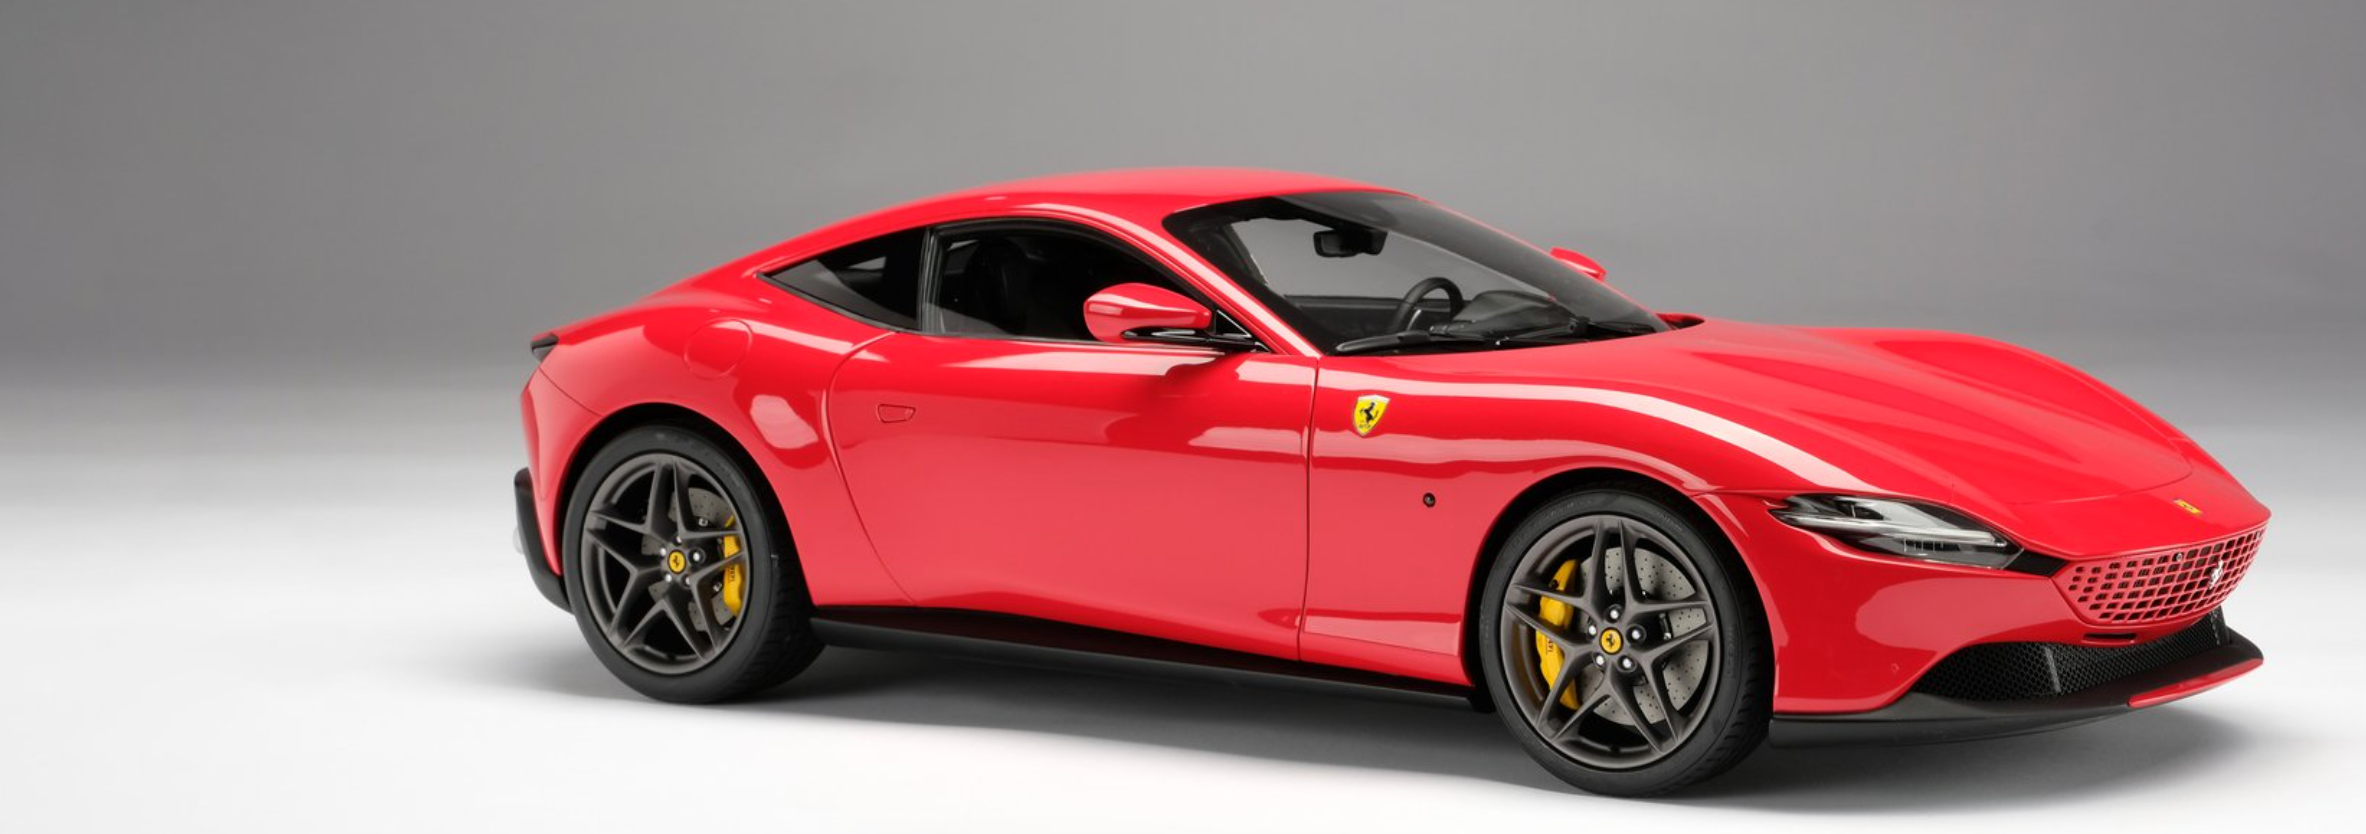

## Постановка задачи

Собрать данные для тренировочного набора с помощью web-scraping, проанализировать и обработать эти данные, а в дальнейшем попробовать обучить на данных различные модели машинного обучения. По результатам с помощью метрики MAPE(Mean Percentage Absolute Error) выбрать модель, которая будет более точно предсказывать стоимость автомобиля по его характеристикам

In [1]:
# загружаем бибилиотеки
import os
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import f_regression, mutual_info_regression

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_val_score, KFold,RepeatedKFold, StratifiedKFold
from tqdm.notebook import tqdm

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500) 
sns.set(rc={'figure.figsize': (8, 5)}) 
plt.style.use('seaborn-deep')

# Определяем функции

In [2]:
def percentage_error(actual, predicted):
    """
    Вычисляет и выводит 
    :param:  actual - 
             predicted - 
    :return: res - 

    """
    
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Вычисляет метрику MAPE - среднюю абсолютную ошибку в процентах

    :param:   y_true - реальная стоимость автомобиля
              y_pred - предсказанная стоимость автомобиля
    :return: значение метрики MAPE
    """
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

def cat_plot(col, rotation=90):
    """
    Строит бар-плот для категориальных признаков
    :param:  col - название колонки
    
    """
    df = train[col].value_counts()
    plt.title(f'Распределение {col}', fontsize=15)
    sns.barplot(x=df.index, y=df.values, palette='Blues_r_d')
    plt.xticks(rotation=rotation);  
    
def cat_boxplot(col, rotation=90):
    """
    Строит бокс-плот для категориальных признаков
    :param:  col - название колонки
    
    """
    plt.title(f'Распределение цен на авто от значений {col}', fontsize=15)
    sns.boxplot(x=col, y='price', data=train, palette='Blues_r_d')
    plt.xticks(rotation=rotation);  
    
def check_values(col):
    """
     Проверяет, есть ли принимаемые значения признака одновременно в тренировочном и в тестовом дата сетах
     :param:  col - название колонки
   
    """
    train_col = set(train[col].unique())
    test_col = set(test[col].unique())
    result = test_col - train_col
    if len(result) == 0:
        print('Все уникальные значения test присутствуют в train')
    else:
        print(f'В train.{col} нет значений: {result}')
    
def enginePower_rate(power):
    """ 
    Присваивает значение рейта/ тарифа в зависимости от 
     мощности двигателя :param:  power - значение мощности двигателя 
     
     """
    if power > 250:
        return 150
    elif power > 225:
        return 75
    elif power > 200:
        return 65
    elif power > 175:
        return 50
    elif power > 150:
        return 45
    elif power > 125:
        return 35
    elif power > 100:
        return 25
    else:
        return 12
    
def equipment_top(cell):
    x = 0
    for i in equipment_top_lst:
        if i in cell:
            x += 1
    return x

def equipment_rare(cell):
    x = 0
    for i in equipment_rare_lst:
        if i in cell:
            x += 1
    return x

def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_val):
    d_df = pd.DataFrame()
    for model_ in tqdm(d_models):
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_val)
        d_df[str(model_)[:6]] = np.exp(y_pred)                   
    return d_df

# Загрузка и первичный просмотр данных

Для предсказания стоимости автомобилей нами были иcпользованы данные с сайта авто.ру Данные были получены с помощью парсинга и библиотек Request и Beautiful Soup, более подробно информацию можно посмотреть в ноутбуке по парсингу

In [3]:
train = pd.read_csv('big_train_LR.csv')
train.drop('Unnamed: 0', axis=1, inplace=True)
test = pd.read_csv('test-pr.csv')

Предварительно проведем общую оценку данных

In [4]:
print('train:', train.shape)
print('test:', test.shape)

train: (129321, 33)
test: (34686, 32)


В тренировочном дата сете 129321 и в тестовом - 34686 записей об автомобилях. Имеется 33 и 32 колонки о характеристиках этих автомобилей, из которых 9 (6)числовых и 24 (26) категориальных соответственно. Возможно придется привести характеристики/ признаки к общему типу данных или изменить его. Тестовый набор имеет на одну колонку меньше, так как не включена колонка о ценах на автомобили.

## Описание дата сета

Название колонки | Описание
:-- | :--
__bodyType__ | тип кузова
__brand__ |марка автомобиля 
__car_url__ | ссылка на автомобиль
__color__ | цвет автомобиля
__complectation_dict__  | комплектация (словарь)
__description__ | описание
__engineDisplacement__ | объем двигателя
__enginePower__ | мощность двигателя
__equipment_dict__ | комплектация(словарь)
__fuelType__ | тип топлива (значения: бензин,дизель, электро, гибрид, газ)
__image__ | фотография/изображение
__mileage__ | пробег (километры)
__modelDate__ | дата модели
__model_info__ | информация о модели
__model_name__ | название модели
__name__ | наименование двигатель и тип трансмиссии
__numberOfDoors__ | количество дверей
__parsing_unixtime__ | дата время парсинга
__priceCurrency__ | валюта для цены
__productionDate__ | дата производства
__sell_id__ | идентификатор продажи
__super_gen__ |  дополнительная информация          
__vehicleConfiguration__ | конфигурация автомобиля
__vehicleTransmission__ | трансмиссия / коробка передач (значения:механическая, автоматическая, вариатор, роботизированная)
__vendor__ | производитель              
__Владельцы__ | количество предыдущих владельцев (значения: 1, 2, 3 и более)
__Владение__ | владение            
__ПТС__ | наличие/ отсутствие ПТС
__Привод__ | тип привода (значения: передний, задний,полный)              
__Руль__ | расположение руля (значения: левый / правый)
__Состояние__ | состояние автомобиля (значения: требует / не требует ремонта)
__Таможня__ | ратоможен/нерастоможен

In [5]:
print('train:')
display(train.head(3))
print()
print('test:')
display(test.head(3))

train:


bodyType brand                                            car_url  \
0    седан  AUDI  https://auto.ru/cars/used/sale/audi/100/108027...   
1    седан  AUDI  https://auto.ru/cars/used/sale/audi/100/109156...   
2    седан  AUDI  https://auto.ru/cars/used/sale/audi/100/109599...   

         color  complectation_dict  \
0      голубой                 NaN   
1  серебристый                 NaN   
2        серый                 NaN   

                                         description engineDisplacement  \
0  Куплена не в кредит. Своевременное обслуживани...            2.3 LTR   
1  Авто на  ходу езжу каждый день имеются косяки ...            2.6 LTR   
2  Продам Audi 100 c3 90г. Машина не идеальна, ез...            2.3 LTR   

  enginePower                                     equipment_dict fuelType  \
0     133 N12  {'tinted-glass': True, 'abs': True, 'wheel-pow...   бензин   
1     150 N12  {'tinted-glass': True, '16-inch-wheels': True,...   бензин   
2     136 N12                                                 {}   бензин   

                                               image   mileage  modelDate  \
0  https://autoru.naydex.net/1gek7D451/db78d3X7bE...  410000.0     1990.0   
1  https://avatars.mds.yandex.net/get-autoru-vos/...  350000.0     1990.0   
2  https://avatars.mds.yandex.net/get-autoru-vos/...  453000.0     1988.0   

                                          model_info model_name  \
0  {'code': '100', 'name': '100', 'ru_name': '100...        100   
1  {'code': '100', 'name': '100', 'ru_name': '100...        100   
2  {'code': '100', 'name': '100', 'ru_name': '100...        100   

                name  numberOfDoors priceCurrency  productionDate  \
0  2.3 MT (133 л.с.)            4.0           RUB          1993.0   
1  2.6 AT (150 л.с.)            4.0           RUB          1993.0   
2  2.3 MT (136 л.с.)            4.0           RUB          1990.0   

        sell_id                                          super_gen  \
0  1.080280e+09  {'id': '7879487', 'displacement': 2309, 'engin...   
1  1.091567e+09  {'id': '7879494', 'displacement': 2598, 'engin...   
2  1.095993e+09  {'id': '21188602', 'displacement': 2309, 'engi...   

   vehicleConfiguration vehicleTransmission  vendor    Владельцы  \
0  SEDAN MECHANICAL 2.3        механическая     NaN  3 или более   
1   SEDAN AUTOMATIC 2.6      автоматическая     NaN  3 или более   
2  SEDAN MECHANICAL 2.3        механическая     NaN  3 или более   

            Владение       ПТС    Привод   Руль           Состояние  \
0  4 года и 3 месяца  Дубликат  передний  Левый  Не требует ремонта   
1                NaN  Оригинал  передний  Левый  Не требует ремонта   
2                NaN  Оригинал  передний  Левый  Не требует ремонта   

      Таможня     price  parsing_unixtime  
0  Растаможен  160000.0               NaN  
1  Растаможен  150000.0               NaN  
2  Растаможен   70000.0               NaN


test:


bodyType  brand                                            car_url   color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   синий   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  чёрный   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   серый   

                                  complectation_dict  \
0                                                NaN   
1                                                NaN   
2  {"id":"20026336","name":"Ambition","available_...   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    88000       2013   

                                          model_info model_name  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
2  {"code":"SUPERB","name":"Superb","ru_name":"Су...     SUPERB   

                     name  numberOfDoors  parsing_unixtime priceCurrency  \
0      1.2 AMT (105 л.с.)              5        1603226273           RUB   
1       1.6 MT (110 л.с.)              5        1603226277           RUB   
2  DSG 1.8 AMT (152 л.с.)              5        1603226280           RUB   

   productionDate     sell_id  \
0            2014  1100575026   
1            2017  1100549428   
2            2014  1100658222   

                                           super_gen     vehicleConfiguration  \
0  {"id":"10373605","displacement":1197,"engine_t...       LIFTBACK ROBOT 1.2   
1  {"id":"20913311","displacement":1598,"engine_t...  LIFTBACK MECHANICAL 1.6   
2  {"id":"20026323","nameplate":"DSG","displaceme...       LIFTBACK ROBOT 1.8   

  vehicleTransmission    vendor    Владельцы Владение       ПТС    Привод  \
0    роботизированная  EUROPEAN  3 или более      NaN  Оригинал  передний   
1        механическая  EUROPEAN   1 владелец      NaN  Оригинал  передний   
2    роботизированная  EUROPEAN   1 владелец      NaN  Оригинал  передний   

    Руль           Состояние     Таможня  
0  Левый  Не требует ремонта  Растаможен  
1  Левый  Не требует ремонта  Растаможен  
2  Левый  Не требует ремонта  Растаможен

In [6]:
#удаляем дупликаты
train = train.drop_duplicates()
train.duplicated().sum()

0

In [7]:
# проверяем количество строк после удаления дубликатов
train.shape

(126416, 33)

In [8]:
test.shape

(34686, 32)

In [9]:
# добавляем колонку с длиной описания
train['len_description'] = train.description.apply(lambda x: len(str(x)))
test['len_description'] = test.description.apply(lambda x: len(str(x)))

Рассмотрим общие статитстические показатели по данным в обоих датасетах

In [10]:
train.describe()

complectation_dict         mileage      modelDate  numberOfDoors  \
count                 0.0   126348.000000  126347.000000  126347.000000   
mean                  NaN   169931.329724    2006.691350       4.470221   
std                   NaN   107016.531932       8.136167       0.674591   
min                   NaN        1.000000    1934.000000       2.000000   
25%                   NaN    90948.000000    2002.000000       4.000000   
50%                   NaN   155818.000000    2008.000000       5.000000   
75%                   NaN   231344.000000    2013.000000       5.000000   
max                   NaN  1000000.000000    2020.000000       5.000000   

       productionDate       sell_id  vendor         price  parsing_unixtime  \
count   126348.000000  1.263480e+05     0.0  1.187700e+05      1.167440e+05   
mean      2008.824034  1.100960e+09     NaN  1.259948e+06      1.618694e+09   
std          7.816050  1.343370e+07     NaN  1.478903e+06      2.630685e+04   
min       1934.000000  2.665000e+03     NaN  2.000000e+04      1.618656e+09   
25%       2004.000000  1.101807e+09     NaN  4.100000e+05      1.618684e+09   
50%       2011.000000  1.102770e+09     NaN  8.000000e+05      1.618695e+09   
75%       2015.000000  1.103060e+09     NaN  1.580000e+06      1.618703e+09   
max       2021.000000  1.103342e+09     NaN  4.000000e+07      1.618834e+09   

       len_description  
count    126416.000000  
mean        725.735049  
std         822.389250  
min           1.000000  
25%         176.000000  
50%         419.000000  
75%        1005.000000  
max       29427.000000

In [11]:
test.describe()

mileage     modelDate  numberOfDoors  parsing_unixtime  \
count    34686.000000  34686.000000   34686.000000      3.468600e+04   
mean    162009.767889   2007.074728       4.450816      1.603287e+09   
std     100676.559489      7.415894       0.703040      1.493071e+05   
min          1.000000   1904.000000       0.000000      1.603107e+09   
25%      91153.500000   2004.000000       4.000000      1.603221e+09   
50%     149779.500000   2008.000000       5.000000      1.603254e+09   
75%     215000.000000   2012.000000       5.000000      1.603290e+09   
max    1000000.000000   2020.000000       5.000000      1.603710e+09   

       productionDate       sell_id  len_description  
count    34686.000000  3.468600e+04     34686.000000  
mean      2009.264602  1.098300e+09       642.407340  
std          7.047661  1.911225e+07       778.750118  
min       1904.000000  2.665000e+03         1.000000  
25%       2006.000000  1.099049e+09       167.000000  
50%       2011.000000  1.100911e+09       371.000000  
75%       2014.000000  1.101245e+09       869.000000  
max       2020.000000  1.101375e+09     28789.000000

## Целевая переменная и удаление ненужных признаков

In [12]:
# создаем список колонок на удаление
col_drop = ['car_url', 'complectation_dict', 'description', 'image', 'model_info',
            'name', 'parsing_unixtime', 'priceCurrency', 'sell_id', 'vehicleConfiguration']

In [13]:
# удаляем ненужные/неинформативные колонки
train.drop(col_drop, axis=1, inplace=True)
test.drop(col_drop, axis=1, inplace=True)

Посмотрим на распределение целевой переменной

In [14]:
train.dropna(subset=['price'], inplace=True)

Логорифмируем таргет

In [15]:
train.price = np.log(train.price)

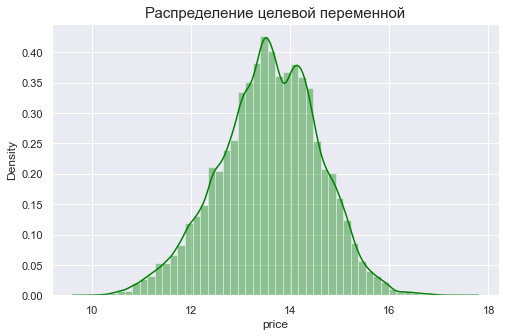

In [16]:
plt.title('Распределение целевой переменной', fontsize=15)
sns.distplot(train.price, color='green');

## Работа с пропусками

In [17]:
#выводим количество пропусков
print('train:')
display(train.isna().sum()[train.isna().sum() > 0])
print()
print('test:')
display(test.isna().sum()[test.isna().sum() > 0])

train:


bodyType                    1
fuelType                    1
modelDate                   1
numberOfDoors               1
super_gen                   1
vehicleTransmission         1
vendor                 118770
Владельцы                   5
Владение                84392
ПТС                         6
Привод                      1
dtype: int64


test:


equipment_dict     9996
Владение          22691
ПТС                   1
dtype: int64

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'mileage', 'modelDate', 'model_name',
       'numberOfDoors', 'productionDate', 'super_gen', 'vehicleTransmission',
       'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'price', 'len_description'],
      dtype='object')


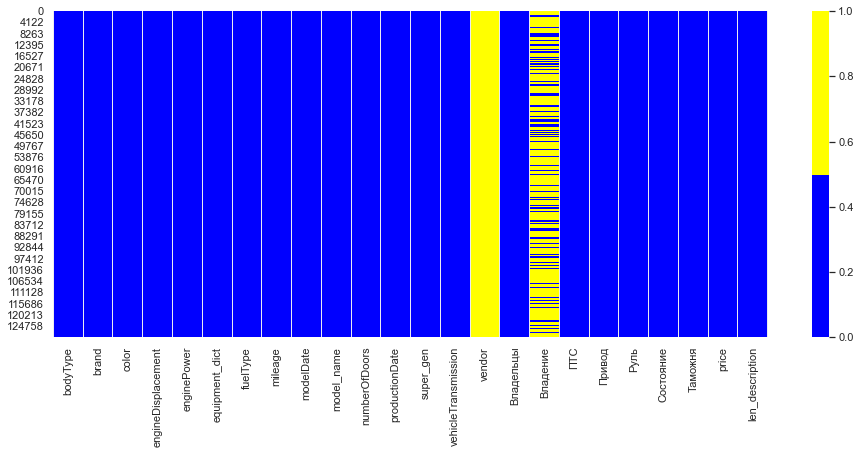

In [18]:
# Посмотрим на пропуски на heat_map диаграмме, так будет наиболее наглядно
cols_train = train.columns
print(cols_train)
colours = ['blue', 'yellow']
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull(), cmap=sns.color_palette(colours))

Пока нет данных по производителям, мы заполним ту колонку на основании марки машины. На диаграмме видно, что очень много пропусков в колонке Владение и есть пропуски в колонке цена. Остальные пропуски столь незначительны, что практически не различимы на диаграмме, в дальнейшем предполагается удалить или заполнить строки с пропусками.
Построим такую же диаграмму по пропускам в тестовом наборе данных

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'mileage', 'modelDate', 'model_name',
       'numberOfDoors', 'productionDate', 'super_gen', 'vehicleTransmission',
       'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'len_description'],
      dtype='object')


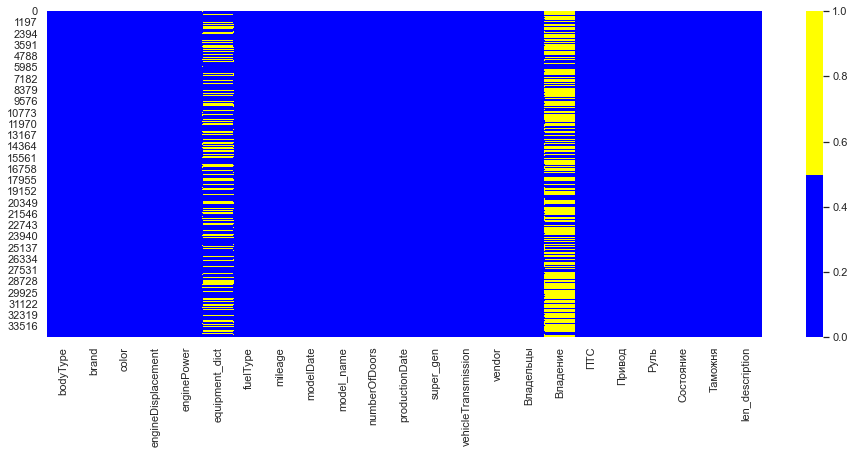

In [19]:
cols_test = test.columns
print(cols_test)
colours = ['blue', 'yellow']
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull(), cmap=sns.color_palette(colours))

В тестовом наборе данных большой процент пропусков в колонках complectation_dict, equipment_dict и Владение

In [20]:
# удаляем неинформативные колонки
train.dropna(subset=['ПТС', 'bodyType', 'Владельцы'], inplace=True)

In [21]:
# создаем списки по европейским и японским производителям и заполняем колонку Vendor
european = ['SKODA', 'AUDI', 'VOLVO', 'BMW', 'MERCEDES', 'VOLKSWAGEN']
japanese = ['HONDA', 'NISSAN', 'INFINITI', 'TOYOTA', 'LEXUS', 'MITSUBISHI']

train.loc[train.brand.isin(european), 'vendor'] = 'EUROPEAN'
train.loc[train.brand.isin(japanese), 'vendor'] = 'JAPANESE'

In [22]:
# Пропуски в колонке ПТС заменяем модой
test['ПТС'].fillna(train.ПТС.mode()[0], inplace=True)
test.equipment_dict.fillna('{}', inplace=True)

In [23]:
# проверяем нулевые значения еще раз
print('train:')
display(train.isna().sum()[train.isna().sum() > 0])
print()
print('test:')
display(test.isna().sum()[test.isna().sum() > 0])

train:


Владение    84381
dtype: int64


test:


Владение    22691
dtype: int64

Сгруппируем признаки в  категории по типу их обработки (категориальные, числовые, признаки состоящие из словарей) для дальнейшего удобного анализа. 

In [24]:
num_cols = ['mileage', 'modelDate', 'numberOfDoors', 'productionDate']
cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
            'fuelType', 'model_name', 'vehicleConfiguration', 'vehicleTransmission', 
            'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
dict_col = ['equipment_dict', 'super_gen']

In [25]:
train.reset_index(drop=True, inplace=True)

In [26]:
# приводим числовые колонки к одному типу
train[num_cols] = train[num_cols].astype('int64')
test[num_cols] = test[num_cols].astype('int64')

## Числовые

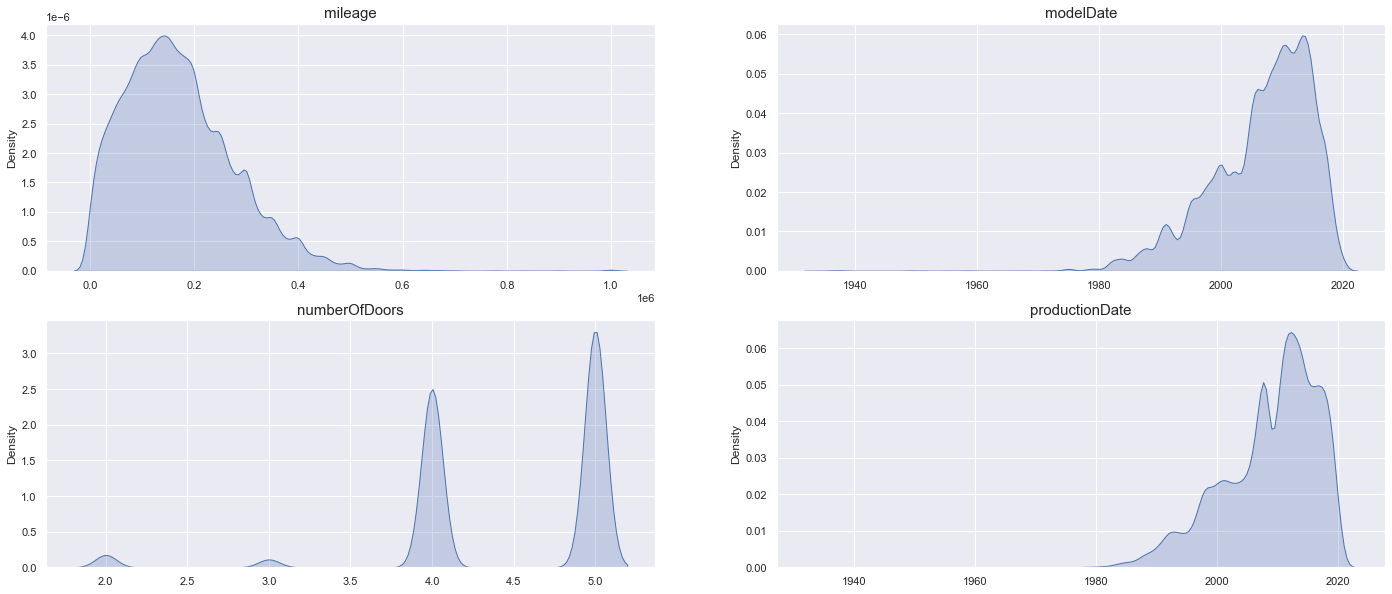

In [27]:
plt.figure(figsize=(24,10))
for i, col in enumerate(num_cols):
    plt.subplot(2,2, i+1)
    plt.title(col, fontsize=15)
    sns.kdeplot(x=col, data=train, shade=True)
    plt.xlabel(None)  





На основе этих графиков можно сделать вывод, что пробег состявляет у большигства машин и для некоторых машин в пределе до . По второму графику слава основные категории состявляют 4-5 дверные машины, имеется небольшой процент 2-х и 3-х дверных машин. Графики для modelDate и productionDate в целом очень похожи. Представленные машины были произведены в период с 1980 по 2020 годы (также имеются и более ранние машины, но их очень мало). Основную массу составляют машины примерно, начиная с 2010 года.

## Категориальные

### bodyType

In [28]:
#смотрим распределение по типу кузова
train.bodyType = train.bodyType.str.findall(r'^\S+').str[0]
test.bodyType = test.bodyType.str.findall(r'^\S+').str[0]

5 наиболее популярных значений - это внедорожник, седан, хэтчбек, лифтбек и универсал, из которых первые два составляют основную массу

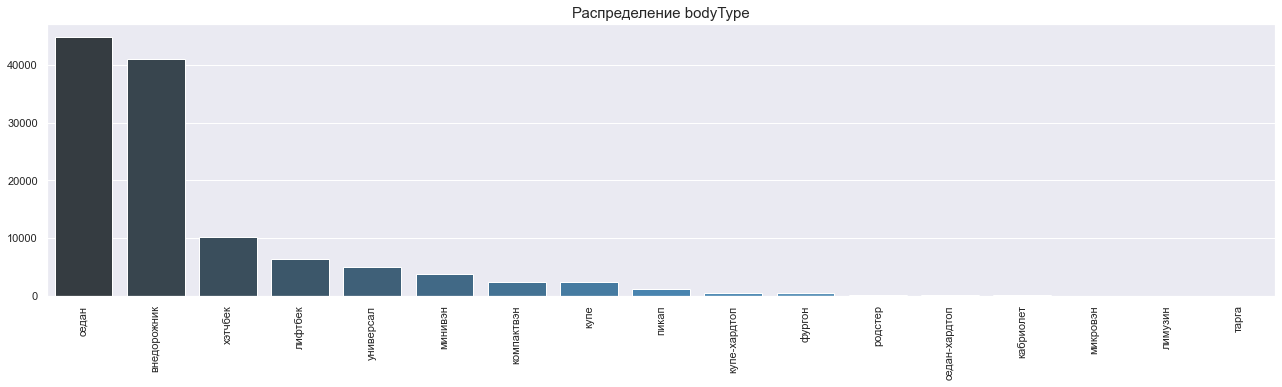

In [29]:
plt.figure(figsize=(22,5))
cat_plot('bodyType')

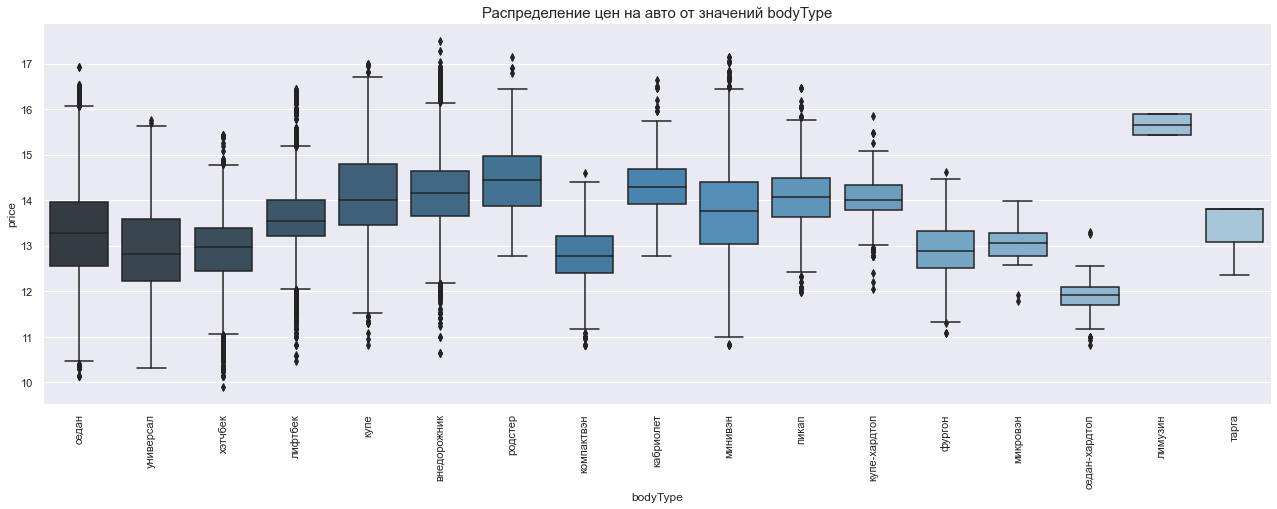

In [30]:
plt.figure(figsize=(22,7))
cat_boxplot('bodyType')

In [31]:
check_values('bodyType')

В train.bodyType нет значений: {'фастбек'}


In [32]:
test.loc[test.bodyType == 'фастбек', 'bodyType'] = 'хэтчбек'

### brand

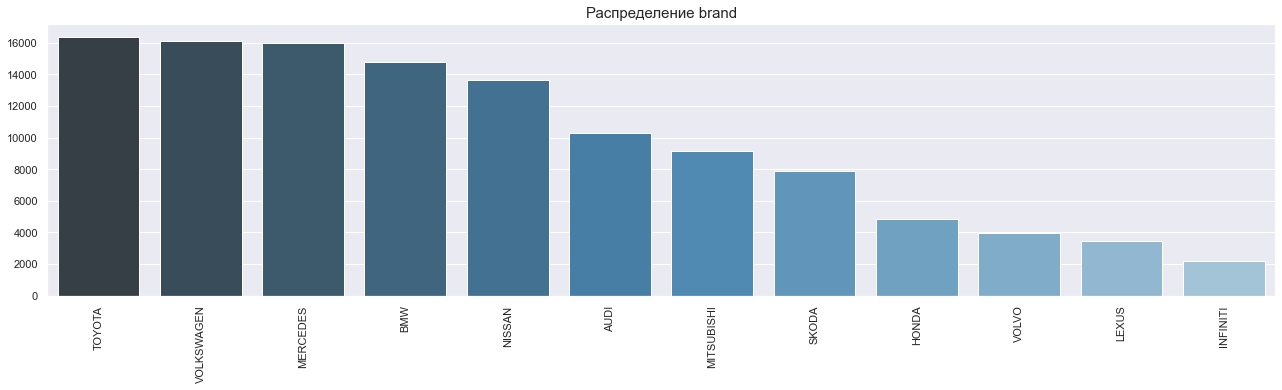

In [33]:
#смотрим распределение по бренду
plt.figure(figsize=(22,5))
cat_plot('brand')

Популярны бенды: VOLKSWAGEN, BMW, MERCEDES, TOYOTA, NISSAN, AUDI, SKODA, MITSUBISHI и менее популярны VOLVO, HONDA, LEXUS, INFINITI

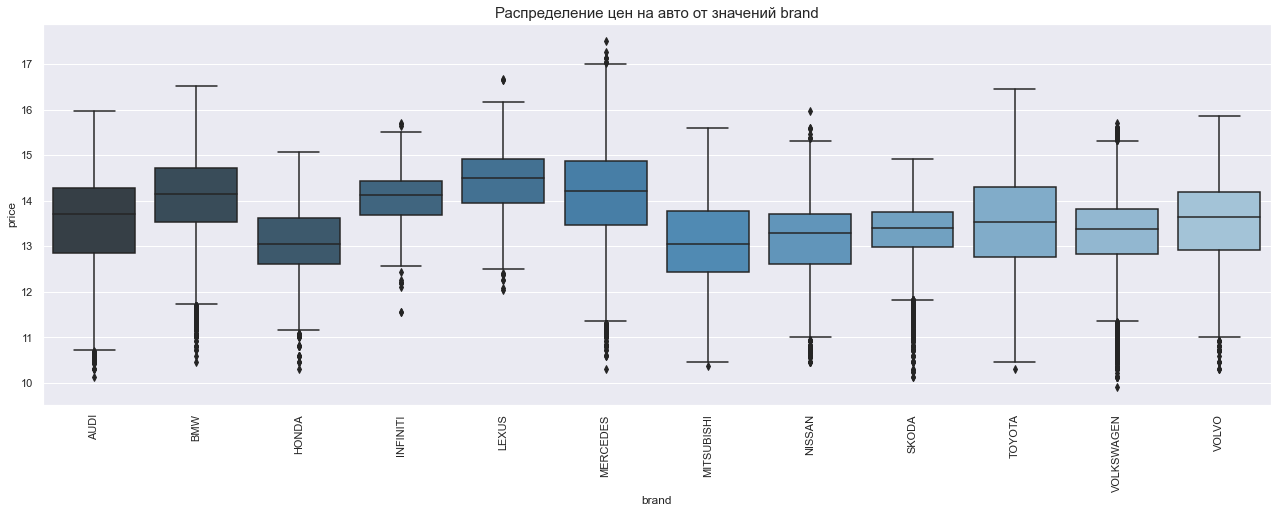

In [34]:
plt.figure(figsize=(22,7))
cat_boxplot('brand')

In [35]:
check_values('brand')

Все уникальные значения test присутствуют в train


### color

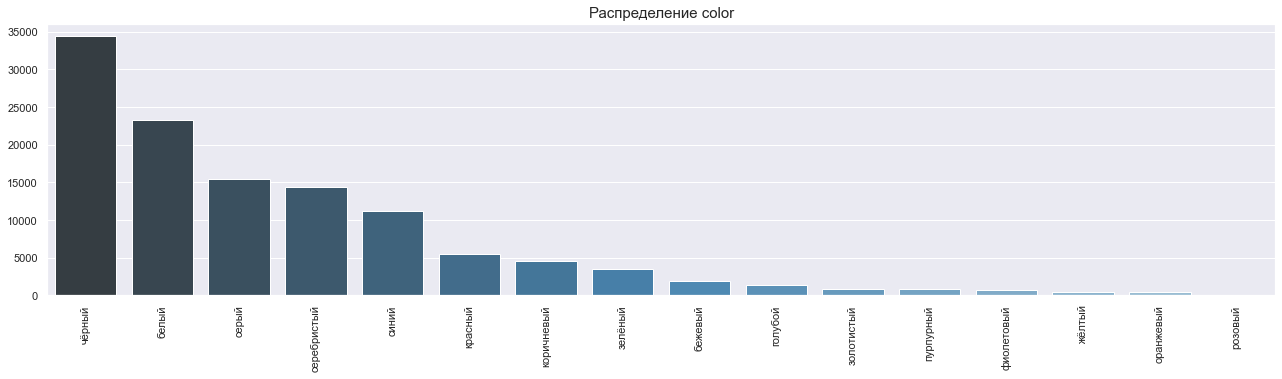

In [36]:
plt.figure(figsize=(22,5))
cat_plot('color')

Часто встречающиеся популярные цвета - это черный, белый, серый, серебристый. Редко встречаются фиолетовый, желтый, оранжевый, розовый. Всего 16 уникальных значений

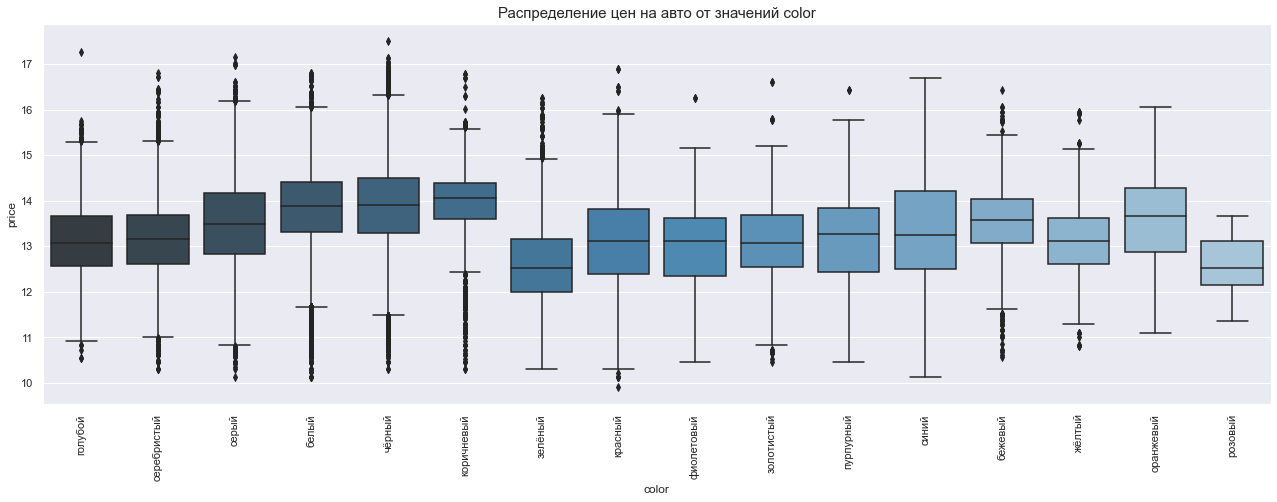

In [37]:
plt.figure(figsize=(22,7))
cat_boxplot('color')

In [38]:
check_values('color')

Все уникальные значения test присутствуют в train


### engineDisplacement

In [39]:
#смотрим распределение по объему двигателя
train.engineDisplacement = train.engineDisplacement.str.findall(r"\d.\d").str[0]
train.engineDisplacement.fillna('0', inplace=True)

test.engineDisplacement = test.engineDisplacement.str.findall(r"\d.\d").str[0]
test.engineDisplacement.fillna('0', inplace=True)


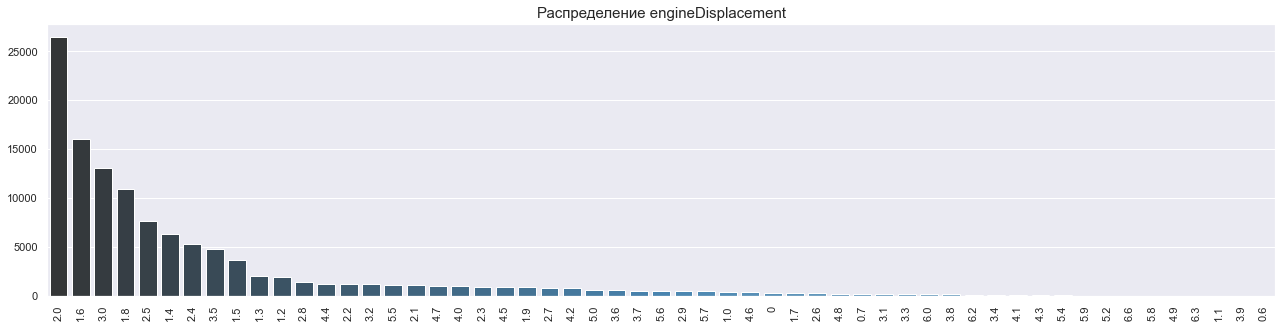

In [40]:
plt.figure(figsize=(22,5))
cat_plot('engineDisplacement', rotation=90)

In [41]:
check_values('engineDisplacement')

В train.engineDisplacement нет значений: {'5.3'}


In [42]:
# приводим значение колонки типу float64
train.engineDisplacement = train.engineDisplacement.astype('float64')
test.engineDisplacement = test.engineDisplacement.astype('float64')

### enginePower

In [43]:
#смотрим распределение по мощности двигателя
train.enginePower = train.enginePower.str.findall(r'^\S+').str[0]
train.enginePower = train.enginePower.apply(lambda x: int(x))

test.enginePower = test.enginePower.str.findall(r'^\S+').str[0]
test.enginePower = test.enginePower.apply(lambda x: int(x))

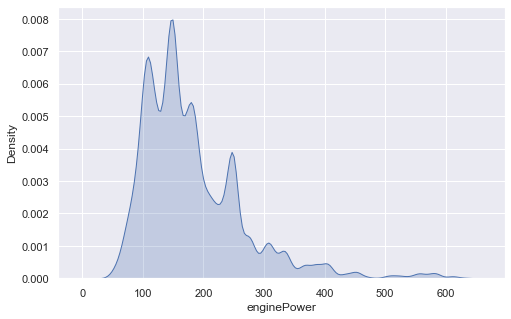

In [44]:
sns.kdeplot(x='enginePower', data=train, shade=True);

In [45]:
train['enginePower_rate'] = train.enginePower.apply(enginePower_rate)
test['enginePower_rate'] = test.enginePower.apply(enginePower_rate)

train['tax'] = train.enginePower_rate * train.enginePower
test['tax'] = test.enginePower_rate * test.enginePower

In [46]:
train.drop('enginePower_rate', axis=1, inplace=True)
test.drop('enginePower_rate', axis=1, inplace=True)

### fuelType

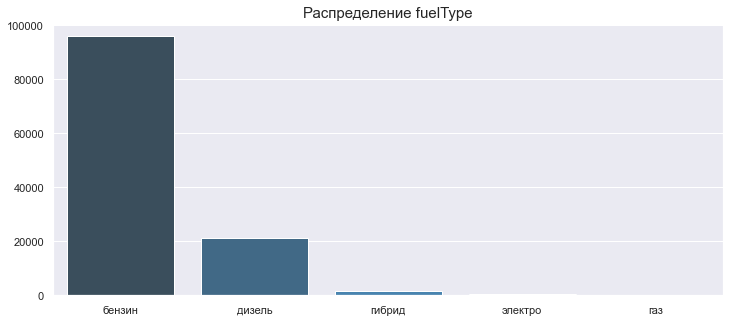

In [47]:
#смотрим распределение по типу топлива
plt.figure(figsize=(12,5))
cat_plot('fuelType', rotation=0)

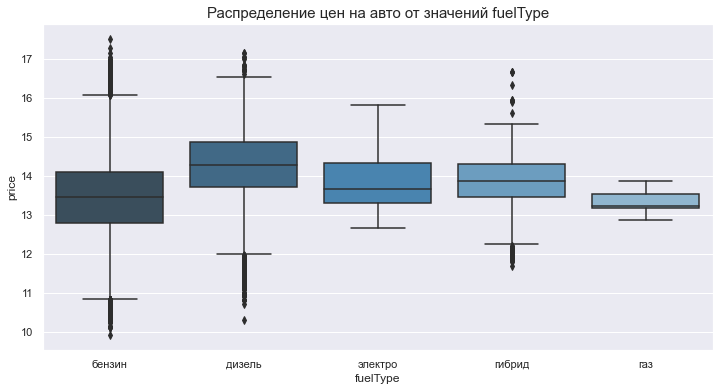

In [48]:
plt.figure(figsize=(12,6))
cat_boxplot('fuelType', rotation=0)

In [49]:
check_values('fuelType')

Все уникальные значения test присутствуют в train


### model_name

In [50]:
check_values('model_name')

В train.model_name нет значений: {'E3', 'SIMPLEX', '140', 'GRANVIA', 'CALIFORNIA', 'EUROVAN', 'TT_RS', 'ATLAS', 'M1', 'VERSO_S', 'TARO', 'POPULAR', 'ORIGIN', 'V60', '100NX', 'GOLF_R32', '280ZX', 'SLC_KLASSE', '100_SERIES'}


In [51]:
train['model_name_hash'] = train.model_name.apply(lambda x: abs(hash(x)))
test['model_name_hash'] = test.model_name.apply(lambda x: abs(hash(x)))

In [52]:
scaler = StandardScaler()
train['model_name_hash'] = scaler.fit_transform(train[['model_name_hash']])
test['model_name_hash'] = scaler.transform(test[['model_name_hash']])

In [53]:
train.drop('model_name', axis=1, inplace=True)
test.drop('model_name', axis=1, inplace=True)

### vehicleTransmission

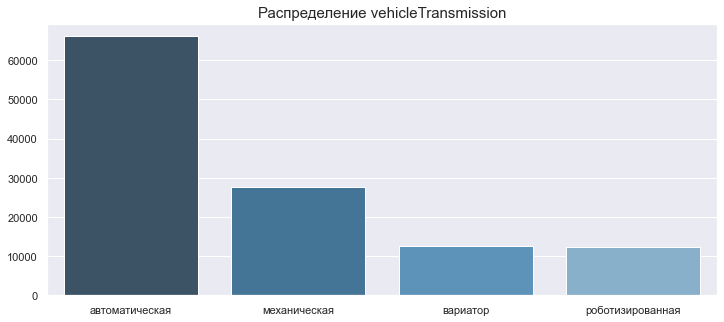

In [54]:
#смотрим распределение по коробке передач
plt.figure(figsize=(12,5))
cat_plot('vehicleTransmission', rotation=0)

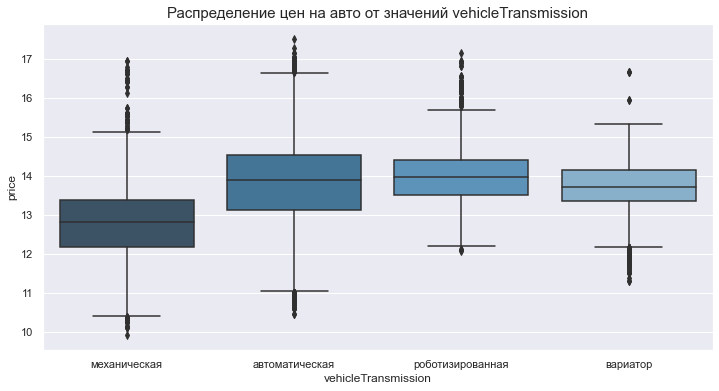

In [55]:
plt.figure(figsize=(12,6))
cat_boxplot('vehicleTransmission', rotation=0)

In [56]:
check_values('vehicleTransmission')

Все уникальные значения test присутствуют в train


### vendor

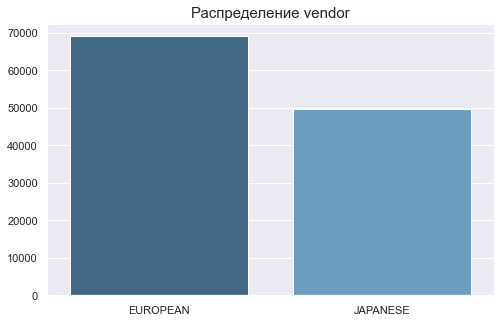

In [57]:
#смотрим распределение по производителю
cat_plot('vendor', rotation=0)

Европейских машин больше, чем японских примерно в 1,5 раза

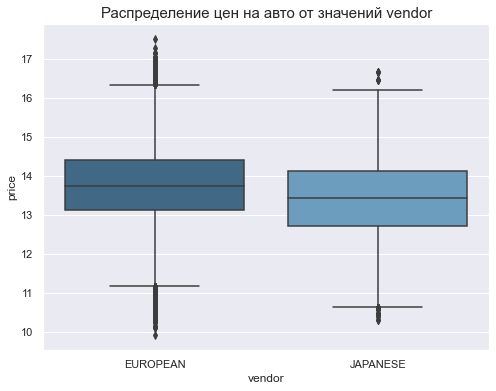

In [58]:
plt.figure(figsize=(8,6))
cat_boxplot('vendor', rotation=0)

In [59]:
check_values('vendor')

Все уникальные значения test присутствуют в train


In [60]:
vendor_dict = {'EUROPEAN': 0, 'JAPANESE': 1}

train.vendor = train.vendor.map(vendor_dict)
test.vendor = test.vendor.map(vendor_dict)

### Владельцы

In [61]:
#смотрим распределение по количеству владельцев
train.Владельцы = train.Владельцы.str.findall('\d').str[0]
test.Владельцы = test.Владельцы.str.findall('\d').str[0]

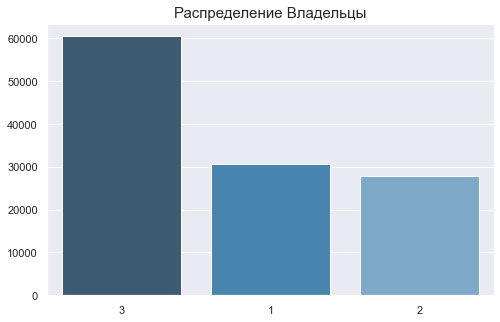

In [62]:
cat_plot('Владельцы', rotation=0)

Принимаемые значения 3, 1 и 2 расположены по степени популярности

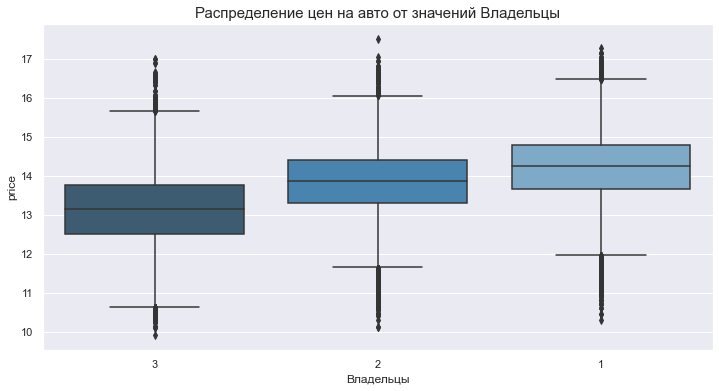

In [63]:
plt.figure(figsize=(12,6))
cat_boxplot('Владельцы', rotation=0)

In [64]:
check_values('Владельцы')

Все уникальные значения test присутствуют в train


In [65]:
train.Владельцы = train.Владельцы.astype('int32')
test.Владельцы = test.Владельцы.astype('int32')

### Владение

In [66]:
# удаляем колонку владение
train.drop('Владение', axis=1, inplace=True)
test.drop('Владение', axis=1, inplace=True)

### ПТС

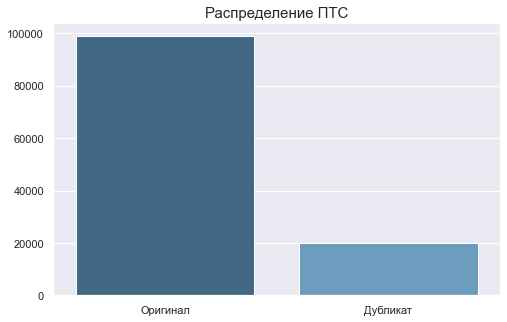

In [67]:
#смотрим распределение по ПТС (оригинал или дубликат)
cat_plot('ПТС', rotation=0)

В основной массе у автомобилей оригинал ПТС, имеются также машины с дубликатами, но их не так много

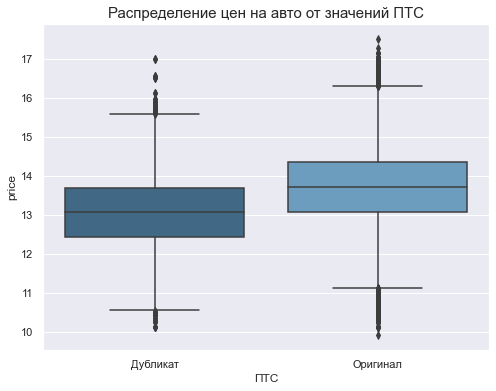

In [68]:
plt.figure(figsize=(8,6))
cat_boxplot('ПТС', rotation=0)

In [69]:
check_values('ПТС')

Все уникальные значения test присутствуют в train


In [70]:
pts_dict = {'Оригинал': 0, 'Дубликат': 1}

train.ПТС = train.ПТС.map(pts_dict)
test.ПТС = test.ПТС.map(pts_dict)

### Привод

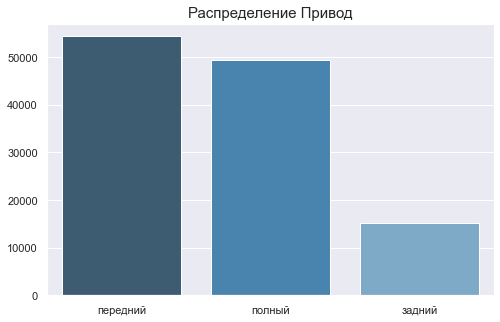

In [71]:
#смотрим распределение значений по колонке Привод
cat_plot('Привод', rotation=0)

Примерно одинаковое количество машин с передним и полным приводом, они составляют основную массу. Также есть машины с задним приводом

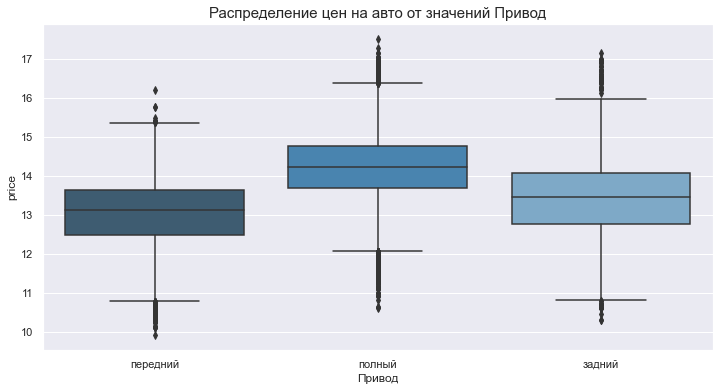

In [72]:
plt.figure(figsize=(12,6))
cat_boxplot('Привод', rotation=0)

In [73]:
check_values('Привод')

Все уникальные значения test присутствуют в train


### Руль

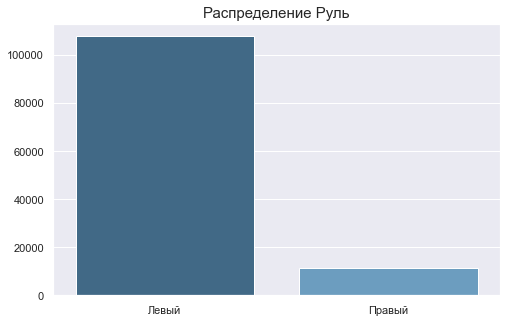

In [74]:
#смотрим распределение значений по колонке Руль
cat_plot('Руль', rotation=0)

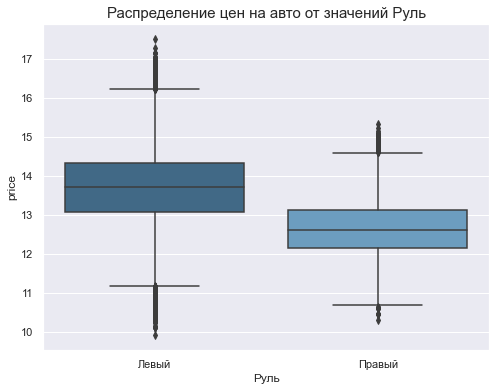

In [75]:
plt.figure(figsize=(8,6))
cat_boxplot('Руль', rotation=0)

In [76]:
check_values('Руль')

Все уникальные значения test присутствуют в train


In [77]:
steering_dict = {'Левый': 0, 'Правый': 1}

train.Руль = train.Руль.map(steering_dict)
test.Руль = test.Руль.map(steering_dict)

Значения колонки Руль мы привели к виду: левый - это 0, правый - 1. Большинство машин с левым рулем и лишь незначительно количество с правым

### Состояние

In [78]:
#смотрим распределение значений по колонке Состояние
train.Состояние.value_counts()

Не требует ремонта    118746
Битый / не на ходу        13
Name: Состояние, dtype: int64

Имеется только 13 значений битый / не на ходу, остальные машины не требуют ремонта. Значения принимаемые в колонке неинформативны, колонку можно удалить

In [79]:
train.drop(train[train.Состояние == 'Битый / не на ходу'].index, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

train.drop('Состояние', axis=1, inplace=True)
test.drop('Состояние', axis=1, inplace=True)


Принимает только одно значение (константа), можно удалить эту колонку

### Таможня

In [80]:
print('train')
display(train.Таможня.value_counts())
print()
print('test')
display(test.Таможня.value_counts())

train


Растаможен       118740
Не растаможен         6
Name: Таможня, dtype: int64


test


Растаможен    34686
Name: Таможня, dtype: int64

In [81]:
train.drop('Таможня', axis=1, inplace=True)
test.drop('Таможня', axis=1, inplace=True)

## Словари

### equipment_dict

In [82]:
train['equipment_dict'] = train['equipment_dict'].str.findall(r"'(\b.*?\b)'")
test['equipment_dict'] = test['equipment_dict'].str.findall(r'"(\b.*?\b)"')

In [83]:
mlb = MultiLabelBinarizer()

In [84]:
equipment_train = mlb.fit_transform(train['equipment_dict'])
equipment_test = mlb.transform(test['equipment_dict'])

equipment_train = pd.DataFrame(data = equipment_train, columns = mlb.classes_)
equipment_test = pd.DataFrame(data = equipment_test, columns = mlb.classes_)

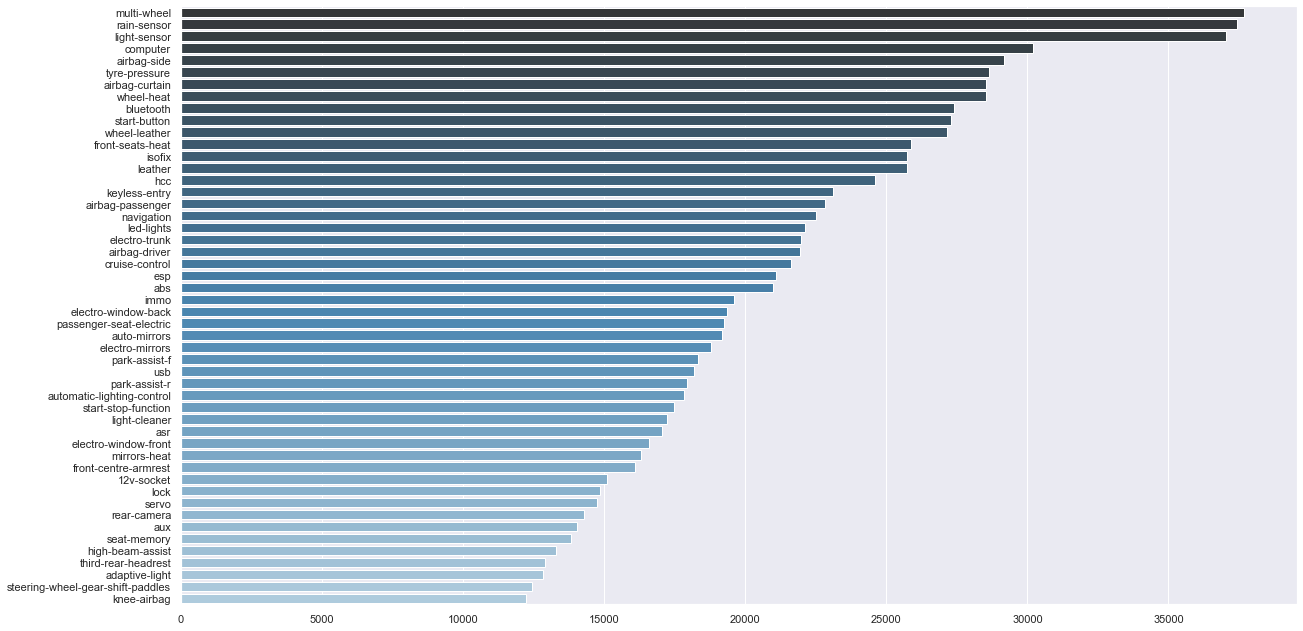

In [85]:
f_scores = f_regression(equipment_train, train.price)[0]
f_scores = pd.Series(f_scores, equipment_train.columns).sort_values(ascending=False)[:50]

plt.figure(figsize=(20,11))
sns.barplot(x=f_scores.values, y=f_scores.index, palette='Blues_r_d');

In [86]:
f_scores_top = f_scores.index

equipment_train = equipment_train[f_scores_top]
equipment_test = equipment_test[f_scores_top]

# Метрика улучшается если не добавлять еще признаков
# train = pd.concat([train, equipment_train], axis=1)
# test = pd.concat([test, equipment_test], axis=1)

In [87]:
train['equipment_count'] = train['equipment_dict'].apply(len)
test['equipment_count'] = test['equipment_dict'].apply(len)

In [88]:
train['equipment_isna'] = train['equipment_count'].astype('bool') * 1
test['equipment_isna'] = test['equipment_count'].astype('bool') * 1

In [89]:
equipment_vc = train['equipment_dict'].explode().value_counts()
equipment_top_lst = equipment_vc.index[:10]
equipment_rare_lst = equipment_vc[equipment_vc < 50].index

In [90]:
train['equipment_top'] = train['equipment_dict'].apply(equipment_top)
test['equipment_top'] = test['equipment_dict'].apply(equipment_top)

train['equipment_rare'] = train['equipment_dict'].apply(equipment_rare)
test['equipment_rare'] = test['equipment_dict'].apply(equipment_rare)

In [91]:
train.drop(columns= ['equipment_dict'], inplace=True)
test.drop(columns= ['equipment_dict'], inplace=True)

### super_gen 

In [92]:
train.drop('super_gen', axis=1, inplace=True)
test.drop('super_gen', axis=1, inplace=True)

## Корреляция

In [93]:
corr = train[num_cols + ['price']].corr()

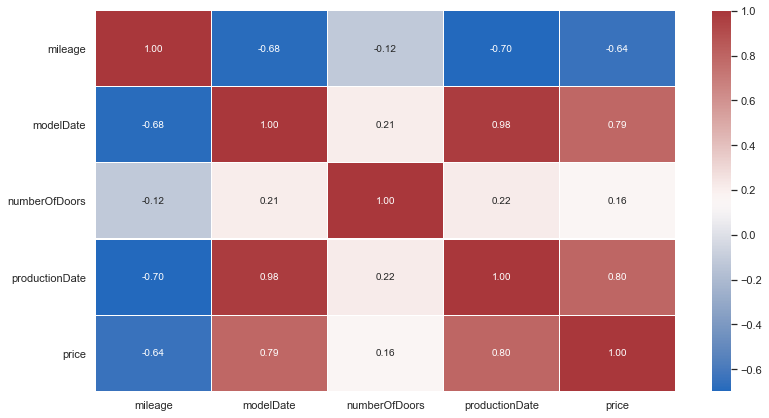

In [94]:
plt.figure(figsize=(13,7))
sns.heatmap(corr, annot=True, cmap='vlag',
            fmt='.2f', linewidths=0.1, annot_kws={"fontsize":10});

### LabelEncoder

In [95]:
coll = ['bodyType', 'brand', 'color']

In [96]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for c in coll:
    train[c] = le.fit_transform(train[[c]])
    test[c] = le.transform(test[[c]])

### OneHotEncoder

In [97]:
df = pd.concat([train, test], axis=0)
df = pd.get_dummies(df)

train = df[~df.price.isna()]
test = df[df.price.isna()]
test = test.drop(columns=['price'])

In [98]:
test.head(2)

bodyType  brand  color  engineDisplacement  enginePower  mileage  \
0         6      8     13                 1.2          105    74000   
1         6      8     15                 1.6          110    60563   

   modelDate  numberOfDoors  productionDate  vendor  Владельцы  ПТС  Руль  \
0       2013              5            2014       0          3    0     0   
1       2017              5            2017       0          1    0     0   

   len_description   tax  model_name_hash  equipment_count  equipment_isna  \
0             1001  2625          1.22996               36               1   
1             2609  2750          1.22996               34               1   

   equipment_top  equipment_rare  fuelType_бензин  fuelType_газ  \
0              9               0                1             0   
1              9               0                1             0   

   fuelType_гибрид  fuelType_дизель  fuelType_электро  \
0                0                0                 0   
1                0                0                 0   

   vehicleTransmission_автоматическая  vehicleTransmission_вариатор  \
0                                   0                             0   
1                                   0                             0   

   vehicleTransmission_механическая  vehicleTransmission_роботизированная  \
0                                 0                                     1   
1                                 1                                     0   

   Привод_задний  Привод_передний  Привод_полный  
0              0                1              0  
1              0                1              0

In [99]:
train.head(2)

bodyType  brand  color  engineDisplacement  enginePower  mileage  \
0        11      0      2                 2.3          133   410000   
1        11      0     11                 2.6          150   350000   

   modelDate  numberOfDoors  productionDate  vendor  Владельцы  ПТС  Руль  \
0       1990              4            1993       0          3    1     0   
1       1990              4            1993       0          3    0     0   

       price  len_description   tax  model_name_hash  equipment_count  \
0  11.982929              987  4655        -1.637295                8   
1  11.918391              483  5250        -1.637295               11   

   equipment_isna  equipment_top  equipment_rare  fuelType_бензин  \
0               1              2               0                1   
1               1              2               0                1   

   fuelType_газ  fuelType_гибрид  fuelType_дизель  fuelType_электро  \
0             0                0                0                 0   
1             0                0                0                 0   

   vehicleTransmission_автоматическая  vehicleTransmission_вариатор  \
0                                   0                             0   
1                                   1                             0   

   vehicleTransmission_механическая  vehicleTransmission_роботизированная  \
0                                 1                                     0   
1                                 0                                     0   

   Привод_задний  Привод_передний  Привод_полный  
0              0                1              0  
1              0                1              0

In [100]:
# введем новый признак "tax" (расчет годового налога):
train['tax2'] = train.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)


test['tax2'] = test.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)

In [101]:
# преобразуем productionDate в чистый возраст авто:
train['productionDate2'] = 2021 - train['productionDate']
test['productionDate2'] = 2021 - test['productionDate']
train['productionDate2'] = train['productionDate'] .astype(float)
test['productionDate2'] = test['productionDate'] .astype(float)

In [102]:
# преобразуем modelDate в чистый возраст модели:
train['modelDate2'] = 2021 - train['modelDate']
test['modelDate2'] = 2021 - test['modelDate']
train['modelDate2'] = train['modelDate'].astype(float)
test['modelDate2'] = test['modelDate'].astype(float)



In [103]:

test.head(2)

bodyType  brand  color  engineDisplacement  enginePower  mileage  \
0         6      8     13                 1.2          105    74000   
1         6      8     15                 1.6          110    60563   

   modelDate  numberOfDoors  productionDate  vendor  Владельцы  ПТС  Руль  \
0       2013              5            2014       0          3    0     0   
1       2017              5            2017       0          1    0     0   

   len_description   tax  model_name_hash  equipment_count  equipment_isna  \
0             1001  2625          1.22996               36               1   
1             2609  2750          1.22996               34               1   

   equipment_top  equipment_rare  fuelType_бензин  fuelType_газ  \
0              9               0                1             0   
1              9               0                1             0   

   fuelType_гибрид  fuelType_дизель  fuelType_электро  \
0                0                0                 0   
1                0                0                 0   

   vehicleTransmission_автоматическая  vehicleTransmission_вариатор  \
0                                   0                             0   
1                                   0                             0   

   vehicleTransmission_механическая  vehicleTransmission_роботизированная  \
0                                 0                                     1   
1                                 1                                     0   

   Привод_задний  Привод_передний  Привод_полный  tax2  productionDate2  \
0              0                1              0  2625           2014.0   
1              0                1              0  2750           2017.0   

   modelDate2  
0      2013.0  
1      2017.0

## Проверка значимости признаков

### Числовые

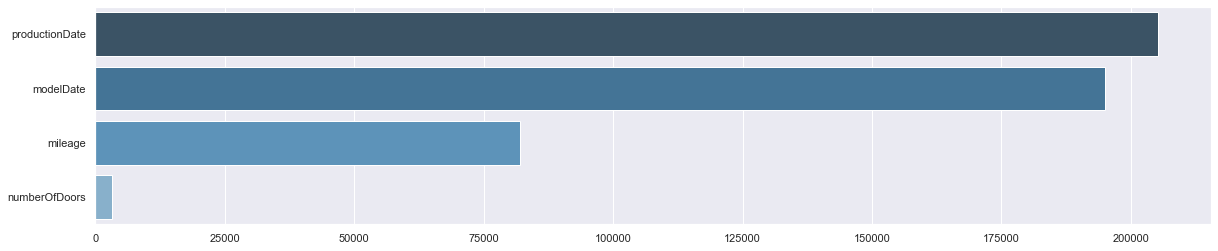

In [104]:
f_scores = f_regression(train[num_cols], train.price)[0]
f_scores = pd.Series(f_scores, num_cols).sort_values(ascending=False)

plt.figure(figsize=(20,4))
sns.barplot(x=f_scores.values, y=f_scores.index, palette='Blues_r_d');

In [105]:
train = train.rename(columns = {'Владельцы': 'Owners', 'ПТС': 'PTC', 'Руль': 'sweel',
                        'fuelType_бензин': 'petrol','fuelType_газ': 'gas', 'fuelType_гибрид': 'hybrid', 
                        'fuelType_дизель': 'disel','fuelType_электро': 'electro', 
                        'vehicleTransmission_автоматическая': 'automatic',
                       'vehicleTransmission_вариатор': 'var',
                       'vehicleTransmission_механическая': 'mech',
                       'vehicleTransmission_роботизированная': 'robot',
                       'Привод_задний': 'rear',
                       'Привод_передний': 'front',
                       'Привод_полный': 'full'}, inplace = False)
test = test.rename(columns = {'Владельцы': 'Owners', 'ПТС': 'PTC', 'Руль': 'sweel',
                        'fuelType_бензин': 'petrol','fuelType_газ': 'gas', 'fuelType_гибрид': 'hybrid', 
                        'fuelType_дизель': 'disel','fuelType_электро': 'electro', 
                        'vehicleTransmission_автоматическая': 'automatic',
                       'vehicleTransmission_вариатор': 'var',
                       'vehicleTransmission_механическая': 'mech',
                       'vehicleTransmission_роботизированная': 'robot',
                       'Привод_задний': 'rear',
                       'Привод_передний': 'front',
                       'Привод_полный': 'full'}, inplace = False)

In [106]:
test= test.drop(columns= ['enginePower', 'disel'])
train= train.drop(columns= ['enginePower', 'disel'])

## Модель

In [107]:
X = train.drop('price', axis=1)
y = train.price

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
y_test = np.exp(y_test)

In [110]:
import sklearn
print(sklearn.__version__)

0.23.1


### RandomForestRegressor

In [111]:
# param = {'n_estimators': [400],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12]}

In [112]:
# rf = RandomForestRegressor(random_state=42)
# rcv = RandomizedSearchCV(estimator=rf, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=20)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [113]:
# rcv.best_params_

In [111]:
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_features='log2')
# rf.fit(X_train, y_train)
# predict = rf.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict)
# MAPE * 100

In [113]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(20)

modelDate2            0.159936
modelDate             0.142546
productionDate        0.121169
productionDate2       0.117818
tax                   0.080447
tax2                  0.076300
mileage               0.062572
engineDisplacement    0.041154
front                 0.029201
full                  0.026152
equipment_count       0.021505
bodyType              0.018692
Owners                0.015883
brand                 0.012535
model_name_hash       0.010861
mech                  0.009436
len_description       0.009427
equipment_top         0.008486
petrol                0.007525
automatic             0.006417
dtype: float64

### ExtraTreesRegressor

In [116]:
# param = {'n_estimators': [200],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12],
#          'bootstrap': [True, False]}

In [117]:
# etr = ExtraTreesRegressor(random_state=42)
# rcv = RandomizedSearchCV(estimator=etr, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=20)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [118]:
# rcv.best_params_

In [112]:
etr = ExtraTreesRegressor(n_estimators=500, random_state=42, n_jobs=-1, bootstrap=True)
# etr.fit(X_train, y_train)
# predict = etr.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict)
# MAPE * 100

### CatBoostRegressor

In [115]:
# params = {'iterations': [5000],
#           'depth': [None, 4, 5, 6, 7],
#           'l2_leaf_reg': [0.1, 0.4, 1, 3, 5],
#           'random_strength': [0, 0.3, 0.7, 1]}

In [116]:
# cbr = CatBoostRegressor(random_seed=20, loss_function='MAPE', 
#                         eval_metric='MAPE', verbose=0)
# rs_cbr = cbr.randomized_search(params, X, y, cv=3, n_iter=20)
# rs_cbr['params']


bestTest = 0.01018680976
bestIteration = 4999

0:	loss: 0.0101868	best: 0.0101868 (0)	total: 1m 50s	remaining: 34m 54s

bestTest = 0.01017292645
bestIteration = 4999

1:	loss: 0.0101729	best: 0.0101729 (1)	total: 3m 36s	remaining: 32m 29s

bestTest = 0.01016467918
bestIteration = 4999

2:	loss: 0.0101647	best: 0.0101647 (2)	total: 5m 37s	remaining: 31m 55s

bestTest = 0.0101110246
bestIteration = 4999

3:	loss: 0.0101110	best: 0.0101110 (3)	total: 7m 25s	remaining: 29m 41s

bestTest = 0.01011977707
bestIteration = 4999

4:	loss: 0.0101198	best: 0.0101110 (3)	total: 10m 2s	remaining: 30m 8s

bestTest = 0.010102981
bestIteration = 4999

5:	loss: 0.0101030	best: 0.0101030 (5)	total: 13m 6s	remaining: 30m 35s

bestTest = 0.01010544278
bestIteration = 4999

6:	loss: 0.0101054	best: 0.0101030 (5)	total: 17m 21s	remaining: 32m 13s

bestTest = 0.009797281575
bestIteration = 4999

7:	loss: 0.0097973	best: 0.0097973 (7)	total: 21m 59s	remaining: 32m 59s

bestTest = 0.009784354953
bestIteration 

KeyboardInterrupt: 

In [113]:
cbr = CatBoostRegressor(iterations = 5000,
                        random_seed = 30,
                        loss_function='MAPE',
                        learning_rate=0.06,
                        depth=7,
                        random_strength=0.3,
                        l2_leaf_reg=0.15)

# cbr.fit(X_train, y_train,
#         eval_set=(X_test, np.log(y_test)),
#         verbose_eval=0,
#         use_best_model=True);

In [120]:
predict = np.exp(cbr.predict(X_test))
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.156640320706845

In [124]:
# predict = np.exp(model.predict(test))

In [125]:
# submission = pd.read_csv('sample_submission.csv')
# submission['price'] = predict * 0.90
# # submission.to_csv('submission-1.csv', index=False)
# submission['price'] = np.round(submission['price']*2, -4)/2
# # сохранить в файл
# submission.to_csv('submission-1.csv', index=False)

### LGBMRegressor

In [126]:
# param = {'n_estimators': [2500],
#          'learning_rate': [0.1],
#          'max_depth': [-1, 2, 4, 6],
#          'num_leaves': [20, 30 , 40, 50],
#          'min_child_samples': [None, 5, 10, 20],
#          'lambda_l2': [0.05, 0.1, 0.3, 0.8, 1.5]}

In [127]:
# lgbm = LGBMRegressor(objective='regression', random_state=30)
# rcv = RandomizedSearchCV(estimator=lgbm, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [128]:
# rcv.best_params_

In [114]:
lgbm = LGBMRegressor(objective='mape', 
                     random_state=30,
                     n_estimators=2500,
                     learning_rate=0.05,
                     lambda_l2=0.5)

# lgbm.fit(X_train, y_train,
#          eval_set=(X_test, np.log(y_test)))

In [124]:
predict = lgbm.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.539448814166242

### Xgb

In [115]:

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate= 0.01 ,max_depth=25, alpha=1,
                          n_estimators=5000,tree_method='gpu_hist',)

In [128]:
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=25,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [129]:
predict = xg_reg.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

9.62728212652959

In [115]:
predict = np.exp(xg_reg.predict(test))

submission = pd.read_csv('sample_submission.csv')
submission['price'] = predict * 0.9
submission.to_csv('submission-1.csv', index=False)

# Stacking

In [ ]:
estimators = [('cbr', cbr), ('fr', rf), ('etr', etr), ('lgbm', lgbm),('xgb', xg_reg)]
stacking = StackingRegressor(estimators=estimators,
                             final_estimator=Ridge())
stacking.fit(X_train, y_train)

0:	learn: 0.0571031	total: 192ms	remaining: 15m 57s
1:	learn: 0.0544623	total: 223ms	remaining: 9m 17s
2:	learn: 0.0519516	total: 252ms	remaining: 6m 59s
3:	learn: 0.0495331	total: 280ms	remaining: 5m 50s
4:	learn: 0.0472987	total: 309ms	remaining: 5m 9s
5:	learn: 0.0452062	total: 339ms	remaining: 4m 42s
6:	learn: 0.0433087	total: 372ms	remaining: 4m 25s
7:	learn: 0.0415174	total: 412ms	remaining: 4m 17s
8:	learn: 0.0398221	total: 447ms	remaining: 4m 8s
9:	learn: 0.0381228	total: 489ms	remaining: 4m 4s
10:	learn: 0.0365793	total: 521ms	remaining: 3m 56s
11:	learn: 0.0351225	total: 553ms	remaining: 3m 50s
12:	learn: 0.0338582	total: 591ms	remaining: 3m 46s
13:	learn: 0.0326348	total: 636ms	remaining: 3m 46s
14:	learn: 0.0313861	total: 681ms	remaining: 3m 46s
15:	learn: 0.0303279	total: 737ms	remaining: 3m 49s
16:	learn: 0.0293033	total: 776ms	remaining: 3m 47s
17:	learn: 0.0282937	total: 818ms	remaining: 3m 46s
18:	learn: 0.0273352	total: 856ms	remaining: 3m 44s
19:	learn: 0.0264717	tot

162:	learn: 0.0119651	total: 6.14s	remaining: 3m 2s
163:	learn: 0.0119535	total: 6.19s	remaining: 3m 2s
164:	learn: 0.0119431	total: 6.23s	remaining: 3m 2s
165:	learn: 0.0119330	total: 6.26s	remaining: 3m 2s
166:	learn: 0.0119160	total: 6.29s	remaining: 3m 2s
167:	learn: 0.0119061	total: 6.32s	remaining: 3m 1s
168:	learn: 0.0118956	total: 6.36s	remaining: 3m 1s
169:	learn: 0.0118873	total: 6.41s	remaining: 3m 2s
170:	learn: 0.0118769	total: 6.44s	remaining: 3m 1s
171:	learn: 0.0118696	total: 6.47s	remaining: 3m 1s
172:	learn: 0.0118625	total: 6.5s	remaining: 3m 1s
173:	learn: 0.0118514	total: 6.54s	remaining: 3m 1s
174:	learn: 0.0118429	total: 6.56s	remaining: 3m
175:	learn: 0.0118323	total: 6.59s	remaining: 3m
176:	learn: 0.0118249	total: 6.62s	remaining: 3m
177:	learn: 0.0118145	total: 6.65s	remaining: 3m
178:	learn: 0.0118068	total: 6.68s	remaining: 2m 59s
179:	learn: 0.0118003	total: 6.7s	remaining: 2m 59s
180:	learn: 0.0117935	total: 6.73s	remaining: 2m 59s
181:	learn: 0.0117880	t

324:	learn: 0.0107754	total: 10.8s	remaining: 2m 34s
325:	learn: 0.0107720	total: 10.8s	remaining: 2m 34s
326:	learn: 0.0107666	total: 10.8s	remaining: 2m 34s
327:	learn: 0.0107627	total: 10.9s	remaining: 2m 34s
328:	learn: 0.0107603	total: 10.9s	remaining: 2m 34s
329:	learn: 0.0107539	total: 10.9s	remaining: 2m 34s
330:	learn: 0.0107499	total: 10.9s	remaining: 2m 34s
331:	learn: 0.0107453	total: 11s	remaining: 2m 34s
332:	learn: 0.0107418	total: 11s	remaining: 2m 33s
333:	learn: 0.0107371	total: 11s	remaining: 2m 33s
334:	learn: 0.0107314	total: 11s	remaining: 2m 33s
335:	learn: 0.0107273	total: 11.1s	remaining: 2m 33s
336:	learn: 0.0107226	total: 11.1s	remaining: 2m 33s
337:	learn: 0.0107193	total: 11.1s	remaining: 2m 33s
338:	learn: 0.0107148	total: 11.1s	remaining: 2m 33s
339:	learn: 0.0107106	total: 11.2s	remaining: 2m 33s
340:	learn: 0.0107061	total: 11.2s	remaining: 2m 33s
341:	learn: 0.0106987	total: 11.2s	remaining: 2m 33s
342:	learn: 0.0106936	total: 11.3s	remaining: 2m 32s
3

483:	learn: 0.0101432	total: 15.4s	remaining: 2m 23s
484:	learn: 0.0101364	total: 15.5s	remaining: 2m 23s
485:	learn: 0.0101316	total: 15.5s	remaining: 2m 23s
486:	learn: 0.0101278	total: 15.5s	remaining: 2m 23s
487:	learn: 0.0101253	total: 15.5s	remaining: 2m 23s
488:	learn: 0.0101228	total: 15.6s	remaining: 2m 23s
489:	learn: 0.0101195	total: 15.6s	remaining: 2m 23s
490:	learn: 0.0101169	total: 15.6s	remaining: 2m 23s
491:	learn: 0.0101138	total: 15.7s	remaining: 2m 23s
492:	learn: 0.0101115	total: 15.7s	remaining: 2m 23s
493:	learn: 0.0101095	total: 15.7s	remaining: 2m 23s
494:	learn: 0.0101061	total: 15.7s	remaining: 2m 23s
495:	learn: 0.0101019	total: 15.8s	remaining: 2m 23s
496:	learn: 0.0100987	total: 15.8s	remaining: 2m 23s
497:	learn: 0.0100965	total: 15.8s	remaining: 2m 22s
498:	learn: 0.0100934	total: 15.8s	remaining: 2m 22s
499:	learn: 0.0100893	total: 15.9s	remaining: 2m 22s
500:	learn: 0.0100872	total: 15.9s	remaining: 2m 22s
501:	learn: 0.0100830	total: 15.9s	remaining: 

639:	learn: 0.0097595	total: 20s	remaining: 2m 16s
640:	learn: 0.0097576	total: 20s	remaining: 2m 16s
641:	learn: 0.0097561	total: 20s	remaining: 2m 16s
642:	learn: 0.0097535	total: 20.1s	remaining: 2m 16s
643:	learn: 0.0097511	total: 20.1s	remaining: 2m 15s
644:	learn: 0.0097469	total: 20.1s	remaining: 2m 15s
645:	learn: 0.0097436	total: 20.2s	remaining: 2m 15s
646:	learn: 0.0097406	total: 20.2s	remaining: 2m 15s
647:	learn: 0.0097394	total: 20.2s	remaining: 2m 15s
648:	learn: 0.0097380	total: 20.3s	remaining: 2m 15s
649:	learn: 0.0097365	total: 20.3s	remaining: 2m 15s
650:	learn: 0.0097352	total: 20.3s	remaining: 2m 15s
651:	learn: 0.0097327	total: 20.3s	remaining: 2m 15s
652:	learn: 0.0097310	total: 20.4s	remaining: 2m 15s
653:	learn: 0.0097300	total: 20.4s	remaining: 2m 15s
654:	learn: 0.0097287	total: 20.4s	remaining: 2m 15s
655:	learn: 0.0097260	total: 20.5s	remaining: 2m 15s
656:	learn: 0.0097237	total: 20.5s	remaining: 2m 15s
657:	learn: 0.0097207	total: 20.5s	remaining: 2m 15s

799:	learn: 0.0094689	total: 24.6s	remaining: 2m 9s
800:	learn: 0.0094678	total: 24.6s	remaining: 2m 9s
801:	learn: 0.0094667	total: 24.7s	remaining: 2m 9s
802:	learn: 0.0094647	total: 24.7s	remaining: 2m 9s
803:	learn: 0.0094634	total: 24.7s	remaining: 2m 8s
804:	learn: 0.0094615	total: 24.7s	remaining: 2m 8s
805:	learn: 0.0094606	total: 24.8s	remaining: 2m 8s
806:	learn: 0.0094596	total: 24.8s	remaining: 2m 8s
807:	learn: 0.0094562	total: 24.8s	remaining: 2m 8s
808:	learn: 0.0094554	total: 24.8s	remaining: 2m 8s
809:	learn: 0.0094536	total: 24.9s	remaining: 2m 8s
810:	learn: 0.0094519	total: 24.9s	remaining: 2m 8s
811:	learn: 0.0094505	total: 24.9s	remaining: 2m 8s
812:	learn: 0.0094486	total: 25s	remaining: 2m 8s
813:	learn: 0.0094475	total: 25s	remaining: 2m 8s
814:	learn: 0.0094462	total: 25s	remaining: 2m 8s
815:	learn: 0.0094450	total: 25.1s	remaining: 2m 8s
816:	learn: 0.0094431	total: 25.1s	remaining: 2m 8s
817:	learn: 0.0094420	total: 25.1s	remaining: 2m 8s
818:	learn: 0.0094

962:	learn: 0.0092348	total: 29.4s	remaining: 2m 3s
963:	learn: 0.0092340	total: 29.4s	remaining: 2m 3s
964:	learn: 0.0092330	total: 29.4s	remaining: 2m 3s
965:	learn: 0.0092320	total: 29.5s	remaining: 2m 3s
966:	learn: 0.0092308	total: 29.5s	remaining: 2m 3s
967:	learn: 0.0092298	total: 29.5s	remaining: 2m 2s
968:	learn: 0.0092288	total: 29.6s	remaining: 2m 2s
969:	learn: 0.0092284	total: 29.6s	remaining: 2m 2s
970:	learn: 0.0092269	total: 29.6s	remaining: 2m 2s
971:	learn: 0.0092258	total: 29.6s	remaining: 2m 2s
972:	learn: 0.0092251	total: 29.7s	remaining: 2m 2s
973:	learn: 0.0092242	total: 29.7s	remaining: 2m 2s
974:	learn: 0.0092226	total: 29.7s	remaining: 2m 2s
975:	learn: 0.0092218	total: 29.8s	remaining: 2m 2s
976:	learn: 0.0092203	total: 29.8s	remaining: 2m 2s
977:	learn: 0.0092198	total: 29.8s	remaining: 2m 2s
978:	learn: 0.0092185	total: 29.8s	remaining: 2m 2s
979:	learn: 0.0092173	total: 29.9s	remaining: 2m 2s
980:	learn: 0.0092157	total: 29.9s	remaining: 2m 2s
981:	learn: 

1123:	learn: 0.0090633	total: 34.3s	remaining: 1m 58s
1124:	learn: 0.0090625	total: 34.3s	remaining: 1m 58s
1125:	learn: 0.0090612	total: 34.3s	remaining: 1m 58s
1126:	learn: 0.0090607	total: 34.4s	remaining: 1m 58s
1127:	learn: 0.0090601	total: 34.4s	remaining: 1m 58s
1128:	learn: 0.0090587	total: 34.4s	remaining: 1m 58s
1129:	learn: 0.0090579	total: 34.4s	remaining: 1m 57s
1130:	learn: 0.0090573	total: 34.5s	remaining: 1m 57s
1131:	learn: 0.0090563	total: 34.5s	remaining: 1m 57s
1132:	learn: 0.0090546	total: 34.5s	remaining: 1m 57s
1133:	learn: 0.0090537	total: 34.6s	remaining: 1m 57s
1134:	learn: 0.0090531	total: 34.6s	remaining: 1m 57s
1135:	learn: 0.0090521	total: 34.6s	remaining: 1m 57s
1136:	learn: 0.0090516	total: 34.7s	remaining: 1m 57s
1137:	learn: 0.0090502	total: 34.7s	remaining: 1m 57s
1138:	learn: 0.0090489	total: 34.7s	remaining: 1m 57s
1139:	learn: 0.0090482	total: 34.8s	remaining: 1m 57s
1140:	learn: 0.0090469	total: 34.8s	remaining: 1m 57s
1141:	learn: 0.0090456	total

1279:	learn: 0.0089128	total: 38.9s	remaining: 1m 53s
1280:	learn: 0.0089120	total: 38.9s	remaining: 1m 52s
1281:	learn: 0.0089110	total: 38.9s	remaining: 1m 52s
1282:	learn: 0.0089100	total: 39s	remaining: 1m 52s
1283:	learn: 0.0089093	total: 39s	remaining: 1m 52s
1284:	learn: 0.0089075	total: 39s	remaining: 1m 52s
1285:	learn: 0.0089063	total: 39.1s	remaining: 1m 52s
1286:	learn: 0.0089047	total: 39.1s	remaining: 1m 52s
1287:	learn: 0.0089042	total: 39.1s	remaining: 1m 52s
1288:	learn: 0.0089033	total: 39.1s	remaining: 1m 52s
1289:	learn: 0.0089025	total: 39.2s	remaining: 1m 52s
1290:	learn: 0.0089013	total: 39.2s	remaining: 1m 52s
1291:	learn: 0.0089004	total: 39.2s	remaining: 1m 52s
1292:	learn: 0.0088994	total: 39.3s	remaining: 1m 52s
1293:	learn: 0.0088990	total: 39.3s	remaining: 1m 52s
1294:	learn: 0.0088986	total: 39.3s	remaining: 1m 52s
1295:	learn: 0.0088977	total: 39.3s	remaining: 1m 52s
1296:	learn: 0.0088967	total: 39.4s	remaining: 1m 52s
1297:	learn: 0.0088957	total: 39.4

1435:	learn: 0.0087888	total: 43.4s	remaining: 1m 47s
1436:	learn: 0.0087885	total: 43.4s	remaining: 1m 47s
1437:	learn: 0.0087878	total: 43.5s	remaining: 1m 47s
1438:	learn: 0.0087875	total: 43.5s	remaining: 1m 47s
1439:	learn: 0.0087868	total: 43.5s	remaining: 1m 47s
1440:	learn: 0.0087864	total: 43.5s	remaining: 1m 47s
1441:	learn: 0.0087859	total: 43.6s	remaining: 1m 47s
1442:	learn: 0.0087854	total: 43.6s	remaining: 1m 47s
1443:	learn: 0.0087848	total: 43.6s	remaining: 1m 47s
1444:	learn: 0.0087846	total: 43.7s	remaining: 1m 47s
1445:	learn: 0.0087844	total: 43.7s	remaining: 1m 47s
1446:	learn: 0.0087842	total: 43.7s	remaining: 1m 47s
1447:	learn: 0.0087835	total: 43.7s	remaining: 1m 47s
1448:	learn: 0.0087833	total: 43.8s	remaining: 1m 47s
1449:	learn: 0.0087826	total: 43.8s	remaining: 1m 47s
1450:	learn: 0.0087822	total: 43.8s	remaining: 1m 47s
1451:	learn: 0.0087818	total: 43.8s	remaining: 1m 47s
1452:	learn: 0.0087807	total: 43.9s	remaining: 1m 47s
1453:	learn: 0.0087796	total

1590:	learn: 0.0086871	total: 47.8s	remaining: 1m 42s
1591:	learn: 0.0086869	total: 47.9s	remaining: 1m 42s
1592:	learn: 0.0086865	total: 47.9s	remaining: 1m 42s
1593:	learn: 0.0086860	total: 47.9s	remaining: 1m 42s
1594:	learn: 0.0086855	total: 47.9s	remaining: 1m 42s
1595:	learn: 0.0086848	total: 48s	remaining: 1m 42s
1596:	learn: 0.0086841	total: 48s	remaining: 1m 42s
1597:	learn: 0.0086837	total: 48s	remaining: 1m 42s
1598:	learn: 0.0086830	total: 48.1s	remaining: 1m 42s
1599:	learn: 0.0086827	total: 48.1s	remaining: 1m 42s
1600:	learn: 0.0086818	total: 48.1s	remaining: 1m 42s
1601:	learn: 0.0086814	total: 48.1s	remaining: 1m 42s
1602:	learn: 0.0086809	total: 48.2s	remaining: 1m 42s
1603:	learn: 0.0086797	total: 48.2s	remaining: 1m 42s
1604:	learn: 0.0086792	total: 48.2s	remaining: 1m 41s
1605:	learn: 0.0086786	total: 48.2s	remaining: 1m 41s
1606:	learn: 0.0086784	total: 48.3s	remaining: 1m 41s
1607:	learn: 0.0086776	total: 48.3s	remaining: 1m 41s
1608:	learn: 0.0086770	total: 48.3

1749:	learn: 0.0085899	total: 52.2s	remaining: 1m 36s
1750:	learn: 0.0085897	total: 52.2s	remaining: 1m 36s
1751:	learn: 0.0085894	total: 52.2s	remaining: 1m 36s
1752:	learn: 0.0085890	total: 52.2s	remaining: 1m 36s
1753:	learn: 0.0085886	total: 52.3s	remaining: 1m 36s
1754:	learn: 0.0085883	total: 52.3s	remaining: 1m 36s
1755:	learn: 0.0085878	total: 52.3s	remaining: 1m 36s
1756:	learn: 0.0085875	total: 52.3s	remaining: 1m 36s
1757:	learn: 0.0085871	total: 52.4s	remaining: 1m 36s
1758:	learn: 0.0085859	total: 52.4s	remaining: 1m 36s
1759:	learn: 0.0085852	total: 52.4s	remaining: 1m 36s
1760:	learn: 0.0085847	total: 52.5s	remaining: 1m 36s
1761:	learn: 0.0085843	total: 52.5s	remaining: 1m 36s
1762:	learn: 0.0085837	total: 52.5s	remaining: 1m 36s
1763:	learn: 0.0085832	total: 52.5s	remaining: 1m 36s
1764:	learn: 0.0085824	total: 52.6s	remaining: 1m 36s
1765:	learn: 0.0085822	total: 52.6s	remaining: 1m 36s
1766:	learn: 0.0085817	total: 52.6s	remaining: 1m 36s
1767:	learn: 0.0085809	total

1902:	learn: 0.0085073	total: 56.4s	remaining: 1m 31s
1903:	learn: 0.0085060	total: 56.5s	remaining: 1m 31s
1904:	learn: 0.0085057	total: 56.5s	remaining: 1m 31s
1905:	learn: 0.0085053	total: 56.5s	remaining: 1m 31s
1906:	learn: 0.0085050	total: 56.5s	remaining: 1m 31s
1907:	learn: 0.0085044	total: 56.6s	remaining: 1m 31s
1908:	learn: 0.0085043	total: 56.6s	remaining: 1m 31s
1909:	learn: 0.0085041	total: 56.6s	remaining: 1m 31s
1910:	learn: 0.0085036	total: 56.6s	remaining: 1m 31s
1911:	learn: 0.0085033	total: 56.7s	remaining: 1m 31s
1912:	learn: 0.0085026	total: 56.7s	remaining: 1m 31s
1913:	learn: 0.0085024	total: 56.7s	remaining: 1m 31s
1914:	learn: 0.0085016	total: 56.8s	remaining: 1m 31s
1915:	learn: 0.0085012	total: 56.8s	remaining: 1m 31s
1916:	learn: 0.0085000	total: 56.8s	remaining: 1m 31s
1917:	learn: 0.0084997	total: 56.8s	remaining: 1m 31s
1918:	learn: 0.0084993	total: 56.9s	remaining: 1m 31s
1919:	learn: 0.0084991	total: 56.9s	remaining: 1m 31s
1920:	learn: 0.0084988	total

2058:	learn: 0.0084358	total: 1m	remaining: 1m 26s
2059:	learn: 0.0084352	total: 1m	remaining: 1m 26s
2060:	learn: 0.0084350	total: 1m	remaining: 1m 26s
2061:	learn: 0.0084346	total: 1m	remaining: 1m 26s
2062:	learn: 0.0084341	total: 1m	remaining: 1m 26s
2063:	learn: 0.0084340	total: 1m	remaining: 1m 26s
2064:	learn: 0.0084336	total: 1m	remaining: 1m 26s
2065:	learn: 0.0084333	total: 1m	remaining: 1m 26s
2066:	learn: 0.0084328	total: 1m	remaining: 1m 26s
2067:	learn: 0.0084321	total: 1m	remaining: 1m 26s
2068:	learn: 0.0084315	total: 1m	remaining: 1m 26s
2069:	learn: 0.0084305	total: 1m	remaining: 1m 26s
2070:	learn: 0.0084300	total: 1m	remaining: 1m 26s
2071:	learn: 0.0084295	total: 1m	remaining: 1m 26s
2072:	learn: 0.0084281	total: 1m	remaining: 1m 26s
2073:	learn: 0.0084277	total: 1m	remaining: 1m 26s
2074:	learn: 0.0084272	total: 1m 1s	remaining: 1m 26s
2075:	learn: 0.0084269	total: 1m 1s	remaining: 1m 25s
2076:	learn: 0.0084268	total: 1m 1s	remaining: 1m 25s
2077:	learn: 0.0084261

2211:	learn: 0.0083684	total: 1m 4s	remaining: 1m 21s
2212:	learn: 0.0083682	total: 1m 4s	remaining: 1m 21s
2213:	learn: 0.0083677	total: 1m 4s	remaining: 1m 21s
2214:	learn: 0.0083674	total: 1m 4s	remaining: 1m 21s
2215:	learn: 0.0083670	total: 1m 4s	remaining: 1m 21s
2216:	learn: 0.0083668	total: 1m 4s	remaining: 1m 21s
2217:	learn: 0.0083664	total: 1m 4s	remaining: 1m 21s
2218:	learn: 0.0083660	total: 1m 4s	remaining: 1m 21s
2219:	learn: 0.0083658	total: 1m 4s	remaining: 1m 21s
2220:	learn: 0.0083651	total: 1m 4s	remaining: 1m 21s
2221:	learn: 0.0083647	total: 1m 4s	remaining: 1m 21s
2222:	learn: 0.0083642	total: 1m 5s	remaining: 1m 21s
2223:	learn: 0.0083640	total: 1m 5s	remaining: 1m 21s
2224:	learn: 0.0083636	total: 1m 5s	remaining: 1m 21s
2225:	learn: 0.0083631	total: 1m 5s	remaining: 1m 21s
2226:	learn: 0.0083624	total: 1m 5s	remaining: 1m 21s
2227:	learn: 0.0083615	total: 1m 5s	remaining: 1m 21s
2228:	learn: 0.0083611	total: 1m 5s	remaining: 1m 21s
2229:	learn: 0.0083610	total

2364:	learn: 0.0083032	total: 1m 9s	remaining: 1m 17s
2365:	learn: 0.0083029	total: 1m 9s	remaining: 1m 17s
2366:	learn: 0.0083023	total: 1m 9s	remaining: 1m 17s
2367:	learn: 0.0083022	total: 1m 9s	remaining: 1m 17s
2368:	learn: 0.0083017	total: 1m 9s	remaining: 1m 17s
2369:	learn: 0.0083009	total: 1m 9s	remaining: 1m 17s
2370:	learn: 0.0083005	total: 1m 9s	remaining: 1m 17s
2371:	learn: 0.0083000	total: 1m 9s	remaining: 1m 17s
2372:	learn: 0.0082994	total: 1m 9s	remaining: 1m 17s
2373:	learn: 0.0082986	total: 1m 9s	remaining: 1m 17s
2374:	learn: 0.0082982	total: 1m 9s	remaining: 1m 16s
2375:	learn: 0.0082979	total: 1m 9s	remaining: 1m 16s
2376:	learn: 0.0082977	total: 1m 9s	remaining: 1m 16s
2377:	learn: 0.0082968	total: 1m 9s	remaining: 1m 16s
2378:	learn: 0.0082961	total: 1m 9s	remaining: 1m 16s
2379:	learn: 0.0082959	total: 1m 9s	remaining: 1m 16s
2380:	learn: 0.0082951	total: 1m 9s	remaining: 1m 16s
2381:	learn: 0.0082946	total: 1m 9s	remaining: 1m 16s
2382:	learn: 0.0082940	total

2520:	learn: 0.0082466	total: 1m 13s	remaining: 1m 12s
2521:	learn: 0.0082460	total: 1m 13s	remaining: 1m 12s
2522:	learn: 0.0082451	total: 1m 13s	remaining: 1m 12s
2523:	learn: 0.0082445	total: 1m 13s	remaining: 1m 12s
2524:	learn: 0.0082442	total: 1m 13s	remaining: 1m 12s
2525:	learn: 0.0082431	total: 1m 13s	remaining: 1m 12s
2526:	learn: 0.0082430	total: 1m 13s	remaining: 1m 12s
2527:	learn: 0.0082423	total: 1m 13s	remaining: 1m 12s
2528:	learn: 0.0082421	total: 1m 13s	remaining: 1m 12s
2529:	learn: 0.0082416	total: 1m 14s	remaining: 1m 12s
2530:	learn: 0.0082405	total: 1m 14s	remaining: 1m 12s
2531:	learn: 0.0082397	total: 1m 14s	remaining: 1m 12s
2532:	learn: 0.0082395	total: 1m 14s	remaining: 1m 12s
2533:	learn: 0.0082392	total: 1m 14s	remaining: 1m 12s
2534:	learn: 0.0082392	total: 1m 14s	remaining: 1m 12s
2535:	learn: 0.0082385	total: 1m 14s	remaining: 1m 12s
2536:	learn: 0.0082383	total: 1m 14s	remaining: 1m 12s
2537:	learn: 0.0082381	total: 1m 14s	remaining: 1m 12s
2538:	lear

2676:	learn: 0.0081884	total: 1m 18s	remaining: 1m 7s
2677:	learn: 0.0081883	total: 1m 18s	remaining: 1m 7s
2678:	learn: 0.0081878	total: 1m 18s	remaining: 1m 7s
2679:	learn: 0.0081872	total: 1m 18s	remaining: 1m 7s
2680:	learn: 0.0081869	total: 1m 18s	remaining: 1m 7s
2681:	learn: 0.0081867	total: 1m 18s	remaining: 1m 7s
2682:	learn: 0.0081866	total: 1m 18s	remaining: 1m 7s
2683:	learn: 0.0081860	total: 1m 18s	remaining: 1m 7s
2684:	learn: 0.0081857	total: 1m 18s	remaining: 1m 7s
2685:	learn: 0.0081857	total: 1m 18s	remaining: 1m 7s
2686:	learn: 0.0081853	total: 1m 18s	remaining: 1m 7s
2687:	learn: 0.0081849	total: 1m 18s	remaining: 1m 7s
2688:	learn: 0.0081848	total: 1m 18s	remaining: 1m 7s
2689:	learn: 0.0081845	total: 1m 18s	remaining: 1m 7s
2690:	learn: 0.0081844	total: 1m 18s	remaining: 1m 7s
2691:	learn: 0.0081841	total: 1m 18s	remaining: 1m 7s
2692:	learn: 0.0081839	total: 1m 18s	remaining: 1m 7s
2693:	learn: 0.0081835	total: 1m 18s	remaining: 1m 7s
2694:	learn: 0.0081830	total

2830:	learn: 0.0081405	total: 1m 22s	remaining: 1m 3s
2831:	learn: 0.0081402	total: 1m 22s	remaining: 1m 3s
2832:	learn: 0.0081400	total: 1m 22s	remaining: 1m 3s
2833:	learn: 0.0081393	total: 1m 22s	remaining: 1m 3s
2834:	learn: 0.0081390	total: 1m 22s	remaining: 1m 3s
2835:	learn: 0.0081384	total: 1m 22s	remaining: 1m 3s
2836:	learn: 0.0081383	total: 1m 22s	remaining: 1m 3s
2837:	learn: 0.0081382	total: 1m 22s	remaining: 1m 2s
2838:	learn: 0.0081378	total: 1m 22s	remaining: 1m 2s
2839:	learn: 0.0081377	total: 1m 22s	remaining: 1m 2s
2840:	learn: 0.0081376	total: 1m 22s	remaining: 1m 2s
2841:	learn: 0.0081373	total: 1m 22s	remaining: 1m 2s
2842:	learn: 0.0081372	total: 1m 22s	remaining: 1m 2s
2843:	learn: 0.0081371	total: 1m 22s	remaining: 1m 2s
2844:	learn: 0.0081367	total: 1m 22s	remaining: 1m 2s
2845:	learn: 0.0081365	total: 1m 22s	remaining: 1m 2s
2846:	learn: 0.0081364	total: 1m 22s	remaining: 1m 2s
2847:	learn: 0.0081360	total: 1m 22s	remaining: 1m 2s
2848:	learn: 0.0081357	total

2989:	learn: 0.0080878	total: 1m 26s	remaining: 58.4s
2990:	learn: 0.0080873	total: 1m 26s	remaining: 58.4s
2991:	learn: 0.0080872	total: 1m 26s	remaining: 58.4s
2992:	learn: 0.0080867	total: 1m 26s	remaining: 58.3s
2993:	learn: 0.0080864	total: 1m 27s	remaining: 58.3s
2994:	learn: 0.0080861	total: 1m 27s	remaining: 58.3s
2995:	learn: 0.0080854	total: 1m 27s	remaining: 58.3s
2996:	learn: 0.0080849	total: 1m 27s	remaining: 58.2s
2997:	learn: 0.0080842	total: 1m 27s	remaining: 58.2s
2998:	learn: 0.0080834	total: 1m 27s	remaining: 58.2s
2999:	learn: 0.0080833	total: 1m 27s	remaining: 58.1s
3000:	learn: 0.0080828	total: 1m 27s	remaining: 58.1s
3001:	learn: 0.0080826	total: 1m 27s	remaining: 58.1s
3002:	learn: 0.0080823	total: 1m 27s	remaining: 58.1s
3003:	learn: 0.0080819	total: 1m 27s	remaining: 58s
3004:	learn: 0.0080813	total: 1m 27s	remaining: 58s
3005:	learn: 0.0080812	total: 1m 27s	remaining: 58s
3006:	learn: 0.0080808	total: 1m 27s	remaining: 57.9s
3007:	learn: 0.0080807	total: 1m 2

3148:	learn: 0.0080425	total: 1m 31s	remaining: 53.7s
3149:	learn: 0.0080425	total: 1m 31s	remaining: 53.7s
3150:	learn: 0.0080420	total: 1m 31s	remaining: 53.6s
3151:	learn: 0.0080411	total: 1m 31s	remaining: 53.6s
3152:	learn: 0.0080411	total: 1m 31s	remaining: 53.6s
3153:	learn: 0.0080409	total: 1m 31s	remaining: 53.5s
3154:	learn: 0.0080409	total: 1m 31s	remaining: 53.5s
3155:	learn: 0.0080408	total: 1m 31s	remaining: 53.5s
3156:	learn: 0.0080407	total: 1m 31s	remaining: 53.4s
3157:	learn: 0.0080404	total: 1m 31s	remaining: 53.4s
3158:	learn: 0.0080402	total: 1m 31s	remaining: 53.4s
3159:	learn: 0.0080397	total: 1m 31s	remaining: 53.4s
3160:	learn: 0.0080394	total: 1m 31s	remaining: 53.3s
3161:	learn: 0.0080389	total: 1m 31s	remaining: 53.3s
3162:	learn: 0.0080382	total: 1m 31s	remaining: 53.3s
3163:	learn: 0.0080379	total: 1m 31s	remaining: 53.2s
3164:	learn: 0.0080378	total: 1m 31s	remaining: 53.2s
3165:	learn: 0.0080377	total: 1m 31s	remaining: 53.2s
3166:	learn: 0.0080376	total

3302:	learn: 0.0079992	total: 1m 35s	remaining: 49.1s
3303:	learn: 0.0079988	total: 1m 35s	remaining: 49s
3304:	learn: 0.0079985	total: 1m 35s	remaining: 49s
3305:	learn: 0.0079984	total: 1m 35s	remaining: 49s
3306:	learn: 0.0079980	total: 1m 35s	remaining: 48.9s
3307:	learn: 0.0079978	total: 1m 35s	remaining: 48.9s
3308:	learn: 0.0079976	total: 1m 35s	remaining: 48.9s
3309:	learn: 0.0079972	total: 1m 35s	remaining: 48.9s
3310:	learn: 0.0079970	total: 1m 35s	remaining: 48.8s
3311:	learn: 0.0079967	total: 1m 35s	remaining: 48.8s
3312:	learn: 0.0079965	total: 1m 35s	remaining: 48.8s
3313:	learn: 0.0079963	total: 1m 35s	remaining: 48.7s
3314:	learn: 0.0079961	total: 1m 35s	remaining: 48.7s
3315:	learn: 0.0079960	total: 1m 35s	remaining: 48.7s
3316:	learn: 0.0079956	total: 1m 35s	remaining: 48.6s
3317:	learn: 0.0079955	total: 1m 35s	remaining: 48.6s
3318:	learn: 0.0079951	total: 1m 35s	remaining: 48.6s
3319:	learn: 0.0079943	total: 1m 35s	remaining: 48.6s
3320:	learn: 0.0079940	total: 1m 3

3457:	learn: 0.0079552	total: 1m 39s	remaining: 44.4s
3458:	learn: 0.0079551	total: 1m 39s	remaining: 44.4s
3459:	learn: 0.0079550	total: 1m 39s	remaining: 44.4s
3460:	learn: 0.0079549	total: 1m 39s	remaining: 44.3s
3461:	learn: 0.0079549	total: 1m 39s	remaining: 44.3s
3462:	learn: 0.0079546	total: 1m 39s	remaining: 44.3s
3463:	learn: 0.0079544	total: 1m 39s	remaining: 44.2s
3464:	learn: 0.0079541	total: 1m 39s	remaining: 44.2s
3465:	learn: 0.0079536	total: 1m 39s	remaining: 44.2s
3466:	learn: 0.0079535	total: 1m 39s	remaining: 44.2s
3467:	learn: 0.0079535	total: 1m 39s	remaining: 44.1s
3468:	learn: 0.0079531	total: 1m 39s	remaining: 44.1s
3469:	learn: 0.0079529	total: 1m 39s	remaining: 44.1s
3470:	learn: 0.0079527	total: 1m 39s	remaining: 44s
3471:	learn: 0.0079525	total: 1m 39s	remaining: 44s
3472:	learn: 0.0079524	total: 1m 40s	remaining: 44s
3473:	learn: 0.0079522	total: 1m 40s	remaining: 43.9s
3474:	learn: 0.0079518	total: 1m 40s	remaining: 43.9s
3475:	learn: 0.0079516	total: 1m 4

3613:	learn: 0.0079242	total: 1m 43s	remaining: 39.8s
3614:	learn: 0.0079242	total: 1m 43s	remaining: 39.8s
3615:	learn: 0.0079240	total: 1m 43s	remaining: 39.7s
3616:	learn: 0.0079239	total: 1m 43s	remaining: 39.7s
3617:	learn: 0.0079238	total: 1m 43s	remaining: 39.7s
3618:	learn: 0.0079236	total: 1m 43s	remaining: 39.6s
3619:	learn: 0.0079235	total: 1m 43s	remaining: 39.6s
3620:	learn: 0.0079235	total: 1m 43s	remaining: 39.6s
3621:	learn: 0.0079232	total: 1m 43s	remaining: 39.5s
3622:	learn: 0.0079232	total: 1m 43s	remaining: 39.5s
3623:	learn: 0.0079231	total: 1m 44s	remaining: 39.5s
3624:	learn: 0.0079226	total: 1m 44s	remaining: 39.5s
3625:	learn: 0.0079225	total: 1m 44s	remaining: 39.4s
3626:	learn: 0.0079224	total: 1m 44s	remaining: 39.4s
3627:	learn: 0.0079224	total: 1m 44s	remaining: 39.4s
3628:	learn: 0.0079221	total: 1m 44s	remaining: 39.3s
3629:	learn: 0.0079221	total: 1m 44s	remaining: 39.3s
3630:	learn: 0.0079220	total: 1m 44s	remaining: 39.3s
3631:	learn: 0.0079219	total

3772:	learn: 0.0078973	total: 1m 48s	remaining: 35.2s
3773:	learn: 0.0078972	total: 1m 48s	remaining: 35.1s
3774:	learn: 0.0078972	total: 1m 48s	remaining: 35.1s
3775:	learn: 0.0078971	total: 1m 48s	remaining: 35.1s
3776:	learn: 0.0078965	total: 1m 48s	remaining: 35.1s
3777:	learn: 0.0078964	total: 1m 48s	remaining: 35s
3778:	learn: 0.0078963	total: 1m 48s	remaining: 35s
3779:	learn: 0.0078960	total: 1m 48s	remaining: 35s
3780:	learn: 0.0078958	total: 1m 48s	remaining: 34.9s
3781:	learn: 0.0078956	total: 1m 48s	remaining: 34.9s
3782:	learn: 0.0078955	total: 1m 48s	remaining: 34.9s
3783:	learn: 0.0078954	total: 1m 48s	remaining: 34.9s
3784:	learn: 0.0078953	total: 1m 48s	remaining: 34.8s
3785:	learn: 0.0078950	total: 1m 48s	remaining: 34.8s
3786:	learn: 0.0078947	total: 1m 48s	remaining: 34.8s
3787:	learn: 0.0078945	total: 1m 48s	remaining: 34.7s
3788:	learn: 0.0078945	total: 1m 48s	remaining: 34.7s
3789:	learn: 0.0078944	total: 1m 48s	remaining: 34.7s
3790:	learn: 0.0078940	total: 1m 4

3928:	learn: 0.0078655	total: 1m 52s	remaining: 30.7s
3929:	learn: 0.0078654	total: 1m 52s	remaining: 30.6s
3930:	learn: 0.0078651	total: 1m 52s	remaining: 30.6s
3931:	learn: 0.0078651	total: 1m 52s	remaining: 30.6s
3932:	learn: 0.0078648	total: 1m 52s	remaining: 30.5s
3933:	learn: 0.0078644	total: 1m 52s	remaining: 30.5s
3934:	learn: 0.0078643	total: 1m 52s	remaining: 30.5s
3935:	learn: 0.0078642	total: 1m 52s	remaining: 30.5s
3936:	learn: 0.0078639	total: 1m 52s	remaining: 30.4s
3937:	learn: 0.0078636	total: 1m 52s	remaining: 30.4s
3938:	learn: 0.0078633	total: 1m 52s	remaining: 30.4s
3939:	learn: 0.0078629	total: 1m 52s	remaining: 30.4s
3940:	learn: 0.0078629	total: 1m 52s	remaining: 30.3s
3941:	learn: 0.0078624	total: 1m 52s	remaining: 30.3s
3942:	learn: 0.0078623	total: 1m 52s	remaining: 30.3s
3943:	learn: 0.0078622	total: 1m 52s	remaining: 30.2s
3944:	learn: 0.0078621	total: 1m 52s	remaining: 30.2s
3945:	learn: 0.0078618	total: 1m 53s	remaining: 30.2s
3946:	learn: 0.0078616	total

4083:	learn: 0.0078311	total: 1m 57s	remaining: 26.3s
4084:	learn: 0.0078307	total: 1m 57s	remaining: 26.2s
4085:	learn: 0.0078305	total: 1m 57s	remaining: 26.2s
4086:	learn: 0.0078303	total: 1m 57s	remaining: 26.2s
4087:	learn: 0.0078300	total: 1m 57s	remaining: 26.1s
4088:	learn: 0.0078297	total: 1m 57s	remaining: 26.1s
4089:	learn: 0.0078296	total: 1m 57s	remaining: 26.1s
4090:	learn: 0.0078295	total: 1m 57s	remaining: 26.1s
4091:	learn: 0.0078292	total: 1m 57s	remaining: 26s
4092:	learn: 0.0078290	total: 1m 57s	remaining: 26s
4093:	learn: 0.0078286	total: 1m 57s	remaining: 26s
4094:	learn: 0.0078281	total: 1m 57s	remaining: 25.9s
4095:	learn: 0.0078275	total: 1m 57s	remaining: 25.9s
4096:	learn: 0.0078271	total: 1m 57s	remaining: 25.9s
4097:	learn: 0.0078269	total: 1m 57s	remaining: 25.9s
4098:	learn: 0.0078267	total: 1m 57s	remaining: 25.8s
4099:	learn: 0.0078265	total: 1m 57s	remaining: 25.8s
4100:	learn: 0.0078263	total: 1m 57s	remaining: 25.8s
4101:	learn: 0.0078261	total: 1m 5

4244:	learn: 0.0077987	total: 2m 1s	remaining: 21.6s
4245:	learn: 0.0077983	total: 2m 1s	remaining: 21.6s
4246:	learn: 0.0077981	total: 2m 1s	remaining: 21.6s
4247:	learn: 0.0077980	total: 2m 1s	remaining: 21.5s
4248:	learn: 0.0077979	total: 2m 1s	remaining: 21.5s
4249:	learn: 0.0077979	total: 2m 1s	remaining: 21.5s
4250:	learn: 0.0077976	total: 2m 1s	remaining: 21.5s
4251:	learn: 0.0077974	total: 2m 1s	remaining: 21.4s
4252:	learn: 0.0077974	total: 2m 1s	remaining: 21.4s
4253:	learn: 0.0077973	total: 2m 1s	remaining: 21.4s
4254:	learn: 0.0077973	total: 2m 1s	remaining: 21.3s
4255:	learn: 0.0077971	total: 2m 1s	remaining: 21.3s
4256:	learn: 0.0077971	total: 2m 1s	remaining: 21.3s
4257:	learn: 0.0077970	total: 2m 1s	remaining: 21.3s
4258:	learn: 0.0077969	total: 2m 2s	remaining: 21.2s
4259:	learn: 0.0077968	total: 2m 2s	remaining: 21.2s
4260:	learn: 0.0077967	total: 2m 2s	remaining: 21.2s
4261:	learn: 0.0077966	total: 2m 2s	remaining: 21.1s
4262:	learn: 0.0077965	total: 2m 2s	remaining:

4401:	learn: 0.0077679	total: 2m 6s	remaining: 17.1s
4402:	learn: 0.0077673	total: 2m 6s	remaining: 17.1s
4403:	learn: 0.0077671	total: 2m 6s	remaining: 17.1s
4404:	learn: 0.0077666	total: 2m 6s	remaining: 17.1s
4405:	learn: 0.0077663	total: 2m 6s	remaining: 17s
4406:	learn: 0.0077660	total: 2m 6s	remaining: 17s
4407:	learn: 0.0077660	total: 2m 6s	remaining: 17s
4408:	learn: 0.0077658	total: 2m 6s	remaining: 16.9s
4409:	learn: 0.0077656	total: 2m 6s	remaining: 16.9s
4410:	learn: 0.0077651	total: 2m 6s	remaining: 16.9s
4411:	learn: 0.0077649	total: 2m 6s	remaining: 16.9s
4412:	learn: 0.0077648	total: 2m 6s	remaining: 16.8s
4413:	learn: 0.0077647	total: 2m 6s	remaining: 16.8s
4414:	learn: 0.0077645	total: 2m 6s	remaining: 16.8s
4415:	learn: 0.0077643	total: 2m 6s	remaining: 16.8s
4416:	learn: 0.0077642	total: 2m 6s	remaining: 16.7s
4417:	learn: 0.0077641	total: 2m 6s	remaining: 16.7s
4418:	learn: 0.0077640	total: 2m 6s	remaining: 16.7s
4419:	learn: 0.0077638	total: 2m 6s	remaining: 16.6s

4556:	learn: 0.0077402	total: 2m 11s	remaining: 12.8s
4557:	learn: 0.0077401	total: 2m 11s	remaining: 12.7s
4558:	learn: 0.0077401	total: 2m 11s	remaining: 12.7s
4559:	learn: 0.0077399	total: 2m 11s	remaining: 12.7s
4560:	learn: 0.0077398	total: 2m 11s	remaining: 12.7s
4561:	learn: 0.0077394	total: 2m 11s	remaining: 12.6s
4562:	learn: 0.0077392	total: 2m 11s	remaining: 12.6s
4563:	learn: 0.0077391	total: 2m 11s	remaining: 12.6s
4564:	learn: 0.0077389	total: 2m 11s	remaining: 12.5s
4565:	learn: 0.0077389	total: 2m 11s	remaining: 12.5s
4566:	learn: 0.0077387	total: 2m 11s	remaining: 12.5s
4567:	learn: 0.0077385	total: 2m 11s	remaining: 12.4s
4568:	learn: 0.0077385	total: 2m 11s	remaining: 12.4s
4569:	learn: 0.0077381	total: 2m 11s	remaining: 12.4s
4570:	learn: 0.0077380	total: 2m 11s	remaining: 12.4s
4571:	learn: 0.0077378	total: 2m 11s	remaining: 12.3s
4572:	learn: 0.0077378	total: 2m 11s	remaining: 12.3s
4573:	learn: 0.0077377	total: 2m 11s	remaining: 12.3s
4574:	learn: 0.0077377	total

4713:	learn: 0.0077200	total: 2m 15s	remaining: 8.23s
4714:	learn: 0.0077199	total: 2m 15s	remaining: 8.21s
4715:	learn: 0.0077196	total: 2m 15s	remaining: 8.18s
4716:	learn: 0.0077196	total: 2m 15s	remaining: 8.15s
4717:	learn: 0.0077195	total: 2m 15s	remaining: 8.12s
4718:	learn: 0.0077190	total: 2m 15s	remaining: 8.09s
4719:	learn: 0.0077188	total: 2m 15s	remaining: 8.06s
4720:	learn: 0.0077188	total: 2m 15s	remaining: 8.03s
4721:	learn: 0.0077186	total: 2m 15s	remaining: 8.01s
4722:	learn: 0.0077185	total: 2m 15s	remaining: 7.98s
4723:	learn: 0.0077184	total: 2m 16s	remaining: 7.95s
4724:	learn: 0.0077183	total: 2m 16s	remaining: 7.92s
4725:	learn: 0.0077182	total: 2m 16s	remaining: 7.89s
4726:	learn: 0.0077180	total: 2m 16s	remaining: 7.86s
4727:	learn: 0.0077179	total: 2m 16s	remaining: 7.83s
4728:	learn: 0.0077176	total: 2m 16s	remaining: 7.8s
4729:	learn: 0.0077174	total: 2m 16s	remaining: 7.77s
4730:	learn: 0.0077171	total: 2m 16s	remaining: 7.75s
4731:	learn: 0.0077166	total:

4868:	learn: 0.0076967	total: 2m 21s	remaining: 3.81s
4869:	learn: 0.0076965	total: 2m 21s	remaining: 3.78s
4870:	learn: 0.0076963	total: 2m 21s	remaining: 3.75s
4871:	learn: 0.0076962	total: 2m 21s	remaining: 3.72s
4872:	learn: 0.0076962	total: 2m 21s	remaining: 3.69s
4873:	learn: 0.0076959	total: 2m 21s	remaining: 3.67s
4874:	learn: 0.0076958	total: 2m 21s	remaining: 3.64s
4875:	learn: 0.0076958	total: 2m 21s	remaining: 3.61s
4876:	learn: 0.0076956	total: 2m 21s	remaining: 3.58s
4877:	learn: 0.0076955	total: 2m 21s	remaining: 3.55s
4878:	learn: 0.0076954	total: 2m 21s	remaining: 3.52s
4879:	learn: 0.0076954	total: 2m 21s	remaining: 3.49s
4880:	learn: 0.0076944	total: 2m 22s	remaining: 3.46s
4881:	learn: 0.0076943	total: 2m 22s	remaining: 3.43s
4882:	learn: 0.0076940	total: 2m 22s	remaining: 3.4s
4883:	learn: 0.0076939	total: 2m 22s	remaining: 3.38s
4884:	learn: 0.0076938	total: 2m 22s	remaining: 3.35s
4885:	learn: 0.0076938	total: 2m 22s	remaining: 3.32s
4886:	learn: 0.0076938	total:

23:	learn: 0.0234753	total: 845ms	remaining: 2m 55s
24:	learn: 0.0228467	total: 881ms	remaining: 2m 55s
25:	learn: 0.0222318	total: 918ms	remaining: 2m 55s
26:	learn: 0.0217602	total: 955ms	remaining: 2m 55s
27:	learn: 0.0212597	total: 987ms	remaining: 2m 55s
28:	learn: 0.0208059	total: 1.02s	remaining: 2m 54s
29:	learn: 0.0203521	total: 1.05s	remaining: 2m 54s
30:	learn: 0.0199119	total: 1.08s	remaining: 2m 53s
31:	learn: 0.0194841	total: 1.11s	remaining: 2m 52s
32:	learn: 0.0191036	total: 1.15s	remaining: 2m 52s
33:	learn: 0.0187305	total: 1.18s	remaining: 2m 52s
34:	learn: 0.0184072	total: 1.21s	remaining: 2m 51s
35:	learn: 0.0180991	total: 1.24s	remaining: 2m 51s
36:	learn: 0.0177993	total: 1.27s	remaining: 2m 50s
37:	learn: 0.0175263	total: 1.3s	remaining: 2m 50s
38:	learn: 0.0172604	total: 1.33s	remaining: 2m 49s
39:	learn: 0.0170116	total: 1.37s	remaining: 2m 49s
40:	learn: 0.0167909	total: 1.4s	remaining: 2m 49s
41:	learn: 0.0166176	total: 1.44s	remaining: 2m 49s
42:	learn: 0.0

184:	learn: 0.0117131	total: 6.11s	remaining: 2m 39s
185:	learn: 0.0116998	total: 6.14s	remaining: 2m 38s
186:	learn: 0.0116938	total: 6.17s	remaining: 2m 38s
187:	learn: 0.0116860	total: 6.2s	remaining: 2m 38s
188:	learn: 0.0116753	total: 6.23s	remaining: 2m 38s
189:	learn: 0.0116669	total: 6.26s	remaining: 2m 38s
190:	learn: 0.0116581	total: 6.29s	remaining: 2m 38s
191:	learn: 0.0116506	total: 6.32s	remaining: 2m 38s
192:	learn: 0.0116398	total: 6.34s	remaining: 2m 38s
193:	learn: 0.0116277	total: 6.37s	remaining: 2m 37s
194:	learn: 0.0116156	total: 6.4s	remaining: 2m 37s
195:	learn: 0.0116064	total: 6.43s	remaining: 2m 37s
196:	learn: 0.0115975	total: 6.46s	remaining: 2m 37s
197:	learn: 0.0115837	total: 6.49s	remaining: 2m 37s
198:	learn: 0.0115737	total: 6.52s	remaining: 2m 37s
199:	learn: 0.0115671	total: 6.55s	remaining: 2m 37s
200:	learn: 0.0115560	total: 6.58s	remaining: 2m 36s
201:	learn: 0.0115473	total: 6.6s	remaining: 2m 36s
202:	learn: 0.0115396	total: 6.63s	remaining: 2m 

339:	learn: 0.0106603	total: 10.7s	remaining: 2m 26s
340:	learn: 0.0106559	total: 10.7s	remaining: 2m 26s
341:	learn: 0.0106489	total: 10.7s	remaining: 2m 26s
342:	learn: 0.0106433	total: 10.8s	remaining: 2m 26s
343:	learn: 0.0106373	total: 10.8s	remaining: 2m 26s
344:	learn: 0.0106341	total: 10.8s	remaining: 2m 26s
345:	learn: 0.0106308	total: 10.9s	remaining: 2m 26s
346:	learn: 0.0106277	total: 10.9s	remaining: 2m 26s
347:	learn: 0.0106248	total: 10.9s	remaining: 2m 25s
348:	learn: 0.0106207	total: 10.9s	remaining: 2m 25s
349:	learn: 0.0106157	total: 11s	remaining: 2m 25s
350:	learn: 0.0106125	total: 11s	remaining: 2m 25s
351:	learn: 0.0106098	total: 11s	remaining: 2m 25s
352:	learn: 0.0106073	total: 11.1s	remaining: 2m 25s
353:	learn: 0.0105969	total: 11.1s	remaining: 2m 25s
354:	learn: 0.0105934	total: 11.1s	remaining: 2m 25s
355:	learn: 0.0105863	total: 11.2s	remaining: 2m 25s
356:	learn: 0.0105829	total: 11.2s	remaining: 2m 25s
357:	learn: 0.0105799	total: 11.2s	remaining: 2m 25s

497:	learn: 0.0100550	total: 15.3s	remaining: 2m 18s
498:	learn: 0.0100507	total: 15.3s	remaining: 2m 18s
499:	learn: 0.0100473	total: 15.4s	remaining: 2m 18s
500:	learn: 0.0100449	total: 15.4s	remaining: 2m 18s
501:	learn: 0.0100397	total: 15.4s	remaining: 2m 18s
502:	learn: 0.0100365	total: 15.5s	remaining: 2m 18s
503:	learn: 0.0100331	total: 15.5s	remaining: 2m 18s
504:	learn: 0.0100305	total: 15.5s	remaining: 2m 18s
505:	learn: 0.0100277	total: 15.5s	remaining: 2m 18s
506:	learn: 0.0100241	total: 15.6s	remaining: 2m 18s
507:	learn: 0.0100208	total: 15.6s	remaining: 2m 18s
508:	learn: 0.0100180	total: 15.6s	remaining: 2m 17s
509:	learn: 0.0100162	total: 15.7s	remaining: 2m 17s
510:	learn: 0.0100125	total: 15.7s	remaining: 2m 17s
511:	learn: 0.0100096	total: 15.7s	remaining: 2m 17s
512:	learn: 0.0100072	total: 15.7s	remaining: 2m 17s
513:	learn: 0.0100063	total: 15.8s	remaining: 2m 17s
514:	learn: 0.0100035	total: 15.8s	remaining: 2m 17s
515:	learn: 0.0100002	total: 15.8s	remaining: 

659:	learn: 0.0096773	total: 20.3s	remaining: 2m 13s
660:	learn: 0.0096758	total: 20.3s	remaining: 2m 13s
661:	learn: 0.0096723	total: 20.4s	remaining: 2m 13s
662:	learn: 0.0096707	total: 20.4s	remaining: 2m 13s
663:	learn: 0.0096701	total: 20.4s	remaining: 2m 13s
664:	learn: 0.0096692	total: 20.4s	remaining: 2m 13s
665:	learn: 0.0096678	total: 20.5s	remaining: 2m 13s
666:	learn: 0.0096655	total: 20.5s	remaining: 2m 13s
667:	learn: 0.0096644	total: 20.5s	remaining: 2m 13s
668:	learn: 0.0096628	total: 20.5s	remaining: 2m 13s
669:	learn: 0.0096603	total: 20.6s	remaining: 2m 12s
670:	learn: 0.0096576	total: 20.6s	remaining: 2m 12s
671:	learn: 0.0096556	total: 20.6s	remaining: 2m 12s
672:	learn: 0.0096532	total: 20.7s	remaining: 2m 12s
673:	learn: 0.0096514	total: 20.7s	remaining: 2m 12s
674:	learn: 0.0096497	total: 20.7s	remaining: 2m 12s
675:	learn: 0.0096489	total: 20.7s	remaining: 2m 12s
676:	learn: 0.0096477	total: 20.8s	remaining: 2m 12s
677:	learn: 0.0096467	total: 20.8s	remaining: 

822:	learn: 0.0094055	total: 25.1s	remaining: 2m 7s
823:	learn: 0.0094040	total: 25.1s	remaining: 2m 7s
824:	learn: 0.0094023	total: 25.1s	remaining: 2m 7s
825:	learn: 0.0094011	total: 25.2s	remaining: 2m 7s
826:	learn: 0.0093988	total: 25.2s	remaining: 2m 7s
827:	learn: 0.0093969	total: 25.2s	remaining: 2m 7s
828:	learn: 0.0093955	total: 25.3s	remaining: 2m 7s
829:	learn: 0.0093941	total: 25.3s	remaining: 2m 7s
830:	learn: 0.0093929	total: 25.3s	remaining: 2m 7s
831:	learn: 0.0093907	total: 25.3s	remaining: 2m 6s
832:	learn: 0.0093897	total: 25.4s	remaining: 2m 6s
833:	learn: 0.0093887	total: 25.4s	remaining: 2m 6s
834:	learn: 0.0093878	total: 25.4s	remaining: 2m 6s
835:	learn: 0.0093873	total: 25.5s	remaining: 2m 6s
836:	learn: 0.0093862	total: 25.5s	remaining: 2m 6s
837:	learn: 0.0093852	total: 25.5s	remaining: 2m 6s
838:	learn: 0.0093828	total: 25.5s	remaining: 2m 6s
839:	learn: 0.0093812	total: 25.6s	remaining: 2m 6s
840:	learn: 0.0093800	total: 25.6s	remaining: 2m 6s
841:	learn: 

983:	learn: 0.0091857	total: 29.8s	remaining: 2m 1s
984:	learn: 0.0091840	total: 29.9s	remaining: 2m 1s
985:	learn: 0.0091835	total: 29.9s	remaining: 2m 1s
986:	learn: 0.0091823	total: 29.9s	remaining: 2m 1s
987:	learn: 0.0091805	total: 30s	remaining: 2m 1s
988:	learn: 0.0091801	total: 30s	remaining: 2m 1s
989:	learn: 0.0091788	total: 30s	remaining: 2m 1s
990:	learn: 0.0091771	total: 30s	remaining: 2m 1s
991:	learn: 0.0091759	total: 30.1s	remaining: 2m 1s
992:	learn: 0.0091746	total: 30.1s	remaining: 2m 1s
993:	learn: 0.0091729	total: 30.1s	remaining: 2m 1s
994:	learn: 0.0091719	total: 30.2s	remaining: 2m 1s
995:	learn: 0.0091711	total: 30.2s	remaining: 2m 1s
996:	learn: 0.0091703	total: 30.2s	remaining: 2m 1s
997:	learn: 0.0091691	total: 30.2s	remaining: 2m 1s
998:	learn: 0.0091683	total: 30.3s	remaining: 2m 1s
999:	learn: 0.0091672	total: 30.3s	remaining: 2m 1s
1000:	learn: 0.0091657	total: 30.3s	remaining: 2m 1s
1001:	learn: 0.0091644	total: 30.4s	remaining: 2m 1s
1002:	learn: 0.009

1141:	learn: 0.0090142	total: 34.4s	remaining: 1m 56s
1142:	learn: 0.0090131	total: 34.5s	remaining: 1m 56s
1143:	learn: 0.0090122	total: 34.5s	remaining: 1m 56s
1144:	learn: 0.0090116	total: 34.5s	remaining: 1m 56s
1145:	learn: 0.0090108	total: 34.5s	remaining: 1m 56s
1146:	learn: 0.0090096	total: 34.6s	remaining: 1m 56s
1147:	learn: 0.0090089	total: 34.6s	remaining: 1m 56s
1148:	learn: 0.0090068	total: 34.6s	remaining: 1m 56s
1149:	learn: 0.0090058	total: 34.7s	remaining: 1m 56s
1150:	learn: 0.0090043	total: 34.7s	remaining: 1m 56s
1151:	learn: 0.0090039	total: 34.7s	remaining: 1m 55s
1152:	learn: 0.0090019	total: 34.8s	remaining: 1m 55s
1153:	learn: 0.0090002	total: 34.8s	remaining: 1m 55s
1154:	learn: 0.0089991	total: 34.8s	remaining: 1m 55s
1155:	learn: 0.0089985	total: 34.8s	remaining: 1m 55s
1156:	learn: 0.0089977	total: 34.9s	remaining: 1m 55s
1157:	learn: 0.0089967	total: 34.9s	remaining: 1m 55s
1158:	learn: 0.0089952	total: 34.9s	remaining: 1m 55s
1159:	learn: 0.0089942	total

1295:	learn: 0.0088593	total: 38.9s	remaining: 1m 51s
1296:	learn: 0.0088585	total: 39s	remaining: 1m 51s
1297:	learn: 0.0088579	total: 39s	remaining: 1m 51s
1298:	learn: 0.0088558	total: 39s	remaining: 1m 51s
1299:	learn: 0.0088544	total: 39.1s	remaining: 1m 51s
1300:	learn: 0.0088539	total: 39.1s	remaining: 1m 51s
1301:	learn: 0.0088528	total: 39.1s	remaining: 1m 51s
1302:	learn: 0.0088520	total: 39.1s	remaining: 1m 51s
1303:	learn: 0.0088508	total: 39.2s	remaining: 1m 51s
1304:	learn: 0.0088498	total: 39.2s	remaining: 1m 51s
1305:	learn: 0.0088491	total: 39.2s	remaining: 1m 50s
1306:	learn: 0.0088470	total: 39.3s	remaining: 1m 50s
1307:	learn: 0.0088466	total: 39.3s	remaining: 1m 50s
1308:	learn: 0.0088458	total: 39.3s	remaining: 1m 50s
1309:	learn: 0.0088455	total: 39.3s	remaining: 1m 50s
1310:	learn: 0.0088442	total: 39.4s	remaining: 1m 50s
1311:	learn: 0.0088427	total: 39.4s	remaining: 1m 50s
1312:	learn: 0.0088417	total: 39.4s	remaining: 1m 50s
1313:	learn: 0.0088412	total: 39.5

1448:	learn: 0.0087383	total: 43.8s	remaining: 1m 47s
1449:	learn: 0.0087377	total: 43.9s	remaining: 1m 47s
1450:	learn: 0.0087373	total: 43.9s	remaining: 1m 47s
1451:	learn: 0.0087366	total: 43.9s	remaining: 1m 47s
1452:	learn: 0.0087362	total: 44s	remaining: 1m 47s
1453:	learn: 0.0087353	total: 44s	remaining: 1m 47s
1454:	learn: 0.0087348	total: 44s	remaining: 1m 47s
1455:	learn: 0.0087346	total: 44s	remaining: 1m 47s
1456:	learn: 0.0087335	total: 44.1s	remaining: 1m 47s
1457:	learn: 0.0087331	total: 44.1s	remaining: 1m 47s
1458:	learn: 0.0087322	total: 44.1s	remaining: 1m 47s
1459:	learn: 0.0087316	total: 44.2s	remaining: 1m 47s
1460:	learn: 0.0087312	total: 44.2s	remaining: 1m 47s
1461:	learn: 0.0087303	total: 44.2s	remaining: 1m 47s
1462:	learn: 0.0087300	total: 44.3s	remaining: 1m 47s
1463:	learn: 0.0087295	total: 44.3s	remaining: 1m 47s
1464:	learn: 0.0087291	total: 44.3s	remaining: 1m 46s
1465:	learn: 0.0087282	total: 44.4s	remaining: 1m 46s
1466:	learn: 0.0087267	total: 44.4s	

1605:	learn: 0.0086269	total: 48.5s	remaining: 1m 42s
1606:	learn: 0.0086265	total: 48.5s	remaining: 1m 42s
1607:	learn: 0.0086262	total: 48.6s	remaining: 1m 42s
1608:	learn: 0.0086255	total: 48.6s	remaining: 1m 42s
1609:	learn: 0.0086244	total: 48.6s	remaining: 1m 42s
1610:	learn: 0.0086242	total: 48.6s	remaining: 1m 42s
1611:	learn: 0.0086235	total: 48.7s	remaining: 1m 42s
1612:	learn: 0.0086230	total: 48.7s	remaining: 1m 42s
1613:	learn: 0.0086204	total: 48.7s	remaining: 1m 42s
1614:	learn: 0.0086197	total: 48.8s	remaining: 1m 42s
1615:	learn: 0.0086191	total: 48.8s	remaining: 1m 42s
1616:	learn: 0.0086187	total: 48.8s	remaining: 1m 42s
1617:	learn: 0.0086184	total: 48.9s	remaining: 1m 42s
1618:	learn: 0.0086179	total: 48.9s	remaining: 1m 42s
1619:	learn: 0.0086172	total: 48.9s	remaining: 1m 42s
1620:	learn: 0.0086166	total: 48.9s	remaining: 1m 42s
1621:	learn: 0.0086155	total: 49s	remaining: 1m 41s
1622:	learn: 0.0086148	total: 49s	remaining: 1m 41s
1623:	learn: 0.0086140	total: 49

1758:	learn: 0.0085256	total: 52.9s	remaining: 1m 37s
1759:	learn: 0.0085248	total: 53s	remaining: 1m 37s
1760:	learn: 0.0085239	total: 53s	remaining: 1m 37s
1761:	learn: 0.0085230	total: 53s	remaining: 1m 37s
1762:	learn: 0.0085222	total: 53.1s	remaining: 1m 37s
1763:	learn: 0.0085218	total: 53.1s	remaining: 1m 37s
1764:	learn: 0.0085213	total: 53.1s	remaining: 1m 37s
1765:	learn: 0.0085208	total: 53.1s	remaining: 1m 37s
1766:	learn: 0.0085197	total: 53.2s	remaining: 1m 37s
1767:	learn: 0.0085189	total: 53.2s	remaining: 1m 37s
1768:	learn: 0.0085184	total: 53.2s	remaining: 1m 37s
1769:	learn: 0.0085177	total: 53.3s	remaining: 1m 37s
1770:	learn: 0.0085174	total: 53.3s	remaining: 1m 37s
1771:	learn: 0.0085167	total: 53.3s	remaining: 1m 37s
1772:	learn: 0.0085153	total: 53.3s	remaining: 1m 37s
1773:	learn: 0.0085145	total: 53.4s	remaining: 1m 37s
1774:	learn: 0.0085137	total: 53.4s	remaining: 1m 37s
1775:	learn: 0.0085128	total: 53.4s	remaining: 1m 37s
1776:	learn: 0.0085122	total: 53.5

1914:	learn: 0.0084251	total: 57.9s	remaining: 1m 33s
1915:	learn: 0.0084248	total: 58s	remaining: 1m 33s
1916:	learn: 0.0084236	total: 58s	remaining: 1m 33s
1917:	learn: 0.0084226	total: 58.1s	remaining: 1m 33s
1918:	learn: 0.0084223	total: 58.1s	remaining: 1m 33s
1919:	learn: 0.0084217	total: 58.1s	remaining: 1m 33s
1920:	learn: 0.0084215	total: 58.2s	remaining: 1m 33s
1921:	learn: 0.0084203	total: 58.2s	remaining: 1m 33s
1922:	learn: 0.0084196	total: 58.2s	remaining: 1m 33s
1923:	learn: 0.0084189	total: 58.3s	remaining: 1m 33s
1924:	learn: 0.0084185	total: 58.3s	remaining: 1m 33s
1925:	learn: 0.0084183	total: 58.3s	remaining: 1m 33s
1926:	learn: 0.0084181	total: 58.4s	remaining: 1m 33s
1927:	learn: 0.0084177	total: 58.4s	remaining: 1m 33s
1928:	learn: 0.0084169	total: 58.4s	remaining: 1m 33s
1929:	learn: 0.0084165	total: 58.5s	remaining: 1m 33s
1930:	learn: 0.0084158	total: 58.5s	remaining: 1m 33s
1931:	learn: 0.0084155	total: 58.6s	remaining: 1m 32s
1932:	learn: 0.0084147	total: 58

2071:	learn: 0.0083424	total: 1m 3s	remaining: 1m 29s
2072:	learn: 0.0083423	total: 1m 3s	remaining: 1m 29s
2073:	learn: 0.0083419	total: 1m 3s	remaining: 1m 29s
2074:	learn: 0.0083416	total: 1m 3s	remaining: 1m 29s
2075:	learn: 0.0083413	total: 1m 3s	remaining: 1m 29s
2076:	learn: 0.0083399	total: 1m 3s	remaining: 1m 29s
2077:	learn: 0.0083393	total: 1m 3s	remaining: 1m 29s
2078:	learn: 0.0083384	total: 1m 3s	remaining: 1m 29s
2079:	learn: 0.0083382	total: 1m 3s	remaining: 1m 29s
2080:	learn: 0.0083380	total: 1m 3s	remaining: 1m 29s
2081:	learn: 0.0083375	total: 1m 3s	remaining: 1m 29s
2082:	learn: 0.0083368	total: 1m 3s	remaining: 1m 28s
2083:	learn: 0.0083358	total: 1m 3s	remaining: 1m 28s
2084:	learn: 0.0083355	total: 1m 3s	remaining: 1m 28s
2085:	learn: 0.0083350	total: 1m 3s	remaining: 1m 28s
2086:	learn: 0.0083348	total: 1m 3s	remaining: 1m 28s
2087:	learn: 0.0083345	total: 1m 3s	remaining: 1m 28s
2088:	learn: 0.0083344	total: 1m 3s	remaining: 1m 28s
2089:	learn: 0.0083341	total

2224:	learn: 0.0082820	total: 1m 7s	remaining: 1m 24s
2225:	learn: 0.0082817	total: 1m 7s	remaining: 1m 24s
2226:	learn: 0.0082815	total: 1m 7s	remaining: 1m 24s
2227:	learn: 0.0082810	total: 1m 7s	remaining: 1m 24s
2228:	learn: 0.0082806	total: 1m 7s	remaining: 1m 24s
2229:	learn: 0.0082802	total: 1m 7s	remaining: 1m 24s
2230:	learn: 0.0082800	total: 1m 7s	remaining: 1m 24s
2231:	learn: 0.0082797	total: 1m 7s	remaining: 1m 24s
2232:	learn: 0.0082793	total: 1m 7s	remaining: 1m 24s
2233:	learn: 0.0082792	total: 1m 7s	remaining: 1m 24s
2234:	learn: 0.0082785	total: 1m 7s	remaining: 1m 24s
2235:	learn: 0.0082774	total: 1m 8s	remaining: 1m 24s
2236:	learn: 0.0082766	total: 1m 8s	remaining: 1m 24s
2237:	learn: 0.0082762	total: 1m 8s	remaining: 1m 24s
2238:	learn: 0.0082759	total: 1m 8s	remaining: 1m 23s
2239:	learn: 0.0082756	total: 1m 8s	remaining: 1m 23s
2240:	learn: 0.0082752	total: 1m 8s	remaining: 1m 23s
2241:	learn: 0.0082749	total: 1m 8s	remaining: 1m 23s
2242:	learn: 0.0082745	total

2381:	learn: 0.0082107	total: 1m 12s	remaining: 1m 19s
2382:	learn: 0.0082104	total: 1m 12s	remaining: 1m 19s
2383:	learn: 0.0082099	total: 1m 12s	remaining: 1m 19s
2384:	learn: 0.0082098	total: 1m 12s	remaining: 1m 19s
2385:	learn: 0.0082087	total: 1m 12s	remaining: 1m 19s
2386:	learn: 0.0082085	total: 1m 12s	remaining: 1m 19s
2387:	learn: 0.0082082	total: 1m 12s	remaining: 1m 19s
2388:	learn: 0.0082074	total: 1m 12s	remaining: 1m 19s
2389:	learn: 0.0082071	total: 1m 12s	remaining: 1m 19s
2390:	learn: 0.0082067	total: 1m 12s	remaining: 1m 19s
2391:	learn: 0.0082065	total: 1m 12s	remaining: 1m 19s
2392:	learn: 0.0082060	total: 1m 12s	remaining: 1m 19s
2393:	learn: 0.0082058	total: 1m 12s	remaining: 1m 18s
2394:	learn: 0.0082055	total: 1m 12s	remaining: 1m 18s
2395:	learn: 0.0082048	total: 1m 12s	remaining: 1m 18s
2396:	learn: 0.0082042	total: 1m 12s	remaining: 1m 18s
2397:	learn: 0.0082038	total: 1m 12s	remaining: 1m 18s
2398:	learn: 0.0082033	total: 1m 12s	remaining: 1m 18s
2399:	lear

2535:	learn: 0.0081470	total: 1m 16s	remaining: 1m 14s
2536:	learn: 0.0081464	total: 1m 16s	remaining: 1m 14s
2537:	learn: 0.0081461	total: 1m 17s	remaining: 1m 14s
2538:	learn: 0.0081457	total: 1m 17s	remaining: 1m 14s
2539:	learn: 0.0081453	total: 1m 17s	remaining: 1m 14s
2540:	learn: 0.0081450	total: 1m 17s	remaining: 1m 14s
2541:	learn: 0.0081444	total: 1m 17s	remaining: 1m 14s
2542:	learn: 0.0081436	total: 1m 17s	remaining: 1m 14s
2543:	learn: 0.0081433	total: 1m 17s	remaining: 1m 14s
2544:	learn: 0.0081429	total: 1m 17s	remaining: 1m 14s
2545:	learn: 0.0081428	total: 1m 17s	remaining: 1m 14s
2546:	learn: 0.0081426	total: 1m 17s	remaining: 1m 14s
2547:	learn: 0.0081423	total: 1m 17s	remaining: 1m 14s
2548:	learn: 0.0081421	total: 1m 17s	remaining: 1m 14s
2549:	learn: 0.0081420	total: 1m 17s	remaining: 1m 14s
2550:	learn: 0.0081406	total: 1m 17s	remaining: 1m 14s
2551:	learn: 0.0081399	total: 1m 17s	remaining: 1m 14s
2552:	learn: 0.0081397	total: 1m 17s	remaining: 1m 14s
2553:	lear

2685:	learn: 0.0080920	total: 1m 21s	remaining: 1m 10s
2686:	learn: 0.0080914	total: 1m 21s	remaining: 1m 10s
2687:	learn: 0.0080913	total: 1m 21s	remaining: 1m 10s
2688:	learn: 0.0080903	total: 1m 21s	remaining: 1m 10s
2689:	learn: 0.0080897	total: 1m 21s	remaining: 1m 10s
2690:	learn: 0.0080891	total: 1m 21s	remaining: 1m 9s
2691:	learn: 0.0080889	total: 1m 21s	remaining: 1m 9s
2692:	learn: 0.0080884	total: 1m 21s	remaining: 1m 9s
2693:	learn: 0.0080881	total: 1m 21s	remaining: 1m 9s
2694:	learn: 0.0080876	total: 1m 21s	remaining: 1m 9s
2695:	learn: 0.0080875	total: 1m 21s	remaining: 1m 9s
2696:	learn: 0.0080874	total: 1m 21s	remaining: 1m 9s
2697:	learn: 0.0080871	total: 1m 21s	remaining: 1m 9s
2698:	learn: 0.0080865	total: 1m 21s	remaining: 1m 9s
2699:	learn: 0.0080857	total: 1m 21s	remaining: 1m 9s
2700:	learn: 0.0080856	total: 1m 21s	remaining: 1m 9s
2701:	learn: 0.0080852	total: 1m 21s	remaining: 1m 9s
2702:	learn: 0.0080849	total: 1m 21s	remaining: 1m 9s
2703:	learn: 0.0080847	

2841:	learn: 0.0080410	total: 1m 25s	remaining: 1m 5s
2842:	learn: 0.0080405	total: 1m 25s	remaining: 1m 5s
2843:	learn: 0.0080402	total: 1m 25s	remaining: 1m 5s
2844:	learn: 0.0080400	total: 1m 25s	remaining: 1m 5s
2845:	learn: 0.0080397	total: 1m 26s	remaining: 1m 5s
2846:	learn: 0.0080395	total: 1m 26s	remaining: 1m 5s
2847:	learn: 0.0080394	total: 1m 26s	remaining: 1m 5s
2848:	learn: 0.0080387	total: 1m 26s	remaining: 1m 5s
2849:	learn: 0.0080386	total: 1m 26s	remaining: 1m 4s
2850:	learn: 0.0080386	total: 1m 26s	remaining: 1m 4s
2851:	learn: 0.0080384	total: 1m 26s	remaining: 1m 4s
2852:	learn: 0.0080382	total: 1m 26s	remaining: 1m 4s
2853:	learn: 0.0080380	total: 1m 26s	remaining: 1m 4s
2854:	learn: 0.0080380	total: 1m 26s	remaining: 1m 4s
2855:	learn: 0.0080378	total: 1m 26s	remaining: 1m 4s
2856:	learn: 0.0080377	total: 1m 26s	remaining: 1m 4s
2857:	learn: 0.0080376	total: 1m 26s	remaining: 1m 4s
2858:	learn: 0.0080374	total: 1m 26s	remaining: 1m 4s
2859:	learn: 0.0080372	total

2995:	learn: 0.0079992	total: 1m 30s	remaining: 1m
2996:	learn: 0.0079987	total: 1m 30s	remaining: 1m
2997:	learn: 0.0079986	total: 1m 30s	remaining: 1m
2998:	learn: 0.0079983	total: 1m 30s	remaining: 1m
2999:	learn: 0.0079979	total: 1m 30s	remaining: 1m
3000:	learn: 0.0079968	total: 1m 30s	remaining: 1m
3001:	learn: 0.0079967	total: 1m 30s	remaining: 1m
3002:	learn: 0.0079964	total: 1m 30s	remaining: 1m
3003:	learn: 0.0079963	total: 1m 30s	remaining: 1m
3004:	learn: 0.0079957	total: 1m 30s	remaining: 1m
3005:	learn: 0.0079957	total: 1m 30s	remaining: 1m
3006:	learn: 0.0079957	total: 1m 30s	remaining: 1m
3007:	learn: 0.0079954	total: 1m 30s	remaining: 1m
3008:	learn: 0.0079952	total: 1m 30s	remaining: 1m
3009:	learn: 0.0079952	total: 1m 30s	remaining: 60s
3010:	learn: 0.0079951	total: 1m 30s	remaining: 60s
3011:	learn: 0.0079949	total: 1m 30s	remaining: 59.9s
3012:	learn: 0.0079941	total: 1m 30s	remaining: 59.9s
3013:	learn: 0.0079934	total: 1m 30s	remaining: 59.9s
3014:	learn: 0.00799

3150:	learn: 0.0079573	total: 1m 34s	remaining: 55.6s
3151:	learn: 0.0079569	total: 1m 34s	remaining: 55.6s
3152:	learn: 0.0079564	total: 1m 34s	remaining: 55.6s
3153:	learn: 0.0079562	total: 1m 34s	remaining: 55.5s
3154:	learn: 0.0079559	total: 1m 34s	remaining: 55.5s
3155:	learn: 0.0079558	total: 1m 34s	remaining: 55.5s
3156:	learn: 0.0079554	total: 1m 34s	remaining: 55.5s
3157:	learn: 0.0079554	total: 1m 35s	remaining: 55.4s
3158:	learn: 0.0079553	total: 1m 35s	remaining: 55.4s
3159:	learn: 0.0079552	total: 1m 35s	remaining: 55.4s
3160:	learn: 0.0079549	total: 1m 35s	remaining: 55.3s
3161:	learn: 0.0079548	total: 1m 35s	remaining: 55.3s
3162:	learn: 0.0079544	total: 1m 35s	remaining: 55.3s
3163:	learn: 0.0079541	total: 1m 35s	remaining: 55.2s
3164:	learn: 0.0079539	total: 1m 35s	remaining: 55.2s
3165:	learn: 0.0079537	total: 1m 35s	remaining: 55.2s
3166:	learn: 0.0079535	total: 1m 35s	remaining: 55.1s
3167:	learn: 0.0079533	total: 1m 35s	remaining: 55.1s
3168:	learn: 0.0079530	total

3305:	learn: 0.0079234	total: 1m 39s	remaining: 50.9s
3306:	learn: 0.0079233	total: 1m 39s	remaining: 50.8s
3307:	learn: 0.0079230	total: 1m 39s	remaining: 50.8s
3308:	learn: 0.0079228	total: 1m 39s	remaining: 50.8s
3309:	learn: 0.0079226	total: 1m 39s	remaining: 50.7s
3310:	learn: 0.0079226	total: 1m 39s	remaining: 50.7s
3311:	learn: 0.0079225	total: 1m 39s	remaining: 50.7s
3312:	learn: 0.0079221	total: 1m 39s	remaining: 50.7s
3313:	learn: 0.0079221	total: 1m 39s	remaining: 50.6s
3314:	learn: 0.0079220	total: 1m 39s	remaining: 50.6s
3315:	learn: 0.0079219	total: 1m 39s	remaining: 50.6s
3316:	learn: 0.0079214	total: 1m 39s	remaining: 50.5s
3317:	learn: 0.0079213	total: 1m 39s	remaining: 50.5s
3318:	learn: 0.0079212	total: 1m 39s	remaining: 50.5s
3319:	learn: 0.0079211	total: 1m 39s	remaining: 50.4s
3320:	learn: 0.0079209	total: 1m 39s	remaining: 50.4s
3321:	learn: 0.0079205	total: 1m 39s	remaining: 50.4s
3322:	learn: 0.0079202	total: 1m 39s	remaining: 50.3s
3323:	learn: 0.0079199	total

3460:	learn: 0.0078901	total: 1m 43s	remaining: 46.1s
3461:	learn: 0.0078898	total: 1m 43s	remaining: 46.1s
3462:	learn: 0.0078898	total: 1m 43s	remaining: 46.1s
3463:	learn: 0.0078898	total: 1m 43s	remaining: 46s
3464:	learn: 0.0078892	total: 1m 43s	remaining: 46s
3465:	learn: 0.0078886	total: 1m 43s	remaining: 46s
3466:	learn: 0.0078885	total: 1m 43s	remaining: 45.9s
3467:	learn: 0.0078882	total: 1m 43s	remaining: 45.9s
3468:	learn: 0.0078877	total: 1m 43s	remaining: 45.9s
3469:	learn: 0.0078877	total: 1m 44s	remaining: 45.9s
3470:	learn: 0.0078876	total: 1m 44s	remaining: 45.8s
3471:	learn: 0.0078875	total: 1m 44s	remaining: 45.8s
3472:	learn: 0.0078875	total: 1m 44s	remaining: 45.8s
3473:	learn: 0.0078871	total: 1m 44s	remaining: 45.7s
3474:	learn: 0.0078870	total: 1m 44s	remaining: 45.7s
3475:	learn: 0.0078870	total: 1m 44s	remaining: 45.7s
3476:	learn: 0.0078869	total: 1m 44s	remaining: 45.6s
3477:	learn: 0.0078867	total: 1m 44s	remaining: 45.6s
3478:	learn: 0.0078864	total: 1m 4

3617:	learn: 0.0078465	total: 1m 48s	remaining: 41.3s
3618:	learn: 0.0078464	total: 1m 48s	remaining: 41.3s
3619:	learn: 0.0078463	total: 1m 48s	remaining: 41.3s
3620:	learn: 0.0078460	total: 1m 48s	remaining: 41.3s
3621:	learn: 0.0078459	total: 1m 48s	remaining: 41.3s
3622:	learn: 0.0078456	total: 1m 48s	remaining: 41.2s
3623:	learn: 0.0078455	total: 1m 48s	remaining: 41.2s
3624:	learn: 0.0078453	total: 1m 48s	remaining: 41.2s
3625:	learn: 0.0078453	total: 1m 48s	remaining: 41.2s
3626:	learn: 0.0078452	total: 1m 48s	remaining: 41.2s
3627:	learn: 0.0078449	total: 1m 48s	remaining: 41.1s
3628:	learn: 0.0078449	total: 1m 48s	remaining: 41.1s
3629:	learn: 0.0078447	total: 1m 48s	remaining: 41.1s
3630:	learn: 0.0078445	total: 1m 48s	remaining: 41s
3631:	learn: 0.0078441	total: 1m 48s	remaining: 41s
3632:	learn: 0.0078440	total: 1m 48s	remaining: 41s
3633:	learn: 0.0078437	total: 1m 48s	remaining: 41s
3634:	learn: 0.0078431	total: 1m 48s	remaining: 40.9s
3635:	learn: 0.0078428	total: 1m 49s

3770:	learn: 0.0078080	total: 1m 55s	remaining: 37.6s
3771:	learn: 0.0078079	total: 1m 55s	remaining: 37.6s
3772:	learn: 0.0078078	total: 1m 55s	remaining: 37.5s
3773:	learn: 0.0078078	total: 1m 55s	remaining: 37.5s
3774:	learn: 0.0078076	total: 1m 55s	remaining: 37.5s
3775:	learn: 0.0078076	total: 1m 55s	remaining: 37.5s
3776:	learn: 0.0078073	total: 1m 55s	remaining: 37.4s
3777:	learn: 0.0078071	total: 1m 55s	remaining: 37.4s
3778:	learn: 0.0078069	total: 1m 55s	remaining: 37.4s
3779:	learn: 0.0078068	total: 1m 55s	remaining: 37.4s
3780:	learn: 0.0078064	total: 1m 55s	remaining: 37.3s
3781:	learn: 0.0078061	total: 1m 55s	remaining: 37.3s
3782:	learn: 0.0078057	total: 1m 55s	remaining: 37.3s
3783:	learn: 0.0078048	total: 1m 55s	remaining: 37.3s
3784:	learn: 0.0078045	total: 1m 55s	remaining: 37.2s
3785:	learn: 0.0078043	total: 1m 56s	remaining: 37.2s
3786:	learn: 0.0078042	total: 1m 56s	remaining: 37.2s
3787:	learn: 0.0078039	total: 1m 56s	remaining: 37.2s
3788:	learn: 0.0078037	total

3925:	learn: 0.0077696	total: 2m	remaining: 33s
3926:	learn: 0.0077695	total: 2m	remaining: 33s
3927:	learn: 0.0077693	total: 2m	remaining: 33s
3928:	learn: 0.0077693	total: 2m	remaining: 32.9s
3929:	learn: 0.0077689	total: 2m	remaining: 32.9s
3930:	learn: 0.0077686	total: 2m	remaining: 32.9s
3931:	learn: 0.0077685	total: 2m	remaining: 32.8s
3932:	learn: 0.0077683	total: 2m	remaining: 32.8s
3933:	learn: 0.0077683	total: 2m	remaining: 32.8s
3934:	learn: 0.0077681	total: 2m	remaining: 32.7s
3935:	learn: 0.0077680	total: 2m 1s	remaining: 32.7s
3936:	learn: 0.0077675	total: 2m 1s	remaining: 32.7s
3937:	learn: 0.0077674	total: 2m 1s	remaining: 32.6s
3938:	learn: 0.0077666	total: 2m 1s	remaining: 32.6s
3939:	learn: 0.0077664	total: 2m 1s	remaining: 32.6s
3940:	learn: 0.0077662	total: 2m 1s	remaining: 32.6s
3941:	learn: 0.0077657	total: 2m 1s	remaining: 32.5s
3942:	learn: 0.0077657	total: 2m 1s	remaining: 32.5s
3943:	learn: 0.0077655	total: 2m 1s	remaining: 32.5s
3944:	learn: 0.0077647	total:

4086:	learn: 0.0077354	total: 2m 5s	remaining: 28.1s
4087:	learn: 0.0077349	total: 2m 5s	remaining: 28s
4088:	learn: 0.0077349	total: 2m 5s	remaining: 28s
4089:	learn: 0.0077347	total: 2m 5s	remaining: 28s
4090:	learn: 0.0077346	total: 2m 5s	remaining: 27.9s
4091:	learn: 0.0077344	total: 2m 5s	remaining: 27.9s
4092:	learn: 0.0077343	total: 2m 5s	remaining: 27.9s
4093:	learn: 0.0077340	total: 2m 5s	remaining: 27.8s
4094:	learn: 0.0077337	total: 2m 5s	remaining: 27.8s
4095:	learn: 0.0077335	total: 2m 5s	remaining: 27.8s
4096:	learn: 0.0077330	total: 2m 5s	remaining: 27.7s
4097:	learn: 0.0077329	total: 2m 5s	remaining: 27.7s
4098:	learn: 0.0077328	total: 2m 5s	remaining: 27.7s
4099:	learn: 0.0077326	total: 2m 5s	remaining: 27.7s
4100:	learn: 0.0077325	total: 2m 5s	remaining: 27.6s
4101:	learn: 0.0077324	total: 2m 6s	remaining: 27.6s
4102:	learn: 0.0077323	total: 2m 6s	remaining: 27.6s
4103:	learn: 0.0077322	total: 2m 6s	remaining: 27.5s
4104:	learn: 0.0077320	total: 2m 6s	remaining: 27.5s

4242:	learn: 0.0077010	total: 2m 10s	remaining: 23.2s
4243:	learn: 0.0077008	total: 2m 10s	remaining: 23.2s
4244:	learn: 0.0077007	total: 2m 10s	remaining: 23.2s
4245:	learn: 0.0077006	total: 2m 10s	remaining: 23.1s
4246:	learn: 0.0077003	total: 2m 10s	remaining: 23.1s
4247:	learn: 0.0076999	total: 2m 10s	remaining: 23.1s
4248:	learn: 0.0076999	total: 2m 10s	remaining: 23s
4249:	learn: 0.0076996	total: 2m 10s	remaining: 23s
4250:	learn: 0.0076991	total: 2m 10s	remaining: 23s
4251:	learn: 0.0076990	total: 2m 10s	remaining: 22.9s
4252:	learn: 0.0076989	total: 2m 10s	remaining: 22.9s
4253:	learn: 0.0076988	total: 2m 10s	remaining: 22.9s
4254:	learn: 0.0076988	total: 2m 10s	remaining: 22.9s
4255:	learn: 0.0076987	total: 2m 10s	remaining: 22.8s
4256:	learn: 0.0076986	total: 2m 10s	remaining: 22.8s
4257:	learn: 0.0076984	total: 2m 10s	remaining: 22.8s
4258:	learn: 0.0076984	total: 2m 10s	remaining: 22.7s
4259:	learn: 0.0076983	total: 2m 10s	remaining: 22.7s
4260:	learn: 0.0076981	total: 2m 1

4398:	learn: 0.0076662	total: 2m 14s	remaining: 18.4s
4399:	learn: 0.0076662	total: 2m 14s	remaining: 18.4s
4400:	learn: 0.0076658	total: 2m 14s	remaining: 18.4s
4401:	learn: 0.0076656	total: 2m 14s	remaining: 18.3s
4402:	learn: 0.0076653	total: 2m 14s	remaining: 18.3s
4403:	learn: 0.0076652	total: 2m 14s	remaining: 18.3s
4404:	learn: 0.0076650	total: 2m 14s	remaining: 18.2s
4405:	learn: 0.0076648	total: 2m 14s	remaining: 18.2s
4406:	learn: 0.0076645	total: 2m 15s	remaining: 18.2s
4407:	learn: 0.0076644	total: 2m 15s	remaining: 18.1s
4408:	learn: 0.0076634	total: 2m 15s	remaining: 18.1s
4409:	learn: 0.0076632	total: 2m 15s	remaining: 18.1s
4410:	learn: 0.0076631	total: 2m 15s	remaining: 18s
4411:	learn: 0.0076630	total: 2m 15s	remaining: 18s
4412:	learn: 0.0076628	total: 2m 15s	remaining: 18s
4413:	learn: 0.0076627	total: 2m 15s	remaining: 18s
4414:	learn: 0.0076622	total: 2m 15s	remaining: 17.9s
4415:	learn: 0.0076616	total: 2m 15s	remaining: 17.9s
4416:	learn: 0.0076616	total: 2m 15s

4554:	learn: 0.0076373	total: 2m 19s	remaining: 13.6s
4555:	learn: 0.0076371	total: 2m 19s	remaining: 13.6s
4556:	learn: 0.0076369	total: 2m 19s	remaining: 13.6s
4557:	learn: 0.0076369	total: 2m 19s	remaining: 13.5s
4558:	learn: 0.0076366	total: 2m 19s	remaining: 13.5s
4559:	learn: 0.0076365	total: 2m 19s	remaining: 13.5s
4560:	learn: 0.0076364	total: 2m 19s	remaining: 13.4s
4561:	learn: 0.0076362	total: 2m 19s	remaining: 13.4s
4562:	learn: 0.0076360	total: 2m 19s	remaining: 13.4s
4563:	learn: 0.0076359	total: 2m 19s	remaining: 13.3s
4564:	learn: 0.0076358	total: 2m 19s	remaining: 13.3s
4565:	learn: 0.0076355	total: 2m 19s	remaining: 13.3s
4566:	learn: 0.0076352	total: 2m 19s	remaining: 13.3s
4567:	learn: 0.0076351	total: 2m 19s	remaining: 13.2s
4568:	learn: 0.0076350	total: 2m 19s	remaining: 13.2s
4569:	learn: 0.0076350	total: 2m 19s	remaining: 13.2s
4570:	learn: 0.0076345	total: 2m 19s	remaining: 13.1s
4571:	learn: 0.0076344	total: 2m 19s	remaining: 13.1s
4572:	learn: 0.0076343	total

4711:	learn: 0.0076112	total: 2m 24s	remaining: 8.81s
4712:	learn: 0.0076108	total: 2m 24s	remaining: 8.78s
4713:	learn: 0.0076107	total: 2m 24s	remaining: 8.75s
4714:	learn: 0.0076106	total: 2m 24s	remaining: 8.72s
4715:	learn: 0.0076105	total: 2m 24s	remaining: 8.69s
4716:	learn: 0.0076105	total: 2m 24s	remaining: 8.66s
4717:	learn: 0.0076104	total: 2m 24s	remaining: 8.63s
4718:	learn: 0.0076102	total: 2m 24s	remaining: 8.6s
4719:	learn: 0.0076101	total: 2m 24s	remaining: 8.57s
4720:	learn: 0.0076101	total: 2m 24s	remaining: 8.54s
4721:	learn: 0.0076100	total: 2m 24s	remaining: 8.51s
4722:	learn: 0.0076095	total: 2m 24s	remaining: 8.48s
4723:	learn: 0.0076093	total: 2m 24s	remaining: 8.45s
4724:	learn: 0.0076092	total: 2m 24s	remaining: 8.41s
4725:	learn: 0.0076088	total: 2m 24s	remaining: 8.38s
4726:	learn: 0.0076085	total: 2m 24s	remaining: 8.35s
4727:	learn: 0.0076085	total: 2m 24s	remaining: 8.32s
4728:	learn: 0.0076084	total: 2m 24s	remaining: 8.29s
4729:	learn: 0.0076077	total:

4866:	learn: 0.0075861	total: 2m 28s	remaining: 4.07s
4867:	learn: 0.0075859	total: 2m 29s	remaining: 4.04s
4868:	learn: 0.0075858	total: 2m 29s	remaining: 4.01s
4869:	learn: 0.0075858	total: 2m 29s	remaining: 3.98s
4870:	learn: 0.0075857	total: 2m 29s	remaining: 3.95s
4871:	learn: 0.0075855	total: 2m 29s	remaining: 3.92s
4872:	learn: 0.0075851	total: 2m 29s	remaining: 3.89s
4873:	learn: 0.0075846	total: 2m 29s	remaining: 3.86s
4874:	learn: 0.0075844	total: 2m 29s	remaining: 3.83s
4875:	learn: 0.0075843	total: 2m 29s	remaining: 3.79s
4876:	learn: 0.0075843	total: 2m 29s	remaining: 3.76s
4877:	learn: 0.0075841	total: 2m 29s	remaining: 3.73s
4878:	learn: 0.0075839	total: 2m 29s	remaining: 3.7s
4879:	learn: 0.0075836	total: 2m 29s	remaining: 3.67s
4880:	learn: 0.0075834	total: 2m 29s	remaining: 3.64s
4881:	learn: 0.0075834	total: 2m 29s	remaining: 3.61s
4882:	learn: 0.0075834	total: 2m 29s	remaining: 3.58s
4883:	learn: 0.0075833	total: 2m 29s	remaining: 3.55s
4884:	learn: 0.0075831	total:

23:	learn: 0.0234857	total: 818ms	remaining: 2m 49s
24:	learn: 0.0228512	total: 846ms	remaining: 2m 48s
25:	learn: 0.0222374	total: 875ms	remaining: 2m 47s
26:	learn: 0.0216908	total: 903ms	remaining: 2m 46s
27:	learn: 0.0211926	total: 935ms	remaining: 2m 45s
28:	learn: 0.0207090	total: 962ms	remaining: 2m 44s
29:	learn: 0.0202562	total: 992ms	remaining: 2m 44s
30:	learn: 0.0198375	total: 1.02s	remaining: 2m 43s
31:	learn: 0.0194528	total: 1.05s	remaining: 2m 42s
32:	learn: 0.0190649	total: 1.08s	remaining: 2m 42s
33:	learn: 0.0187064	total: 1.11s	remaining: 2m 42s
34:	learn: 0.0184008	total: 1.14s	remaining: 2m 41s
35:	learn: 0.0180804	total: 1.17s	remaining: 2m 41s
36:	learn: 0.0177912	total: 1.2s	remaining: 2m 40s
37:	learn: 0.0175197	total: 1.23s	remaining: 2m 40s
38:	learn: 0.0172493	total: 1.25s	remaining: 2m 39s
39:	learn: 0.0170375	total: 1.28s	remaining: 2m 39s
40:	learn: 0.0168074	total: 1.31s	remaining: 2m 38s
41:	learn: 0.0166058	total: 1.34s	remaining: 2m 38s
42:	learn: 0.

183:	learn: 0.0117049	total: 5.72s	remaining: 2m 29s
184:	learn: 0.0116936	total: 5.75s	remaining: 2m 29s
185:	learn: 0.0116815	total: 5.78s	remaining: 2m 29s
186:	learn: 0.0116714	total: 5.82s	remaining: 2m 29s
187:	learn: 0.0116647	total: 5.84s	remaining: 2m 29s
188:	learn: 0.0116589	total: 5.87s	remaining: 2m 29s
189:	learn: 0.0116542	total: 5.91s	remaining: 2m 29s
190:	learn: 0.0116448	total: 5.93s	remaining: 2m 29s
191:	learn: 0.0116389	total: 5.96s	remaining: 2m 29s
192:	learn: 0.0116306	total: 6s	remaining: 2m 29s
193:	learn: 0.0116211	total: 6.04s	remaining: 2m 29s
194:	learn: 0.0116109	total: 6.07s	remaining: 2m 29s
195:	learn: 0.0115995	total: 6.11s	remaining: 2m 29s
196:	learn: 0.0115917	total: 6.15s	remaining: 2m 29s
197:	learn: 0.0115846	total: 6.18s	remaining: 2m 29s
198:	learn: 0.0115779	total: 6.21s	remaining: 2m 29s
199:	learn: 0.0115681	total: 6.25s	remaining: 2m 29s
200:	learn: 0.0115528	total: 6.28s	remaining: 2m 29s
201:	learn: 0.0115438	total: 6.31s	remaining: 2m 

340:	learn: 0.0106053	total: 10.9s	remaining: 2m 29s
341:	learn: 0.0106026	total: 10.9s	remaining: 2m 29s
342:	learn: 0.0105967	total: 11s	remaining: 2m 29s
343:	learn: 0.0105898	total: 11s	remaining: 2m 28s
344:	learn: 0.0105843	total: 11s	remaining: 2m 28s
345:	learn: 0.0105819	total: 11.1s	remaining: 2m 29s
346:	learn: 0.0105766	total: 11.1s	remaining: 2m 29s
347:	learn: 0.0105712	total: 11.2s	remaining: 2m 29s
348:	learn: 0.0105681	total: 11.2s	remaining: 2m 29s
349:	learn: 0.0105611	total: 11.2s	remaining: 2m 29s
350:	learn: 0.0105556	total: 11.3s	remaining: 2m 29s
351:	learn: 0.0105522	total: 11.3s	remaining: 2m 29s
352:	learn: 0.0105424	total: 11.4s	remaining: 2m 29s
353:	learn: 0.0105374	total: 11.4s	remaining: 2m 29s
354:	learn: 0.0105317	total: 11.4s	remaining: 2m 29s
355:	learn: 0.0105284	total: 11.5s	remaining: 2m 29s
356:	learn: 0.0105251	total: 11.5s	remaining: 2m 29s
357:	learn: 0.0105206	total: 11.6s	remaining: 2m 29s
358:	learn: 0.0105155	total: 11.6s	remaining: 2m 29s

501:	learn: 0.0100174	total: 16s	remaining: 2m 23s
502:	learn: 0.0100155	total: 16s	remaining: 2m 23s
503:	learn: 0.0100133	total: 16.1s	remaining: 2m 23s
504:	learn: 0.0100112	total: 16.1s	remaining: 2m 23s
505:	learn: 0.0100086	total: 16.1s	remaining: 2m 23s
506:	learn: 0.0100037	total: 16.1s	remaining: 2m 23s
507:	learn: 0.0100014	total: 16.2s	remaining: 2m 23s
508:	learn: 0.0099984	total: 16.2s	remaining: 2m 22s
509:	learn: 0.0099945	total: 16.2s	remaining: 2m 22s
510:	learn: 0.0099912	total: 16.3s	remaining: 2m 22s
511:	learn: 0.0099884	total: 16.3s	remaining: 2m 22s
512:	learn: 0.0099836	total: 16.3s	remaining: 2m 22s
513:	learn: 0.0099817	total: 16.4s	remaining: 2m 22s
514:	learn: 0.0099802	total: 16.4s	remaining: 2m 22s
515:	learn: 0.0099765	total: 16.4s	remaining: 2m 22s
516:	learn: 0.0099738	total: 16.4s	remaining: 2m 22s
517:	learn: 0.0099712	total: 16.5s	remaining: 2m 22s
518:	learn: 0.0099692	total: 16.5s	remaining: 2m 22s
519:	learn: 0.0099668	total: 16.5s	remaining: 2m 2

658:	learn: 0.0096574	total: 20.8s	remaining: 2m 16s
659:	learn: 0.0096559	total: 20.8s	remaining: 2m 16s
660:	learn: 0.0096548	total: 20.8s	remaining: 2m 16s
661:	learn: 0.0096523	total: 20.9s	remaining: 2m 16s
662:	learn: 0.0096509	total: 20.9s	remaining: 2m 16s
663:	learn: 0.0096496	total: 20.9s	remaining: 2m 16s
664:	learn: 0.0096477	total: 21s	remaining: 2m 16s
665:	learn: 0.0096459	total: 21s	remaining: 2m 16s
666:	learn: 0.0096447	total: 21s	remaining: 2m 16s
667:	learn: 0.0096429	total: 21.1s	remaining: 2m 16s
668:	learn: 0.0096403	total: 21.1s	remaining: 2m 16s
669:	learn: 0.0096384	total: 21.1s	remaining: 2m 16s
670:	learn: 0.0096364	total: 21.1s	remaining: 2m 16s
671:	learn: 0.0096351	total: 21.2s	remaining: 2m 16s
672:	learn: 0.0096337	total: 21.2s	remaining: 2m 16s
673:	learn: 0.0096311	total: 21.2s	remaining: 2m 16s
674:	learn: 0.0096297	total: 21.3s	remaining: 2m 16s
675:	learn: 0.0096284	total: 21.3s	remaining: 2m 16s
676:	learn: 0.0096241	total: 21.3s	remaining: 2m 16s

819:	learn: 0.0093752	total: 25.8s	remaining: 2m 11s
820:	learn: 0.0093737	total: 25.8s	remaining: 2m 11s
821:	learn: 0.0093717	total: 25.8s	remaining: 2m 11s
822:	learn: 0.0093708	total: 25.9s	remaining: 2m 11s
823:	learn: 0.0093696	total: 25.9s	remaining: 2m 11s
824:	learn: 0.0093685	total: 25.9s	remaining: 2m 11s
825:	learn: 0.0093657	total: 26s	remaining: 2m 11s
826:	learn: 0.0093642	total: 26s	remaining: 2m 11s
827:	learn: 0.0093634	total: 26s	remaining: 2m 11s
828:	learn: 0.0093626	total: 26.1s	remaining: 2m 11s
829:	learn: 0.0093612	total: 26.1s	remaining: 2m 11s
830:	learn: 0.0093595	total: 26.1s	remaining: 2m 10s
831:	learn: 0.0093583	total: 26.1s	remaining: 2m 10s
832:	learn: 0.0093571	total: 26.2s	remaining: 2m 10s
833:	learn: 0.0093547	total: 26.2s	remaining: 2m 10s
834:	learn: 0.0093532	total: 26.2s	remaining: 2m 10s
835:	learn: 0.0093521	total: 26.3s	remaining: 2m 10s
836:	learn: 0.0093504	total: 26.3s	remaining: 2m 10s
837:	learn: 0.0093488	total: 26.3s	remaining: 2m 10s

978:	learn: 0.0091457	total: 30.6s	remaining: 2m 5s
979:	learn: 0.0091448	total: 30.6s	remaining: 2m 5s
980:	learn: 0.0091438	total: 30.7s	remaining: 2m 5s
981:	learn: 0.0091422	total: 30.7s	remaining: 2m 5s
982:	learn: 0.0091410	total: 30.7s	remaining: 2m 5s
983:	learn: 0.0091399	total: 30.8s	remaining: 2m 5s
984:	learn: 0.0091392	total: 30.8s	remaining: 2m 5s
985:	learn: 0.0091383	total: 30.8s	remaining: 2m 5s
986:	learn: 0.0091363	total: 30.8s	remaining: 2m 5s
987:	learn: 0.0091354	total: 30.9s	remaining: 2m 5s
988:	learn: 0.0091347	total: 30.9s	remaining: 2m 5s
989:	learn: 0.0091337	total: 30.9s	remaining: 2m 5s
990:	learn: 0.0091319	total: 31s	remaining: 2m 5s
991:	learn: 0.0091312	total: 31s	remaining: 2m 5s
992:	learn: 0.0091304	total: 31s	remaining: 2m 5s
993:	learn: 0.0091289	total: 31s	remaining: 2m 5s
994:	learn: 0.0091283	total: 31.1s	remaining: 2m 5s
995:	learn: 0.0091267	total: 31.1s	remaining: 2m 5s
996:	learn: 0.0091260	total: 31.1s	remaining: 2m 4s
997:	learn: 0.009123

1138:	learn: 0.0089619	total: 35.3s	remaining: 1m 59s
1139:	learn: 0.0089605	total: 35.4s	remaining: 1m 59s
1140:	learn: 0.0089599	total: 35.4s	remaining: 1m 59s
1141:	learn: 0.0089587	total: 35.4s	remaining: 1m 59s
1142:	learn: 0.0089579	total: 35.5s	remaining: 1m 59s
1143:	learn: 0.0089574	total: 35.5s	remaining: 1m 59s
1144:	learn: 0.0089563	total: 35.5s	remaining: 1m 59s
1145:	learn: 0.0089558	total: 35.6s	remaining: 1m 59s
1146:	learn: 0.0089551	total: 35.6s	remaining: 1m 59s
1147:	learn: 0.0089545	total: 35.6s	remaining: 1m 59s
1148:	learn: 0.0089541	total: 35.6s	remaining: 1m 59s
1149:	learn: 0.0089530	total: 35.7s	remaining: 1m 59s
1150:	learn: 0.0089523	total: 35.7s	remaining: 1m 59s
1151:	learn: 0.0089516	total: 35.7s	remaining: 1m 59s
1152:	learn: 0.0089511	total: 35.8s	remaining: 1m 59s
1153:	learn: 0.0089503	total: 35.8s	remaining: 1m 59s
1154:	learn: 0.0089491	total: 35.8s	remaining: 1m 59s
1155:	learn: 0.0089487	total: 35.9s	remaining: 1m 59s
1156:	learn: 0.0089484	total

1295:	learn: 0.0088113	total: 40.1s	remaining: 1m 54s
1296:	learn: 0.0088106	total: 40.2s	remaining: 1m 54s
1297:	learn: 0.0088093	total: 40.2s	remaining: 1m 54s
1298:	learn: 0.0088086	total: 40.2s	remaining: 1m 54s
1299:	learn: 0.0088075	total: 40.3s	remaining: 1m 54s
1300:	learn: 0.0088066	total: 40.3s	remaining: 1m 54s
1301:	learn: 0.0088059	total: 40.3s	remaining: 1m 54s
1302:	learn: 0.0088043	total: 40.4s	remaining: 1m 54s
1303:	learn: 0.0088032	total: 40.4s	remaining: 1m 54s
1304:	learn: 0.0088024	total: 40.4s	remaining: 1m 54s
1305:	learn: 0.0088015	total: 40.5s	remaining: 1m 54s
1306:	learn: 0.0088004	total: 40.5s	remaining: 1m 54s
1307:	learn: 0.0088000	total: 40.5s	remaining: 1m 54s
1308:	learn: 0.0087987	total: 40.5s	remaining: 1m 54s
1309:	learn: 0.0087975	total: 40.6s	remaining: 1m 54s
1310:	learn: 0.0087964	total: 40.6s	remaining: 1m 54s
1311:	learn: 0.0087952	total: 40.6s	remaining: 1m 54s
1312:	learn: 0.0087950	total: 40.7s	remaining: 1m 54s
1313:	learn: 0.0087939	total

1451:	learn: 0.0086842	total: 44.8s	remaining: 1m 49s
1452:	learn: 0.0086832	total: 44.8s	remaining: 1m 49s
1453:	learn: 0.0086826	total: 44.8s	remaining: 1m 49s
1454:	learn: 0.0086818	total: 44.9s	remaining: 1m 49s
1455:	learn: 0.0086808	total: 44.9s	remaining: 1m 49s
1456:	learn: 0.0086789	total: 44.9s	remaining: 1m 49s
1457:	learn: 0.0086786	total: 45s	remaining: 1m 49s
1458:	learn: 0.0086782	total: 45s	remaining: 1m 49s
1459:	learn: 0.0086776	total: 45s	remaining: 1m 49s
1460:	learn: 0.0086771	total: 45s	remaining: 1m 49s
1461:	learn: 0.0086765	total: 45.1s	remaining: 1m 49s
1462:	learn: 0.0086762	total: 45.1s	remaining: 1m 49s
1463:	learn: 0.0086752	total: 45.1s	remaining: 1m 49s
1464:	learn: 0.0086747	total: 45.2s	remaining: 1m 48s
1465:	learn: 0.0086734	total: 45.2s	remaining: 1m 48s
1466:	learn: 0.0086726	total: 45.2s	remaining: 1m 48s
1467:	learn: 0.0086714	total: 45.3s	remaining: 1m 48s
1468:	learn: 0.0086701	total: 45.3s	remaining: 1m 48s
1469:	learn: 0.0086693	total: 45.3s	

1607:	learn: 0.0085636	total: 49.4s	remaining: 1m 44s
1608:	learn: 0.0085629	total: 49.4s	remaining: 1m 44s
1609:	learn: 0.0085620	total: 49.5s	remaining: 1m 44s
1610:	learn: 0.0085613	total: 49.5s	remaining: 1m 44s
1611:	learn: 0.0085605	total: 49.5s	remaining: 1m 44s
1612:	learn: 0.0085602	total: 49.6s	remaining: 1m 44s
1613:	learn: 0.0085598	total: 49.6s	remaining: 1m 44s
1614:	learn: 0.0085595	total: 49.6s	remaining: 1m 43s
1615:	learn: 0.0085592	total: 49.6s	remaining: 1m 43s
1616:	learn: 0.0085584	total: 49.7s	remaining: 1m 43s
1617:	learn: 0.0085580	total: 49.7s	remaining: 1m 43s
1618:	learn: 0.0085577	total: 49.7s	remaining: 1m 43s
1619:	learn: 0.0085574	total: 49.8s	remaining: 1m 43s
1620:	learn: 0.0085568	total: 49.8s	remaining: 1m 43s
1621:	learn: 0.0085562	total: 49.8s	remaining: 1m 43s
1622:	learn: 0.0085554	total: 49.8s	remaining: 1m 43s
1623:	learn: 0.0085549	total: 49.9s	remaining: 1m 43s
1624:	learn: 0.0085539	total: 49.9s	remaining: 1m 43s
1625:	learn: 0.0085532	total

1761:	learn: 0.0084623	total: 54.2s	remaining: 1m 39s
1762:	learn: 0.0084621	total: 54.2s	remaining: 1m 39s
1763:	learn: 0.0084616	total: 54.3s	remaining: 1m 39s
1764:	learn: 0.0084610	total: 54.3s	remaining: 1m 39s
1765:	learn: 0.0084606	total: 54.3s	remaining: 1m 39s
1766:	learn: 0.0084596	total: 54.3s	remaining: 1m 39s
1767:	learn: 0.0084588	total: 54.4s	remaining: 1m 39s
1768:	learn: 0.0084583	total: 54.4s	remaining: 1m 39s
1769:	learn: 0.0084577	total: 54.4s	remaining: 1m 39s
1770:	learn: 0.0084560	total: 54.5s	remaining: 1m 39s
1771:	learn: 0.0084547	total: 54.5s	remaining: 1m 39s
1772:	learn: 0.0084545	total: 54.5s	remaining: 1m 39s
1773:	learn: 0.0084536	total: 54.6s	remaining: 1m 39s
1774:	learn: 0.0084532	total: 54.6s	remaining: 1m 39s
1775:	learn: 0.0084530	total: 54.6s	remaining: 1m 39s
1776:	learn: 0.0084527	total: 54.6s	remaining: 1m 39s
1777:	learn: 0.0084517	total: 54.7s	remaining: 1m 39s
1778:	learn: 0.0084514	total: 54.7s	remaining: 1m 39s
1779:	learn: 0.0084510	total

1917:	learn: 0.0083758	total: 59.1s	remaining: 1m 34s
1918:	learn: 0.0083747	total: 59.1s	remaining: 1m 34s
1919:	learn: 0.0083742	total: 59.1s	remaining: 1m 34s
1920:	learn: 0.0083739	total: 59.1s	remaining: 1m 34s
1921:	learn: 0.0083732	total: 59.2s	remaining: 1m 34s
1922:	learn: 0.0083729	total: 59.2s	remaining: 1m 34s
1923:	learn: 0.0083723	total: 59.2s	remaining: 1m 34s
1924:	learn: 0.0083716	total: 59.3s	remaining: 1m 34s
1925:	learn: 0.0083710	total: 59.3s	remaining: 1m 34s
1926:	learn: 0.0083703	total: 59.3s	remaining: 1m 34s
1927:	learn: 0.0083699	total: 59.4s	remaining: 1m 34s
1928:	learn: 0.0083693	total: 59.4s	remaining: 1m 34s
1929:	learn: 0.0083690	total: 59.4s	remaining: 1m 34s
1930:	learn: 0.0083678	total: 59.5s	remaining: 1m 34s
1931:	learn: 0.0083674	total: 59.5s	remaining: 1m 34s
1932:	learn: 0.0083673	total: 59.5s	remaining: 1m 34s
1933:	learn: 0.0083665	total: 59.5s	remaining: 1m 34s
1934:	learn: 0.0083658	total: 59.6s	remaining: 1m 34s
1935:	learn: 0.0083653	total

2076:	learn: 0.0082824	total: 1m 3s	remaining: 1m 29s
2077:	learn: 0.0082816	total: 1m 3s	remaining: 1m 29s
2078:	learn: 0.0082803	total: 1m 3s	remaining: 1m 29s
2079:	learn: 0.0082799	total: 1m 3s	remaining: 1m 29s
2080:	learn: 0.0082796	total: 1m 3s	remaining: 1m 29s
2081:	learn: 0.0082793	total: 1m 3s	remaining: 1m 29s
2082:	learn: 0.0082787	total: 1m 4s	remaining: 1m 29s
2083:	learn: 0.0082781	total: 1m 4s	remaining: 1m 29s
2084:	learn: 0.0082776	total: 1m 4s	remaining: 1m 29s
2085:	learn: 0.0082767	total: 1m 4s	remaining: 1m 29s
2086:	learn: 0.0082766	total: 1m 4s	remaining: 1m 29s
2087:	learn: 0.0082759	total: 1m 4s	remaining: 1m 29s
2088:	learn: 0.0082751	total: 1m 4s	remaining: 1m 29s
2089:	learn: 0.0082748	total: 1m 4s	remaining: 1m 29s
2090:	learn: 0.0082743	total: 1m 4s	remaining: 1m 29s
2091:	learn: 0.0082736	total: 1m 4s	remaining: 1m 29s
2092:	learn: 0.0082730	total: 1m 4s	remaining: 1m 29s
2093:	learn: 0.0082726	total: 1m 4s	remaining: 1m 29s
2094:	learn: 0.0082722	total

2230:	learn: 0.0082057	total: 1m 8s	remaining: 1m 24s
2231:	learn: 0.0082055	total: 1m 8s	remaining: 1m 24s
2232:	learn: 0.0082052	total: 1m 8s	remaining: 1m 24s
2233:	learn: 0.0082043	total: 1m 8s	remaining: 1m 24s
2234:	learn: 0.0082039	total: 1m 8s	remaining: 1m 24s
2235:	learn: 0.0082033	total: 1m 8s	remaining: 1m 24s
2236:	learn: 0.0082031	total: 1m 8s	remaining: 1m 24s
2237:	learn: 0.0082024	total: 1m 8s	remaining: 1m 24s
2238:	learn: 0.0082019	total: 1m 8s	remaining: 1m 24s
2239:	learn: 0.0082015	total: 1m 8s	remaining: 1m 24s
2240:	learn: 0.0082012	total: 1m 8s	remaining: 1m 24s
2241:	learn: 0.0082003	total: 1m 8s	remaining: 1m 24s
2242:	learn: 0.0082003	total: 1m 8s	remaining: 1m 24s
2243:	learn: 0.0082001	total: 1m 8s	remaining: 1m 24s
2244:	learn: 0.0081993	total: 1m 8s	remaining: 1m 24s
2245:	learn: 0.0081991	total: 1m 8s	remaining: 1m 24s
2246:	learn: 0.0081987	total: 1m 8s	remaining: 1m 24s
2247:	learn: 0.0081981	total: 1m 8s	remaining: 1m 24s
2248:	learn: 0.0081978	total

2386:	learn: 0.0081353	total: 1m 13s	remaining: 1m 20s
2387:	learn: 0.0081346	total: 1m 13s	remaining: 1m 20s
2388:	learn: 0.0081344	total: 1m 13s	remaining: 1m 20s
2389:	learn: 0.0081342	total: 1m 13s	remaining: 1m 20s
2390:	learn: 0.0081339	total: 1m 13s	remaining: 1m 19s
2391:	learn: 0.0081336	total: 1m 13s	remaining: 1m 19s
2392:	learn: 0.0081334	total: 1m 13s	remaining: 1m 19s
2393:	learn: 0.0081328	total: 1m 13s	remaining: 1m 19s
2394:	learn: 0.0081323	total: 1m 13s	remaining: 1m 19s
2395:	learn: 0.0081321	total: 1m 13s	remaining: 1m 19s
2396:	learn: 0.0081319	total: 1m 13s	remaining: 1m 19s
2397:	learn: 0.0081315	total: 1m 13s	remaining: 1m 19s
2398:	learn: 0.0081309	total: 1m 13s	remaining: 1m 19s
2399:	learn: 0.0081303	total: 1m 13s	remaining: 1m 19s
2400:	learn: 0.0081300	total: 1m 13s	remaining: 1m 19s
2401:	learn: 0.0081293	total: 1m 13s	remaining: 1m 19s
2402:	learn: 0.0081292	total: 1m 13s	remaining: 1m 19s
2403:	learn: 0.0081286	total: 1m 13s	remaining: 1m 19s
2404:	lear

2538:	learn: 0.0080732	total: 1m 17s	remaining: 1m 15s
2539:	learn: 0.0080725	total: 1m 17s	remaining: 1m 15s
2540:	learn: 0.0080723	total: 1m 17s	remaining: 1m 15s
2541:	learn: 0.0080717	total: 1m 17s	remaining: 1m 15s
2542:	learn: 0.0080715	total: 1m 17s	remaining: 1m 15s
2543:	learn: 0.0080713	total: 1m 17s	remaining: 1m 15s
2544:	learn: 0.0080708	total: 1m 17s	remaining: 1m 15s
2545:	learn: 0.0080702	total: 1m 17s	remaining: 1m 15s
2546:	learn: 0.0080695	total: 1m 17s	remaining: 1m 14s
2547:	learn: 0.0080689	total: 1m 17s	remaining: 1m 14s
2548:	learn: 0.0080686	total: 1m 17s	remaining: 1m 14s
2549:	learn: 0.0080683	total: 1m 17s	remaining: 1m 14s
2550:	learn: 0.0080681	total: 1m 17s	remaining: 1m 14s
2551:	learn: 0.0080678	total: 1m 18s	remaining: 1m 14s
2552:	learn: 0.0080673	total: 1m 18s	remaining: 1m 14s
2553:	learn: 0.0080667	total: 1m 18s	remaining: 1m 14s
2554:	learn: 0.0080664	total: 1m 18s	remaining: 1m 14s
2555:	learn: 0.0080663	total: 1m 18s	remaining: 1m 14s
2556:	lear

2693:	learn: 0.0080200	total: 1m 22s	remaining: 1m 10s
2694:	learn: 0.0080198	total: 1m 22s	remaining: 1m 10s
2695:	learn: 0.0080194	total: 1m 22s	remaining: 1m 10s
2696:	learn: 0.0080191	total: 1m 22s	remaining: 1m 10s
2697:	learn: 0.0080185	total: 1m 22s	remaining: 1m 10s
2698:	learn: 0.0080179	total: 1m 22s	remaining: 1m 10s
2699:	learn: 0.0080178	total: 1m 22s	remaining: 1m 10s
2700:	learn: 0.0080171	total: 1m 22s	remaining: 1m 10s
2701:	learn: 0.0080169	total: 1m 22s	remaining: 1m 10s
2702:	learn: 0.0080166	total: 1m 22s	remaining: 1m 10s
2703:	learn: 0.0080162	total: 1m 22s	remaining: 1m 10s
2704:	learn: 0.0080155	total: 1m 22s	remaining: 1m 10s
2705:	learn: 0.0080153	total: 1m 22s	remaining: 1m 10s
2706:	learn: 0.0080150	total: 1m 22s	remaining: 1m 10s
2707:	learn: 0.0080147	total: 1m 22s	remaining: 1m 10s
2708:	learn: 0.0080145	total: 1m 22s	remaining: 1m 10s
2709:	learn: 0.0080143	total: 1m 22s	remaining: 1m 10s
2710:	learn: 0.0080141	total: 1m 22s	remaining: 1m 10s
2711:	lear

2846:	learn: 0.0079674	total: 1m 27s	remaining: 1m 6s
2847:	learn: 0.0079671	total: 1m 27s	remaining: 1m 5s
2848:	learn: 0.0079669	total: 1m 27s	remaining: 1m 5s
2849:	learn: 0.0079668	total: 1m 27s	remaining: 1m 5s
2850:	learn: 0.0079662	total: 1m 27s	remaining: 1m 5s
2851:	learn: 0.0079658	total: 1m 27s	remaining: 1m 5s
2852:	learn: 0.0079657	total: 1m 27s	remaining: 1m 5s
2853:	learn: 0.0079654	total: 1m 27s	remaining: 1m 5s
2854:	learn: 0.0079652	total: 1m 27s	remaining: 1m 5s
2855:	learn: 0.0079651	total: 1m 27s	remaining: 1m 5s
2856:	learn: 0.0079645	total: 1m 27s	remaining: 1m 5s
2857:	learn: 0.0079637	total: 1m 27s	remaining: 1m 5s
2858:	learn: 0.0079635	total: 1m 27s	remaining: 1m 5s
2859:	learn: 0.0079631	total: 1m 27s	remaining: 1m 5s
2860:	learn: 0.0079628	total: 1m 27s	remaining: 1m 5s
2861:	learn: 0.0079625	total: 1m 27s	remaining: 1m 5s
2862:	learn: 0.0079621	total: 1m 27s	remaining: 1m 5s
2863:	learn: 0.0079616	total: 1m 27s	remaining: 1m 5s
2864:	learn: 0.0079616	total

3002:	learn: 0.0079149	total: 1m 32s	remaining: 1m 1s
3003:	learn: 0.0079147	total: 1m 32s	remaining: 1m 1s
3004:	learn: 0.0079144	total: 1m 32s	remaining: 1m 1s
3005:	learn: 0.0079141	total: 1m 32s	remaining: 1m 1s
3006:	learn: 0.0079139	total: 1m 32s	remaining: 1m 1s
3007:	learn: 0.0079136	total: 1m 33s	remaining: 1m 1s
3008:	learn: 0.0079132	total: 1m 33s	remaining: 1m 1s
3009:	learn: 0.0079131	total: 1m 33s	remaining: 1m 1s
3010:	learn: 0.0079128	total: 1m 33s	remaining: 1m 1s
3011:	learn: 0.0079126	total: 1m 33s	remaining: 1m 1s
3012:	learn: 0.0079122	total: 1m 33s	remaining: 1m 1s
3013:	learn: 0.0079118	total: 1m 33s	remaining: 1m 1s
3014:	learn: 0.0079113	total: 1m 33s	remaining: 1m 1s
3015:	learn: 0.0079111	total: 1m 33s	remaining: 1m 1s
3016:	learn: 0.0079108	total: 1m 33s	remaining: 1m 1s
3017:	learn: 0.0079103	total: 1m 33s	remaining: 1m 1s
3018:	learn: 0.0079103	total: 1m 33s	remaining: 1m 1s
3019:	learn: 0.0079099	total: 1m 33s	remaining: 1m 1s
3020:	learn: 0.0079097	total

3160:	learn: 0.0078664	total: 1m 37s	remaining: 56.8s
3161:	learn: 0.0078655	total: 1m 37s	remaining: 56.8s
3162:	learn: 0.0078652	total: 1m 37s	remaining: 56.7s
3163:	learn: 0.0078647	total: 1m 37s	remaining: 56.7s
3164:	learn: 0.0078645	total: 1m 37s	remaining: 56.7s
3165:	learn: 0.0078642	total: 1m 37s	remaining: 56.7s
3166:	learn: 0.0078640	total: 1m 37s	remaining: 56.6s
3167:	learn: 0.0078637	total: 1m 37s	remaining: 56.6s
3168:	learn: 0.0078636	total: 1m 37s	remaining: 56.6s
3169:	learn: 0.0078631	total: 1m 37s	remaining: 56.5s
3170:	learn: 0.0078628	total: 1m 37s	remaining: 56.5s
3171:	learn: 0.0078626	total: 1m 37s	remaining: 56.5s
3172:	learn: 0.0078614	total: 1m 38s	remaining: 56.4s
3173:	learn: 0.0078611	total: 1m 38s	remaining: 56.4s
3174:	learn: 0.0078608	total: 1m 38s	remaining: 56.4s
3175:	learn: 0.0078606	total: 1m 38s	remaining: 56.3s
3176:	learn: 0.0078602	total: 1m 38s	remaining: 56.3s
3177:	learn: 0.0078601	total: 1m 38s	remaining: 56.3s
3178:	learn: 0.0078598	total

3319:	learn: 0.0078155	total: 1m 42s	remaining: 52.1s
3320:	learn: 0.0078153	total: 1m 42s	remaining: 52s
3321:	learn: 0.0078152	total: 1m 42s	remaining: 52s
3322:	learn: 0.0078149	total: 1m 42s	remaining: 52s
3323:	learn: 0.0078148	total: 1m 43s	remaining: 51.9s
3324:	learn: 0.0078147	total: 1m 43s	remaining: 51.9s
3325:	learn: 0.0078145	total: 1m 43s	remaining: 51.9s
3326:	learn: 0.0078143	total: 1m 43s	remaining: 51.9s
3327:	learn: 0.0078140	total: 1m 43s	remaining: 51.8s
3328:	learn: 0.0078139	total: 1m 43s	remaining: 51.8s
3329:	learn: 0.0078139	total: 1m 43s	remaining: 51.8s
3330:	learn: 0.0078138	total: 1m 43s	remaining: 51.7s
3331:	learn: 0.0078134	total: 1m 43s	remaining: 51.7s
3332:	learn: 0.0078125	total: 1m 43s	remaining: 51.7s
3333:	learn: 0.0078117	total: 1m 43s	remaining: 51.6s
3334:	learn: 0.0078116	total: 1m 43s	remaining: 51.6s
3335:	learn: 0.0078113	total: 1m 43s	remaining: 51.6s
3336:	learn: 0.0078112	total: 1m 43s	remaining: 51.5s
3337:	learn: 0.0078109	total: 1m 4

3473:	learn: 0.0077767	total: 1m 47s	remaining: 47.3s
3474:	learn: 0.0077764	total: 1m 47s	remaining: 47.2s
3475:	learn: 0.0077759	total: 1m 47s	remaining: 47.2s
3476:	learn: 0.0077757	total: 1m 47s	remaining: 47.2s
3477:	learn: 0.0077756	total: 1m 47s	remaining: 47.1s
3478:	learn: 0.0077751	total: 1m 47s	remaining: 47.1s
3479:	learn: 0.0077748	total: 1m 47s	remaining: 47.1s
3480:	learn: 0.0077746	total: 1m 47s	remaining: 47s
3481:	learn: 0.0077742	total: 1m 47s	remaining: 47s
3482:	learn: 0.0077740	total: 1m 47s	remaining: 47s
3483:	learn: 0.0077739	total: 1m 47s	remaining: 47s
3484:	learn: 0.0077737	total: 1m 47s	remaining: 46.9s
3485:	learn: 0.0077736	total: 1m 47s	remaining: 46.9s
3486:	learn: 0.0077731	total: 1m 48s	remaining: 46.9s
3487:	learn: 0.0077729	total: 1m 48s	remaining: 46.8s
3488:	learn: 0.0077728	total: 1m 48s	remaining: 46.8s
3489:	learn: 0.0077727	total: 1m 48s	remaining: 46.8s
3490:	learn: 0.0077726	total: 1m 48s	remaining: 46.7s
3491:	learn: 0.0077725	total: 1m 48s

3630:	learn: 0.0077364	total: 1m 52s	remaining: 42.6s
3631:	learn: 0.0077360	total: 1m 52s	remaining: 42.5s
3632:	learn: 0.0077359	total: 1m 52s	remaining: 42.5s
3633:	learn: 0.0077357	total: 1m 52s	remaining: 42.5s
3634:	learn: 0.0077356	total: 1m 53s	remaining: 42.4s
3635:	learn: 0.0077355	total: 1m 53s	remaining: 42.4s
3636:	learn: 0.0077348	total: 1m 53s	remaining: 42.4s
3637:	learn: 0.0077344	total: 1m 53s	remaining: 42.3s
3638:	learn: 0.0077343	total: 1m 53s	remaining: 42.3s
3639:	learn: 0.0077341	total: 1m 53s	remaining: 42.3s
3640:	learn: 0.0077340	total: 1m 53s	remaining: 42.3s
3641:	learn: 0.0077336	total: 1m 53s	remaining: 42.2s
3642:	learn: 0.0077329	total: 1m 53s	remaining: 42.2s
3643:	learn: 0.0077324	total: 1m 53s	remaining: 42.2s
3644:	learn: 0.0077324	total: 1m 53s	remaining: 42.1s
3645:	learn: 0.0077322	total: 1m 53s	remaining: 42.1s
3646:	learn: 0.0077321	total: 1m 53s	remaining: 42.1s
3647:	learn: 0.0077320	total: 1m 53s	remaining: 42s
3648:	learn: 0.0077319	total: 

3785:	learn: 0.0077001	total: 1m 57s	remaining: 37.7s
3786:	learn: 0.0076999	total: 1m 57s	remaining: 37.7s
3787:	learn: 0.0076997	total: 1m 57s	remaining: 37.6s
3788:	learn: 0.0076996	total: 1m 57s	remaining: 37.6s
3789:	learn: 0.0076992	total: 1m 57s	remaining: 37.6s
3790:	learn: 0.0076991	total: 1m 57s	remaining: 37.5s
3791:	learn: 0.0076990	total: 1m 57s	remaining: 37.5s
3792:	learn: 0.0076988	total: 1m 57s	remaining: 37.5s
3793:	learn: 0.0076987	total: 1m 57s	remaining: 37.5s
3794:	learn: 0.0076984	total: 1m 57s	remaining: 37.4s
3795:	learn: 0.0076983	total: 1m 57s	remaining: 37.4s
3796:	learn: 0.0076981	total: 1m 57s	remaining: 37.4s
3797:	learn: 0.0076980	total: 1m 58s	remaining: 37.3s
3798:	learn: 0.0076978	total: 1m 58s	remaining: 37.3s
3799:	learn: 0.0076977	total: 1m 58s	remaining: 37.3s
3800:	learn: 0.0076977	total: 1m 58s	remaining: 37.3s
3801:	learn: 0.0076976	total: 1m 58s	remaining: 37.2s
3802:	learn: 0.0076974	total: 1m 58s	remaining: 37.2s
3803:	learn: 0.0076973	total

3943:	learn: 0.0076699	total: 2m 3s	remaining: 33s
3944:	learn: 0.0076699	total: 2m 3s	remaining: 32.9s
3945:	learn: 0.0076696	total: 2m 3s	remaining: 32.9s
3946:	learn: 0.0076695	total: 2m 3s	remaining: 32.9s
3947:	learn: 0.0076693	total: 2m 3s	remaining: 32.8s
3948:	learn: 0.0076693	total: 2m 3s	remaining: 32.8s
3949:	learn: 0.0076691	total: 2m 3s	remaining: 32.8s
3950:	learn: 0.0076690	total: 2m 3s	remaining: 32.7s
3951:	learn: 0.0076688	total: 2m 3s	remaining: 32.7s
3952:	learn: 0.0076687	total: 2m 3s	remaining: 32.7s
3953:	learn: 0.0076686	total: 2m 3s	remaining: 32.6s
3954:	learn: 0.0076685	total: 2m 3s	remaining: 32.6s
3955:	learn: 0.0076683	total: 2m 3s	remaining: 32.6s
3956:	learn: 0.0076680	total: 2m 3s	remaining: 32.5s
3957:	learn: 0.0076679	total: 2m 3s	remaining: 32.5s
3958:	learn: 0.0076677	total: 2m 3s	remaining: 32.5s
3959:	learn: 0.0076675	total: 2m 3s	remaining: 32.4s
3960:	learn: 0.0076675	total: 2m 3s	remaining: 32.4s
3961:	learn: 0.0076674	total: 2m 3s	remaining: 3

4101:	learn: 0.0076405	total: 2m 7s	remaining: 28s
4102:	learn: 0.0076405	total: 2m 7s	remaining: 28s
4103:	learn: 0.0076404	total: 2m 8s	remaining: 27.9s
4104:	learn: 0.0076403	total: 2m 8s	remaining: 27.9s
4105:	learn: 0.0076403	total: 2m 8s	remaining: 27.9s
4106:	learn: 0.0076402	total: 2m 8s	remaining: 27.9s
4107:	learn: 0.0076402	total: 2m 8s	remaining: 27.8s
4108:	learn: 0.0076400	total: 2m 8s	remaining: 27.8s
4109:	learn: 0.0076399	total: 2m 8s	remaining: 27.8s
4110:	learn: 0.0076395	total: 2m 8s	remaining: 27.7s
4111:	learn: 0.0076395	total: 2m 8s	remaining: 27.7s
4112:	learn: 0.0076393	total: 2m 8s	remaining: 27.7s
4113:	learn: 0.0076390	total: 2m 8s	remaining: 27.6s
4114:	learn: 0.0076390	total: 2m 8s	remaining: 27.6s
4115:	learn: 0.0076388	total: 2m 8s	remaining: 27.6s
4116:	learn: 0.0076385	total: 2m 8s	remaining: 27.5s
4117:	learn: 0.0076382	total: 2m 8s	remaining: 27.5s
4118:	learn: 0.0076379	total: 2m 8s	remaining: 27.5s
4119:	learn: 0.0076378	total: 2m 8s	remaining: 27.

4258:	learn: 0.0076088	total: 2m 12s	remaining: 23.1s
4259:	learn: 0.0076084	total: 2m 12s	remaining: 23.1s
4260:	learn: 0.0076083	total: 2m 12s	remaining: 23.1s
4261:	learn: 0.0076083	total: 2m 12s	remaining: 23s
4262:	learn: 0.0076082	total: 2m 12s	remaining: 23s
4263:	learn: 0.0076082	total: 2m 13s	remaining: 23s
4264:	learn: 0.0076081	total: 2m 13s	remaining: 22.9s
4265:	learn: 0.0076078	total: 2m 13s	remaining: 22.9s
4266:	learn: 0.0076078	total: 2m 13s	remaining: 22.9s
4267:	learn: 0.0076077	total: 2m 13s	remaining: 22.8s
4268:	learn: 0.0076077	total: 2m 13s	remaining: 22.8s
4269:	learn: 0.0076076	total: 2m 13s	remaining: 22.8s
4270:	learn: 0.0076074	total: 2m 13s	remaining: 22.7s
4271:	learn: 0.0076071	total: 2m 13s	remaining: 22.7s
4272:	learn: 0.0076070	total: 2m 13s	remaining: 22.7s
4273:	learn: 0.0076069	total: 2m 13s	remaining: 22.6s
4274:	learn: 0.0076066	total: 2m 13s	remaining: 22.6s
4275:	learn: 0.0076064	total: 2m 13s	remaining: 22.6s
4276:	learn: 0.0076063	total: 2m 1

4413:	learn: 0.0075765	total: 2m 18s	remaining: 18.3s
4414:	learn: 0.0075762	total: 2m 18s	remaining: 18.3s
4415:	learn: 0.0075761	total: 2m 18s	remaining: 18.3s
4416:	learn: 0.0075751	total: 2m 18s	remaining: 18.2s
4417:	learn: 0.0075748	total: 2m 18s	remaining: 18.2s
4418:	learn: 0.0075747	total: 2m 18s	remaining: 18.2s
4419:	learn: 0.0075746	total: 2m 18s	remaining: 18.1s
4420:	learn: 0.0075743	total: 2m 18s	remaining: 18.1s
4421:	learn: 0.0075742	total: 2m 18s	remaining: 18.1s
4422:	learn: 0.0075741	total: 2m 18s	remaining: 18.1s
4423:	learn: 0.0075738	total: 2m 18s	remaining: 18s
4424:	learn: 0.0075737	total: 2m 18s	remaining: 18s
4425:	learn: 0.0075735	total: 2m 18s	remaining: 18s
4426:	learn: 0.0075730	total: 2m 18s	remaining: 17.9s
4427:	learn: 0.0075730	total: 2m 18s	remaining: 17.9s
4428:	learn: 0.0075725	total: 2m 18s	remaining: 17.9s
4429:	learn: 0.0075722	total: 2m 18s	remaining: 17.8s
4430:	learn: 0.0075722	total: 2m 18s	remaining: 17.8s
4431:	learn: 0.0075719	total: 2m 1

4570:	learn: 0.0075402	total: 2m 22s	remaining: 13.4s
4571:	learn: 0.0075402	total: 2m 22s	remaining: 13.4s
4572:	learn: 0.0075401	total: 2m 22s	remaining: 13.4s
4573:	learn: 0.0075400	total: 2m 23s	remaining: 13.3s
4574:	learn: 0.0075398	total: 2m 23s	remaining: 13.3s
4575:	learn: 0.0075397	total: 2m 23s	remaining: 13.3s
4576:	learn: 0.0075396	total: 2m 23s	remaining: 13.2s
4577:	learn: 0.0075395	total: 2m 23s	remaining: 13.2s
4578:	learn: 0.0075391	total: 2m 23s	remaining: 13.2s
4579:	learn: 0.0075390	total: 2m 23s	remaining: 13.1s
4580:	learn: 0.0075390	total: 2m 23s	remaining: 13.1s
4581:	learn: 0.0075387	total: 2m 23s	remaining: 13.1s
4582:	learn: 0.0075385	total: 2m 23s	remaining: 13s
4583:	learn: 0.0075374	total: 2m 23s	remaining: 13s
4584:	learn: 0.0075374	total: 2m 23s	remaining: 13s
4585:	learn: 0.0075373	total: 2m 23s	remaining: 12.9s
4586:	learn: 0.0075372	total: 2m 23s	remaining: 12.9s
4587:	learn: 0.0075371	total: 2m 23s	remaining: 12.9s
4588:	learn: 0.0075371	total: 2m 2

4724:	learn: 0.0075135	total: 2m 27s	remaining: 8.59s
4725:	learn: 0.0075135	total: 2m 27s	remaining: 8.56s
4726:	learn: 0.0075133	total: 2m 27s	remaining: 8.53s
4727:	learn: 0.0075133	total: 2m 27s	remaining: 8.5s
4728:	learn: 0.0075132	total: 2m 27s	remaining: 8.47s
4729:	learn: 0.0075131	total: 2m 27s	remaining: 8.44s
4730:	learn: 0.0075130	total: 2m 27s	remaining: 8.41s
4731:	learn: 0.0075126	total: 2m 27s	remaining: 8.38s
4732:	learn: 0.0075122	total: 2m 27s	remaining: 8.34s
4733:	learn: 0.0075119	total: 2m 27s	remaining: 8.31s
4734:	learn: 0.0075114	total: 2m 27s	remaining: 8.28s
4735:	learn: 0.0075113	total: 2m 28s	remaining: 8.25s
4736:	learn: 0.0075112	total: 2m 28s	remaining: 8.22s
4737:	learn: 0.0075111	total: 2m 28s	remaining: 8.19s
4738:	learn: 0.0075110	total: 2m 28s	remaining: 8.16s
4739:	learn: 0.0075110	total: 2m 28s	remaining: 8.13s
4740:	learn: 0.0075109	total: 2m 28s	remaining: 8.09s
4741:	learn: 0.0075108	total: 2m 28s	remaining: 8.06s
4742:	learn: 0.0075106	total:

4881:	learn: 0.0074891	total: 2m 32s	remaining: 3.68s
4882:	learn: 0.0074890	total: 2m 32s	remaining: 3.65s
4883:	learn: 0.0074886	total: 2m 32s	remaining: 3.62s
4884:	learn: 0.0074886	total: 2m 32s	remaining: 3.59s
4885:	learn: 0.0074884	total: 2m 32s	remaining: 3.56s
4886:	learn: 0.0074883	total: 2m 32s	remaining: 3.52s
4887:	learn: 0.0074882	total: 2m 32s	remaining: 3.49s
4888:	learn: 0.0074879	total: 2m 32s	remaining: 3.46s
4889:	learn: 0.0074879	total: 2m 32s	remaining: 3.43s
4890:	learn: 0.0074875	total: 2m 32s	remaining: 3.4s
4891:	learn: 0.0074874	total: 2m 32s	remaining: 3.37s
4892:	learn: 0.0074872	total: 2m 32s	remaining: 3.34s
4893:	learn: 0.0074871	total: 2m 32s	remaining: 3.31s
4894:	learn: 0.0074869	total: 2m 32s	remaining: 3.27s
4895:	learn: 0.0074866	total: 2m 32s	remaining: 3.24s
4896:	learn: 0.0074866	total: 2m 32s	remaining: 3.21s
4897:	learn: 0.0074864	total: 2m 32s	remaining: 3.18s
4898:	learn: 0.0074860	total: 2m 32s	remaining: 3.15s
4899:	learn: 0.0074860	total:

38:	learn: 0.0171971	total: 1.21s	remaining: 2m 33s
39:	learn: 0.0169630	total: 1.24s	remaining: 2m 33s
40:	learn: 0.0167392	total: 1.27s	remaining: 2m 33s
41:	learn: 0.0165496	total: 1.3s	remaining: 2m 33s
42:	learn: 0.0163571	total: 1.33s	remaining: 2m 32s
43:	learn: 0.0161959	total: 1.35s	remaining: 2m 32s
44:	learn: 0.0160432	total: 1.38s	remaining: 2m 32s
45:	learn: 0.0158824	total: 1.41s	remaining: 2m 32s
46:	learn: 0.0157517	total: 1.44s	remaining: 2m 31s
47:	learn: 0.0156079	total: 1.47s	remaining: 2m 31s
48:	learn: 0.0154740	total: 1.5s	remaining: 2m 31s
49:	learn: 0.0153329	total: 1.52s	remaining: 2m 30s
50:	learn: 0.0152232	total: 1.55s	remaining: 2m 30s
51:	learn: 0.0150959	total: 1.58s	remaining: 2m 30s
52:	learn: 0.0150025	total: 1.61s	remaining: 2m 30s
53:	learn: 0.0148989	total: 1.64s	remaining: 2m 29s
54:	learn: 0.0148047	total: 1.67s	remaining: 2m 29s
55:	learn: 0.0147290	total: 1.69s	remaining: 2m 29s
56:	learn: 0.0146560	total: 1.72s	remaining: 2m 29s
57:	learn: 0.0

201:	learn: 0.0115760	total: 6.03s	remaining: 2m 23s
202:	learn: 0.0115646	total: 6.05s	remaining: 2m 23s
203:	learn: 0.0115571	total: 6.08s	remaining: 2m 23s
204:	learn: 0.0115448	total: 6.11s	remaining: 2m 22s
205:	learn: 0.0115301	total: 6.14s	remaining: 2m 22s
206:	learn: 0.0115181	total: 6.17s	remaining: 2m 22s
207:	learn: 0.0115086	total: 6.2s	remaining: 2m 22s
208:	learn: 0.0115009	total: 6.23s	remaining: 2m 22s
209:	learn: 0.0114915	total: 6.26s	remaining: 2m 22s
210:	learn: 0.0114833	total: 6.29s	remaining: 2m 22s
211:	learn: 0.0114768	total: 6.31s	remaining: 2m 22s
212:	learn: 0.0114711	total: 6.34s	remaining: 2m 22s
213:	learn: 0.0114608	total: 6.37s	remaining: 2m 22s
214:	learn: 0.0114534	total: 6.4s	remaining: 2m 22s
215:	learn: 0.0114424	total: 6.43s	remaining: 2m 22s
216:	learn: 0.0114364	total: 6.46s	remaining: 2m 22s
217:	learn: 0.0114228	total: 6.49s	remaining: 2m 22s
218:	learn: 0.0114154	total: 6.51s	remaining: 2m 22s
219:	learn: 0.0114104	total: 6.54s	remaining: 2m

357:	learn: 0.0105453	total: 10.7s	remaining: 2m 19s
358:	learn: 0.0105413	total: 10.8s	remaining: 2m 19s
359:	learn: 0.0105383	total: 10.8s	remaining: 2m 18s
360:	learn: 0.0105347	total: 10.8s	remaining: 2m 18s
361:	learn: 0.0105316	total: 10.8s	remaining: 2m 18s
362:	learn: 0.0105279	total: 10.9s	remaining: 2m 18s
363:	learn: 0.0105245	total: 10.9s	remaining: 2m 18s
364:	learn: 0.0105216	total: 10.9s	remaining: 2m 18s
365:	learn: 0.0105185	total: 11s	remaining: 2m 18s
366:	learn: 0.0105128	total: 11s	remaining: 2m 18s
367:	learn: 0.0105093	total: 11s	remaining: 2m 18s
368:	learn: 0.0105013	total: 11s	remaining: 2m 18s
369:	learn: 0.0104967	total: 11.1s	remaining: 2m 18s
370:	learn: 0.0104924	total: 11.1s	remaining: 2m 18s
371:	learn: 0.0104875	total: 11.1s	remaining: 2m 18s
372:	learn: 0.0104827	total: 11.2s	remaining: 2m 18s
373:	learn: 0.0104785	total: 11.2s	remaining: 2m 18s
374:	learn: 0.0104742	total: 11.2s	remaining: 2m 18s
375:	learn: 0.0104686	total: 11.2s	remaining: 2m 18s
3

518:	learn: 0.0100113	total: 15.5s	remaining: 2m 13s
519:	learn: 0.0100093	total: 15.5s	remaining: 2m 13s
520:	learn: 0.0100063	total: 15.5s	remaining: 2m 13s
521:	learn: 0.0100037	total: 15.6s	remaining: 2m 13s
522:	learn: 0.0100017	total: 15.6s	remaining: 2m 13s
523:	learn: 0.0099998	total: 15.6s	remaining: 2m 13s
524:	learn: 0.0099968	total: 15.7s	remaining: 2m 13s
525:	learn: 0.0099940	total: 15.7s	remaining: 2m 13s
526:	learn: 0.0099900	total: 15.7s	remaining: 2m 13s
527:	learn: 0.0099873	total: 15.8s	remaining: 2m 13s
528:	learn: 0.0099849	total: 15.8s	remaining: 2m 13s
529:	learn: 0.0099832	total: 15.8s	remaining: 2m 13s
530:	learn: 0.0099811	total: 15.8s	remaining: 2m 13s
531:	learn: 0.0099780	total: 15.9s	remaining: 2m 13s
532:	learn: 0.0099758	total: 15.9s	remaining: 2m 13s
533:	learn: 0.0099729	total: 15.9s	remaining: 2m 13s
534:	learn: 0.0099712	total: 16s	remaining: 2m 13s
535:	learn: 0.0099680	total: 16s	remaining: 2m 13s
536:	learn: 0.0099649	total: 16s	remaining: 2m 13s

675:	learn: 0.0096390	total: 20.1s	remaining: 2m 8s
676:	learn: 0.0096378	total: 20.1s	remaining: 2m 8s
677:	learn: 0.0096352	total: 20.1s	remaining: 2m 8s
678:	learn: 0.0096337	total: 20.2s	remaining: 2m 8s
679:	learn: 0.0096305	total: 20.2s	remaining: 2m 8s
680:	learn: 0.0096294	total: 20.2s	remaining: 2m 8s
681:	learn: 0.0096265	total: 20.3s	remaining: 2m 8s
682:	learn: 0.0096258	total: 20.3s	remaining: 2m 8s
683:	learn: 0.0096232	total: 20.3s	remaining: 2m 8s
684:	learn: 0.0096211	total: 20.4s	remaining: 2m 8s
685:	learn: 0.0096194	total: 20.4s	remaining: 2m 8s
686:	learn: 0.0096167	total: 20.4s	remaining: 2m 8s
687:	learn: 0.0096151	total: 20.5s	remaining: 2m 8s
688:	learn: 0.0096118	total: 20.5s	remaining: 2m 8s
689:	learn: 0.0096099	total: 20.5s	remaining: 2m 8s
690:	learn: 0.0096088	total: 20.5s	remaining: 2m 8s
691:	learn: 0.0096070	total: 20.6s	remaining: 2m 8s
692:	learn: 0.0096048	total: 20.6s	remaining: 2m 8s
693:	learn: 0.0096025	total: 20.6s	remaining: 2m 8s
694:	learn: 

836:	learn: 0.0093682	total: 24.9s	remaining: 2m 3s
837:	learn: 0.0093664	total: 24.9s	remaining: 2m 3s
838:	learn: 0.0093650	total: 25s	remaining: 2m 3s
839:	learn: 0.0093643	total: 25s	remaining: 2m 3s
840:	learn: 0.0093635	total: 25s	remaining: 2m 3s
841:	learn: 0.0093618	total: 25.1s	remaining: 2m 3s
842:	learn: 0.0093606	total: 25.1s	remaining: 2m 3s
843:	learn: 0.0093576	total: 25.1s	remaining: 2m 3s
844:	learn: 0.0093561	total: 25.2s	remaining: 2m 3s
845:	learn: 0.0093552	total: 25.2s	remaining: 2m 3s
846:	learn: 0.0093523	total: 25.2s	remaining: 2m 3s
847:	learn: 0.0093501	total: 25.3s	remaining: 2m 3s
848:	learn: 0.0093483	total: 25.3s	remaining: 2m 3s
849:	learn: 0.0093473	total: 25.3s	remaining: 2m 3s
850:	learn: 0.0093458	total: 25.3s	remaining: 2m 3s
851:	learn: 0.0093451	total: 25.4s	remaining: 2m 3s
852:	learn: 0.0093440	total: 25.4s	remaining: 2m 3s
853:	learn: 0.0093421	total: 25.4s	remaining: 2m 3s
854:	learn: 0.0093399	total: 25.5s	remaining: 2m 3s
855:	learn: 0.0093

1001:	learn: 0.0091482	total: 29.9s	remaining: 1m 59s
1002:	learn: 0.0091467	total: 29.9s	remaining: 1m 59s
1003:	learn: 0.0091457	total: 30s	remaining: 1m 59s
1004:	learn: 0.0091444	total: 30s	remaining: 1m 59s
1005:	learn: 0.0091432	total: 30s	remaining: 1m 59s
1006:	learn: 0.0091426	total: 30.1s	remaining: 1m 59s
1007:	learn: 0.0091411	total: 30.1s	remaining: 1m 59s
1008:	learn: 0.0091401	total: 30.1s	remaining: 1m 59s
1009:	learn: 0.0091391	total: 30.1s	remaining: 1m 59s
1010:	learn: 0.0091377	total: 30.2s	remaining: 1m 59s
1011:	learn: 0.0091372	total: 30.2s	remaining: 1m 59s
1012:	learn: 0.0091363	total: 30.2s	remaining: 1m 59s
1013:	learn: 0.0091349	total: 30.3s	remaining: 1m 58s
1014:	learn: 0.0091335	total: 30.3s	remaining: 1m 58s
1015:	learn: 0.0091315	total: 30.3s	remaining: 1m 58s
1016:	learn: 0.0091307	total: 30.4s	remaining: 1m 58s
1017:	learn: 0.0091301	total: 30.4s	remaining: 1m 58s
1018:	learn: 0.0091289	total: 30.4s	remaining: 1m 58s
1019:	learn: 0.0091278	total: 30.5

1157:	learn: 0.0089721	total: 34.6s	remaining: 1m 54s
1158:	learn: 0.0089701	total: 34.7s	remaining: 1m 54s
1159:	learn: 0.0089684	total: 34.7s	remaining: 1m 54s
1160:	learn: 0.0089673	total: 34.7s	remaining: 1m 54s
1161:	learn: 0.0089655	total: 34.7s	remaining: 1m 54s
1162:	learn: 0.0089643	total: 34.8s	remaining: 1m 54s
1163:	learn: 0.0089637	total: 34.8s	remaining: 1m 54s
1164:	learn: 0.0089625	total: 34.8s	remaining: 1m 54s
1165:	learn: 0.0089612	total: 34.9s	remaining: 1m 54s
1166:	learn: 0.0089599	total: 34.9s	remaining: 1m 54s
1167:	learn: 0.0089587	total: 34.9s	remaining: 1m 54s
1168:	learn: 0.0089581	total: 35s	remaining: 1m 54s
1169:	learn: 0.0089570	total: 35s	remaining: 1m 54s
1170:	learn: 0.0089561	total: 35s	remaining: 1m 54s
1171:	learn: 0.0089552	total: 35s	remaining: 1m 54s
1172:	learn: 0.0089541	total: 35.1s	remaining: 1m 54s
1173:	learn: 0.0089533	total: 35.1s	remaining: 1m 54s
1174:	learn: 0.0089518	total: 35.1s	remaining: 1m 54s
1175:	learn: 0.0089508	total: 35.2s	

1313:	learn: 0.0088141	total: 39.5s	remaining: 1m 50s
1314:	learn: 0.0088138	total: 39.6s	remaining: 1m 50s
1315:	learn: 0.0088127	total: 39.6s	remaining: 1m 50s
1316:	learn: 0.0088123	total: 39.6s	remaining: 1m 50s
1317:	learn: 0.0088115	total: 39.6s	remaining: 1m 50s
1318:	learn: 0.0088107	total: 39.7s	remaining: 1m 50s
1319:	learn: 0.0088103	total: 39.7s	remaining: 1m 50s
1320:	learn: 0.0088097	total: 39.7s	remaining: 1m 50s
1321:	learn: 0.0088091	total: 39.8s	remaining: 1m 50s
1322:	learn: 0.0088085	total: 39.8s	remaining: 1m 50s
1323:	learn: 0.0088078	total: 39.8s	remaining: 1m 50s
1324:	learn: 0.0088066	total: 39.9s	remaining: 1m 50s
1325:	learn: 0.0088057	total: 39.9s	remaining: 1m 50s
1326:	learn: 0.0088044	total: 39.9s	remaining: 1m 50s
1327:	learn: 0.0088037	total: 40s	remaining: 1m 50s
1328:	learn: 0.0088026	total: 40s	remaining: 1m 50s
1329:	learn: 0.0088020	total: 40s	remaining: 1m 50s
1330:	learn: 0.0088010	total: 40.1s	remaining: 1m 50s
1331:	learn: 0.0088005	total: 40.1

1468:	learn: 0.0086863	total: 44.3s	remaining: 1m 46s
1469:	learn: 0.0086861	total: 44.3s	remaining: 1m 46s
1470:	learn: 0.0086855	total: 44.4s	remaining: 1m 46s
1471:	learn: 0.0086847	total: 44.4s	remaining: 1m 46s
1472:	learn: 0.0086840	total: 44.4s	remaining: 1m 46s
1473:	learn: 0.0086835	total: 44.5s	remaining: 1m 46s
1474:	learn: 0.0086823	total: 44.5s	remaining: 1m 46s
1475:	learn: 0.0086817	total: 44.5s	remaining: 1m 46s
1476:	learn: 0.0086809	total: 44.5s	remaining: 1m 46s
1477:	learn: 0.0086804	total: 44.6s	remaining: 1m 46s
1478:	learn: 0.0086796	total: 44.6s	remaining: 1m 46s
1479:	learn: 0.0086788	total: 44.6s	remaining: 1m 46s
1480:	learn: 0.0086784	total: 44.7s	remaining: 1m 46s
1481:	learn: 0.0086779	total: 44.7s	remaining: 1m 46s
1482:	learn: 0.0086765	total: 44.7s	remaining: 1m 46s
1483:	learn: 0.0086761	total: 44.8s	remaining: 1m 46s
1484:	learn: 0.0086756	total: 44.8s	remaining: 1m 45s
1485:	learn: 0.0086751	total: 44.8s	remaining: 1m 45s
1486:	learn: 0.0086743	total

1625:	learn: 0.0085702	total: 49.1s	remaining: 1m 41s
1626:	learn: 0.0085697	total: 49.1s	remaining: 1m 41s
1627:	learn: 0.0085686	total: 49.2s	remaining: 1m 41s
1628:	learn: 0.0085677	total: 49.3s	remaining: 1m 41s
1629:	learn: 0.0085675	total: 49.3s	remaining: 1m 41s
1630:	learn: 0.0085672	total: 49.4s	remaining: 1m 41s
1631:	learn: 0.0085667	total: 49.4s	remaining: 1m 41s
1632:	learn: 0.0085659	total: 49.4s	remaining: 1m 41s
1633:	learn: 0.0085647	total: 49.5s	remaining: 1m 41s
1634:	learn: 0.0085637	total: 49.5s	remaining: 1m 41s
1635:	learn: 0.0085628	total: 49.5s	remaining: 1m 41s
1636:	learn: 0.0085621	total: 49.6s	remaining: 1m 41s
1637:	learn: 0.0085611	total: 49.6s	remaining: 1m 41s
1638:	learn: 0.0085602	total: 49.6s	remaining: 1m 41s
1639:	learn: 0.0085600	total: 49.7s	remaining: 1m 41s
1640:	learn: 0.0085594	total: 49.7s	remaining: 1m 41s
1641:	learn: 0.0085586	total: 49.8s	remaining: 1m 41s
1642:	learn: 0.0085569	total: 49.8s	remaining: 1m 41s
1643:	learn: 0.0085561	total

1783:	learn: 0.0084706	total: 54.2s	remaining: 1m 37s
1784:	learn: 0.0084700	total: 54.2s	remaining: 1m 37s
1785:	learn: 0.0084694	total: 54.3s	remaining: 1m 37s
1786:	learn: 0.0084686	total: 54.3s	remaining: 1m 37s
1787:	learn: 0.0084672	total: 54.3s	remaining: 1m 37s
1788:	learn: 0.0084663	total: 54.4s	remaining: 1m 37s
1789:	learn: 0.0084657	total: 54.4s	remaining: 1m 37s
1790:	learn: 0.0084648	total: 54.4s	remaining: 1m 37s
1791:	learn: 0.0084636	total: 54.4s	remaining: 1m 37s
1792:	learn: 0.0084633	total: 54.5s	remaining: 1m 37s
1793:	learn: 0.0084618	total: 54.5s	remaining: 1m 37s
1794:	learn: 0.0084608	total: 54.5s	remaining: 1m 37s
1795:	learn: 0.0084602	total: 54.6s	remaining: 1m 37s
1796:	learn: 0.0084590	total: 54.6s	remaining: 1m 37s
1797:	learn: 0.0084584	total: 54.6s	remaining: 1m 37s
1798:	learn: 0.0084576	total: 54.6s	remaining: 1m 37s
1799:	learn: 0.0084573	total: 54.7s	remaining: 1m 37s
1800:	learn: 0.0084557	total: 54.7s	remaining: 1m 37s
1801:	learn: 0.0084544	total

1936:	learn: 0.0083704	total: 58.8s	remaining: 1m 32s
1937:	learn: 0.0083697	total: 58.8s	remaining: 1m 32s
1938:	learn: 0.0083690	total: 58.8s	remaining: 1m 32s
1939:	learn: 0.0083683	total: 58.8s	remaining: 1m 32s
1940:	learn: 0.0083675	total: 58.9s	remaining: 1m 32s
1941:	learn: 0.0083664	total: 58.9s	remaining: 1m 32s
1942:	learn: 0.0083660	total: 58.9s	remaining: 1m 32s
1943:	learn: 0.0083658	total: 59s	remaining: 1m 32s
1944:	learn: 0.0083657	total: 59s	remaining: 1m 32s
1945:	learn: 0.0083641	total: 59s	remaining: 1m 32s
1946:	learn: 0.0083633	total: 59.1s	remaining: 1m 32s
1947:	learn: 0.0083628	total: 59.1s	remaining: 1m 32s
1948:	learn: 0.0083624	total: 59.1s	remaining: 1m 32s
1949:	learn: 0.0083618	total: 59.1s	remaining: 1m 32s
1950:	learn: 0.0083607	total: 59.2s	remaining: 1m 32s
1951:	learn: 0.0083599	total: 59.2s	remaining: 1m 32s
1952:	learn: 0.0083586	total: 59.2s	remaining: 1m 32s
1953:	learn: 0.0083584	total: 59.3s	remaining: 1m 32s
1954:	learn: 0.0083580	total: 59.3

2094:	learn: 0.0082741	total: 1m 3s	remaining: 1m 27s
2095:	learn: 0.0082736	total: 1m 3s	remaining: 1m 27s
2096:	learn: 0.0082734	total: 1m 3s	remaining: 1m 27s
2097:	learn: 0.0082732	total: 1m 3s	remaining: 1m 27s
2098:	learn: 0.0082729	total: 1m 3s	remaining: 1m 27s
2099:	learn: 0.0082727	total: 1m 3s	remaining: 1m 27s
2100:	learn: 0.0082725	total: 1m 3s	remaining: 1m 27s
2101:	learn: 0.0082722	total: 1m 3s	remaining: 1m 27s
2102:	learn: 0.0082717	total: 1m 3s	remaining: 1m 27s
2103:	learn: 0.0082711	total: 1m 3s	remaining: 1m 27s
2104:	learn: 0.0082707	total: 1m 3s	remaining: 1m 27s
2105:	learn: 0.0082702	total: 1m 3s	remaining: 1m 27s
2106:	learn: 0.0082697	total: 1m 3s	remaining: 1m 27s
2107:	learn: 0.0082696	total: 1m 3s	remaining: 1m 27s
2108:	learn: 0.0082693	total: 1m 3s	remaining: 1m 27s
2109:	learn: 0.0082689	total: 1m 3s	remaining: 1m 27s
2110:	learn: 0.0082687	total: 1m 3s	remaining: 1m 27s
2111:	learn: 0.0082683	total: 1m 3s	remaining: 1m 27s
2112:	learn: 0.0082679	total

2246:	learn: 0.0082128	total: 1m 8s	remaining: 1m 23s
2247:	learn: 0.0082115	total: 1m 8s	remaining: 1m 23s
2248:	learn: 0.0082113	total: 1m 8s	remaining: 1m 23s
2249:	learn: 0.0082111	total: 1m 8s	remaining: 1m 23s
2250:	learn: 0.0082100	total: 1m 8s	remaining: 1m 23s
2251:	learn: 0.0082094	total: 1m 8s	remaining: 1m 23s
2252:	learn: 0.0082092	total: 1m 8s	remaining: 1m 23s
2253:	learn: 0.0082091	total: 1m 8s	remaining: 1m 23s
2254:	learn: 0.0082090	total: 1m 8s	remaining: 1m 23s
2255:	learn: 0.0082089	total: 1m 8s	remaining: 1m 23s
2256:	learn: 0.0082088	total: 1m 8s	remaining: 1m 23s
2257:	learn: 0.0082087	total: 1m 8s	remaining: 1m 23s
2258:	learn: 0.0082083	total: 1m 8s	remaining: 1m 23s
2259:	learn: 0.0082080	total: 1m 9s	remaining: 1m 23s
2260:	learn: 0.0082077	total: 1m 9s	remaining: 1m 23s
2261:	learn: 0.0082075	total: 1m 9s	remaining: 1m 23s
2262:	learn: 0.0082059	total: 1m 9s	remaining: 1m 23s
2263:	learn: 0.0082056	total: 1m 9s	remaining: 1m 23s
2264:	learn: 0.0082052	total

2397:	learn: 0.0081501	total: 1m 13s	remaining: 1m 19s
2398:	learn: 0.0081499	total: 1m 13s	remaining: 1m 19s
2399:	learn: 0.0081494	total: 1m 13s	remaining: 1m 19s
2400:	learn: 0.0081489	total: 1m 13s	remaining: 1m 19s
2401:	learn: 0.0081485	total: 1m 13s	remaining: 1m 19s
2402:	learn: 0.0081473	total: 1m 13s	remaining: 1m 19s
2403:	learn: 0.0081471	total: 1m 13s	remaining: 1m 19s
2404:	learn: 0.0081468	total: 1m 13s	remaining: 1m 19s
2405:	learn: 0.0081462	total: 1m 13s	remaining: 1m 19s
2406:	learn: 0.0081460	total: 1m 13s	remaining: 1m 19s
2407:	learn: 0.0081453	total: 1m 13s	remaining: 1m 19s
2408:	learn: 0.0081452	total: 1m 13s	remaining: 1m 19s
2409:	learn: 0.0081450	total: 1m 13s	remaining: 1m 19s
2410:	learn: 0.0081449	total: 1m 13s	remaining: 1m 19s
2411:	learn: 0.0081445	total: 1m 14s	remaining: 1m 19s
2412:	learn: 0.0081434	total: 1m 14s	remaining: 1m 19s
2413:	learn: 0.0081421	total: 1m 14s	remaining: 1m 19s
2414:	learn: 0.0081418	total: 1m 14s	remaining: 1m 19s
2415:	lear

2546:	learn: 0.0080909	total: 1m 18s	remaining: 1m 15s
2547:	learn: 0.0080905	total: 1m 18s	remaining: 1m 15s
2548:	learn: 0.0080904	total: 1m 18s	remaining: 1m 15s
2549:	learn: 0.0080901	total: 1m 18s	remaining: 1m 15s
2550:	learn: 0.0080898	total: 1m 18s	remaining: 1m 15s
2551:	learn: 0.0080896	total: 1m 18s	remaining: 1m 15s
2552:	learn: 0.0080893	total: 1m 18s	remaining: 1m 15s
2553:	learn: 0.0080891	total: 1m 18s	remaining: 1m 15s
2554:	learn: 0.0080883	total: 1m 18s	remaining: 1m 15s
2555:	learn: 0.0080880	total: 1m 18s	remaining: 1m 15s
2556:	learn: 0.0080877	total: 1m 18s	remaining: 1m 14s
2557:	learn: 0.0080873	total: 1m 18s	remaining: 1m 14s
2558:	learn: 0.0080867	total: 1m 18s	remaining: 1m 14s
2559:	learn: 0.0080858	total: 1m 18s	remaining: 1m 14s
2560:	learn: 0.0080856	total: 1m 18s	remaining: 1m 14s
2561:	learn: 0.0080852	total: 1m 18s	remaining: 1m 14s
2562:	learn: 0.0080851	total: 1m 18s	remaining: 1m 14s
2563:	learn: 0.0080847	total: 1m 18s	remaining: 1m 14s
2564:	lear

2697:	learn: 0.0080364	total: 1m 22s	remaining: 1m 10s
2698:	learn: 0.0080359	total: 1m 22s	remaining: 1m 10s
2699:	learn: 0.0080355	total: 1m 22s	remaining: 1m 10s
2700:	learn: 0.0080355	total: 1m 23s	remaining: 1m 10s
2701:	learn: 0.0080353	total: 1m 23s	remaining: 1m 10s
2702:	learn: 0.0080350	total: 1m 23s	remaining: 1m 10s
2703:	learn: 0.0080347	total: 1m 23s	remaining: 1m 10s
2704:	learn: 0.0080344	total: 1m 23s	remaining: 1m 10s
2705:	learn: 0.0080339	total: 1m 23s	remaining: 1m 10s
2706:	learn: 0.0080337	total: 1m 23s	remaining: 1m 10s
2707:	learn: 0.0080336	total: 1m 23s	remaining: 1m 10s
2708:	learn: 0.0080335	total: 1m 23s	remaining: 1m 10s
2709:	learn: 0.0080330	total: 1m 23s	remaining: 1m 10s
2710:	learn: 0.0080327	total: 1m 23s	remaining: 1m 10s
2711:	learn: 0.0080323	total: 1m 23s	remaining: 1m 10s
2712:	learn: 0.0080318	total: 1m 23s	remaining: 1m 10s
2713:	learn: 0.0080312	total: 1m 23s	remaining: 1m 10s
2714:	learn: 0.0080311	total: 1m 23s	remaining: 1m 10s
2715:	lear

2850:	learn: 0.0079914	total: 1m 28s	remaining: 1m 6s
2851:	learn: 0.0079909	total: 1m 28s	remaining: 1m 6s
2852:	learn: 0.0079907	total: 1m 28s	remaining: 1m 6s
2853:	learn: 0.0079905	total: 1m 28s	remaining: 1m 6s
2854:	learn: 0.0079904	total: 1m 28s	remaining: 1m 6s
2855:	learn: 0.0079901	total: 1m 28s	remaining: 1m 6s
2856:	learn: 0.0079900	total: 1m 28s	remaining: 1m 6s
2857:	learn: 0.0079898	total: 1m 28s	remaining: 1m 6s
2858:	learn: 0.0079896	total: 1m 29s	remaining: 1m 6s
2859:	learn: 0.0079895	total: 1m 29s	remaining: 1m 6s
2860:	learn: 0.0079888	total: 1m 29s	remaining: 1m 6s
2861:	learn: 0.0079886	total: 1m 29s	remaining: 1m 6s
2862:	learn: 0.0079884	total: 1m 29s	remaining: 1m 6s
2863:	learn: 0.0079882	total: 1m 29s	remaining: 1m 6s
2864:	learn: 0.0079879	total: 1m 29s	remaining: 1m 6s
2865:	learn: 0.0079876	total: 1m 29s	remaining: 1m 6s
2866:	learn: 0.0079872	total: 1m 29s	remaining: 1m 6s
2867:	learn: 0.0079864	total: 1m 29s	remaining: 1m 6s
2868:	learn: 0.0079862	total

3005:	learn: 0.0079430	total: 1m 33s	remaining: 1m 2s
3006:	learn: 0.0079427	total: 1m 33s	remaining: 1m 2s
3007:	learn: 0.0079425	total: 1m 33s	remaining: 1m 2s
3008:	learn: 0.0079419	total: 1m 33s	remaining: 1m 2s
3009:	learn: 0.0079413	total: 1m 33s	remaining: 1m 1s
3010:	learn: 0.0079412	total: 1m 33s	remaining: 1m 1s
3011:	learn: 0.0079410	total: 1m 33s	remaining: 1m 1s
3012:	learn: 0.0079408	total: 1m 33s	remaining: 1m 1s
3013:	learn: 0.0079404	total: 1m 33s	remaining: 1m 1s
3014:	learn: 0.0079400	total: 1m 33s	remaining: 1m 1s
3015:	learn: 0.0079399	total: 1m 33s	remaining: 1m 1s
3016:	learn: 0.0079397	total: 1m 33s	remaining: 1m 1s
3017:	learn: 0.0079392	total: 1m 33s	remaining: 1m 1s
3018:	learn: 0.0079390	total: 1m 34s	remaining: 1m 1s
3019:	learn: 0.0079385	total: 1m 34s	remaining: 1m 1s
3020:	learn: 0.0079381	total: 1m 34s	remaining: 1m 1s
3021:	learn: 0.0079379	total: 1m 34s	remaining: 1m 1s
3022:	learn: 0.0079379	total: 1m 34s	remaining: 1m 1s
3023:	learn: 0.0079376	total

3160:	learn: 0.0078963	total: 1m 38s	remaining: 57.4s
3161:	learn: 0.0078960	total: 1m 38s	remaining: 57.4s
3162:	learn: 0.0078959	total: 1m 38s	remaining: 57.4s
3163:	learn: 0.0078956	total: 1m 38s	remaining: 57.3s
3164:	learn: 0.0078955	total: 1m 38s	remaining: 57.3s
3165:	learn: 0.0078951	total: 1m 38s	remaining: 57.3s
3166:	learn: 0.0078950	total: 1m 38s	remaining: 57.2s
3167:	learn: 0.0078947	total: 1m 38s	remaining: 57.2s
3168:	learn: 0.0078946	total: 1m 38s	remaining: 57.2s
3169:	learn: 0.0078944	total: 1m 38s	remaining: 57.1s
3170:	learn: 0.0078941	total: 1m 39s	remaining: 57.1s
3171:	learn: 0.0078939	total: 1m 39s	remaining: 57.1s
3172:	learn: 0.0078938	total: 1m 39s	remaining: 57s
3173:	learn: 0.0078935	total: 1m 39s	remaining: 57s
3174:	learn: 0.0078934	total: 1m 39s	remaining: 57s
3175:	learn: 0.0078931	total: 1m 39s	remaining: 56.9s
3176:	learn: 0.0078929	total: 1m 39s	remaining: 56.9s
3177:	learn: 0.0078928	total: 1m 39s	remaining: 56.9s
3178:	learn: 0.0078926	total: 1m 3

3314:	learn: 0.0078557	total: 1m 44s	remaining: 53.1s
3315:	learn: 0.0078551	total: 1m 44s	remaining: 53s
3316:	learn: 0.0078550	total: 1m 44s	remaining: 53s
3317:	learn: 0.0078549	total: 1m 44s	remaining: 53s
3318:	learn: 0.0078548	total: 1m 44s	remaining: 53s
3319:	learn: 0.0078547	total: 1m 44s	remaining: 53.1s
3320:	learn: 0.0078545	total: 1m 45s	remaining: 53.2s
3321:	learn: 0.0078543	total: 1m 45s	remaining: 53.2s
3322:	learn: 0.0078541	total: 1m 45s	remaining: 53.3s
3323:	learn: 0.0078538	total: 1m 45s	remaining: 53.3s
3324:	learn: 0.0078534	total: 1m 45s	remaining: 53.3s
3325:	learn: 0.0078532	total: 1m 45s	remaining: 53.3s
3326:	learn: 0.0078530	total: 1m 46s	remaining: 53.4s
3327:	learn: 0.0078530	total: 1m 46s	remaining: 53.4s
3328:	learn: 0.0078529	total: 1m 46s	remaining: 53.4s
3329:	learn: 0.0078529	total: 1m 46s	remaining: 53.4s
3330:	learn: 0.0078528	total: 1m 46s	remaining: 53.5s
3331:	learn: 0.0078526	total: 1m 46s	remaining: 53.6s
3332:	learn: 0.0078524	total: 1m 47s

3469:	learn: 0.0078163	total: 1m 57s	remaining: 51.7s
3470:	learn: 0.0078161	total: 1m 57s	remaining: 51.7s
3471:	learn: 0.0078160	total: 1m 57s	remaining: 51.7s
3472:	learn: 0.0078158	total: 1m 57s	remaining: 51.7s
3473:	learn: 0.0078158	total: 1m 57s	remaining: 51.6s
3474:	learn: 0.0078157	total: 1m 57s	remaining: 51.6s
3475:	learn: 0.0078156	total: 1m 57s	remaining: 51.6s
3476:	learn: 0.0078150	total: 1m 57s	remaining: 51.6s
3477:	learn: 0.0078142	total: 1m 57s	remaining: 51.5s
3478:	learn: 0.0078141	total: 1m 57s	remaining: 51.5s
3479:	learn: 0.0078139	total: 1m 57s	remaining: 51.5s
3480:	learn: 0.0078138	total: 1m 57s	remaining: 51.5s
3481:	learn: 0.0078135	total: 1m 58s	remaining: 51.5s
3482:	learn: 0.0078135	total: 1m 58s	remaining: 51.4s
3483:	learn: 0.0078132	total: 1m 58s	remaining: 51.4s
3484:	learn: 0.0078130	total: 1m 58s	remaining: 51.4s
3485:	learn: 0.0078127	total: 1m 58s	remaining: 51.4s
3486:	learn: 0.0078123	total: 1m 58s	remaining: 51.4s
3487:	learn: 0.0078120	total

3629:	learn: 0.0077765	total: 2m 8s	remaining: 48.5s
3630:	learn: 0.0077764	total: 2m 8s	remaining: 48.4s
3631:	learn: 0.0077764	total: 2m 8s	remaining: 48.4s
3632:	learn: 0.0077760	total: 2m 8s	remaining: 48.4s
3633:	learn: 0.0077758	total: 2m 8s	remaining: 48.3s
3634:	learn: 0.0077757	total: 2m 8s	remaining: 48.3s
3635:	learn: 0.0077751	total: 2m 8s	remaining: 48.3s
3636:	learn: 0.0077749	total: 2m 8s	remaining: 48.2s
3637:	learn: 0.0077749	total: 2m 8s	remaining: 48.2s
3638:	learn: 0.0077740	total: 2m 8s	remaining: 48.2s
3639:	learn: 0.0077738	total: 2m 8s	remaining: 48.1s
3640:	learn: 0.0077737	total: 2m 8s	remaining: 48.1s
3641:	learn: 0.0077733	total: 2m 8s	remaining: 48.1s
3642:	learn: 0.0077733	total: 2m 9s	remaining: 48.1s
3643:	learn: 0.0077731	total: 2m 9s	remaining: 48s
3644:	learn: 0.0077730	total: 2m 9s	remaining: 48s
3645:	learn: 0.0077727	total: 2m 9s	remaining: 48s
3646:	learn: 0.0077726	total: 2m 9s	remaining: 47.9s
3647:	learn: 0.0077726	total: 2m 9s	remaining: 47.9s

3784:	learn: 0.0077381	total: 2m 17s	remaining: 44s
3785:	learn: 0.0077378	total: 2m 17s	remaining: 44s
3786:	learn: 0.0077373	total: 2m 17s	remaining: 44s
3787:	learn: 0.0077371	total: 2m 17s	remaining: 44s
3788:	learn: 0.0077367	total: 2m 17s	remaining: 44s
3789:	learn: 0.0077365	total: 2m 17s	remaining: 44s
3790:	learn: 0.0077362	total: 2m 17s	remaining: 44s
3791:	learn: 0.0077356	total: 2m 17s	remaining: 44s
3792:	learn: 0.0077355	total: 2m 18s	remaining: 43.9s
3793:	learn: 0.0077354	total: 2m 18s	remaining: 43.9s
3794:	learn: 0.0077353	total: 2m 18s	remaining: 43.9s
3795:	learn: 0.0077351	total: 2m 18s	remaining: 43.9s
3796:	learn: 0.0077350	total: 2m 18s	remaining: 43.9s
3797:	learn: 0.0077350	total: 2m 18s	remaining: 43.9s
3798:	learn: 0.0077350	total: 2m 18s	remaining: 43.9s
3799:	learn: 0.0077349	total: 2m 19s	remaining: 43.9s
3800:	learn: 0.0077346	total: 2m 19s	remaining: 43.9s
3801:	learn: 0.0077344	total: 2m 19s	remaining: 43.9s
3802:	learn: 0.0077342	total: 2m 19s	remaini

3938:	learn: 0.0077015	total: 2m 28s	remaining: 39.9s
3939:	learn: 0.0077013	total: 2m 28s	remaining: 39.9s
3940:	learn: 0.0077009	total: 2m 28s	remaining: 39.9s
3941:	learn: 0.0077006	total: 2m 28s	remaining: 39.9s
3942:	learn: 0.0077004	total: 2m 28s	remaining: 39.8s
3943:	learn: 0.0077003	total: 2m 28s	remaining: 39.8s
3944:	learn: 0.0077000	total: 2m 28s	remaining: 39.8s
3945:	learn: 0.0077000	total: 2m 28s	remaining: 39.7s
3946:	learn: 0.0076998	total: 2m 28s	remaining: 39.7s
3947:	learn: 0.0076995	total: 2m 28s	remaining: 39.6s
3948:	learn: 0.0076992	total: 2m 28s	remaining: 39.6s
3949:	learn: 0.0076989	total: 2m 28s	remaining: 39.6s
3950:	learn: 0.0076987	total: 2m 28s	remaining: 39.5s
3951:	learn: 0.0076985	total: 2m 28s	remaining: 39.5s
3952:	learn: 0.0076981	total: 2m 28s	remaining: 39.5s
3953:	learn: 0.0076981	total: 2m 29s	remaining: 39.4s
3954:	learn: 0.0076979	total: 2m 29s	remaining: 39.4s
3955:	learn: 0.0076974	total: 2m 29s	remaining: 39.3s
3956:	learn: 0.0076969	total

4092:	learn: 0.0076678	total: 2m 35s	remaining: 34.5s
4093:	learn: 0.0076674	total: 2m 35s	remaining: 34.5s
4094:	learn: 0.0076671	total: 2m 35s	remaining: 34.4s
4095:	learn: 0.0076670	total: 2m 35s	remaining: 34.4s
4096:	learn: 0.0076667	total: 2m 35s	remaining: 34.3s
4097:	learn: 0.0076666	total: 2m 35s	remaining: 34.3s
4098:	learn: 0.0076664	total: 2m 35s	remaining: 34.3s
4099:	learn: 0.0076663	total: 2m 35s	remaining: 34.2s
4100:	learn: 0.0076661	total: 2m 36s	remaining: 34.2s
4101:	learn: 0.0076661	total: 2m 36s	remaining: 34.2s
4102:	learn: 0.0076659	total: 2m 36s	remaining: 34.1s
4103:	learn: 0.0076653	total: 2m 36s	remaining: 34.1s
4104:	learn: 0.0076652	total: 2m 36s	remaining: 34.1s
4105:	learn: 0.0076649	total: 2m 36s	remaining: 34s
4106:	learn: 0.0076649	total: 2m 36s	remaining: 34s
4107:	learn: 0.0076647	total: 2m 36s	remaining: 34s
4108:	learn: 0.0076647	total: 2m 36s	remaining: 33.9s
4109:	learn: 0.0076645	total: 2m 36s	remaining: 33.9s
4110:	learn: 0.0076642	total: 2m 3

4246:	learn: 0.0076362	total: 2m 43s	remaining: 28.9s
4247:	learn: 0.0076361	total: 2m 43s	remaining: 28.9s
4248:	learn: 0.0076360	total: 2m 43s	remaining: 28.8s
4249:	learn: 0.0076359	total: 2m 43s	remaining: 28.8s
4250:	learn: 0.0076357	total: 2m 43s	remaining: 28.8s
4251:	learn: 0.0076354	total: 2m 43s	remaining: 28.7s
4252:	learn: 0.0076353	total: 2m 43s	remaining: 28.7s
4253:	learn: 0.0076349	total: 2m 43s	remaining: 28.6s
4254:	learn: 0.0076349	total: 2m 43s	remaining: 28.6s
4255:	learn: 0.0076348	total: 2m 43s	remaining: 28.6s
4256:	learn: 0.0076346	total: 2m 43s	remaining: 28.5s
4257:	learn: 0.0076345	total: 2m 43s	remaining: 28.5s
4258:	learn: 0.0076343	total: 2m 43s	remaining: 28.5s
4259:	learn: 0.0076343	total: 2m 43s	remaining: 28.4s
4260:	learn: 0.0076342	total: 2m 43s	remaining: 28.4s
4261:	learn: 0.0076341	total: 2m 43s	remaining: 28.3s
4262:	learn: 0.0076340	total: 2m 43s	remaining: 28.3s
4263:	learn: 0.0076340	total: 2m 43s	remaining: 28.3s
4264:	learn: 0.0076340	total

4401:	learn: 0.0076094	total: 2m 47s	remaining: 22.8s
4402:	learn: 0.0076094	total: 2m 47s	remaining: 22.8s
4403:	learn: 0.0076092	total: 2m 48s	remaining: 22.7s
4404:	learn: 0.0076091	total: 2m 48s	remaining: 22.7s
4405:	learn: 0.0076089	total: 2m 48s	remaining: 22.7s
4406:	learn: 0.0076087	total: 2m 48s	remaining: 22.6s
4407:	learn: 0.0076083	total: 2m 48s	remaining: 22.6s
4408:	learn: 0.0076081	total: 2m 48s	remaining: 22.5s
4409:	learn: 0.0076081	total: 2m 48s	remaining: 22.5s
4410:	learn: 0.0076080	total: 2m 48s	remaining: 22.5s
4411:	learn: 0.0076077	total: 2m 48s	remaining: 22.4s
4412:	learn: 0.0076076	total: 2m 48s	remaining: 22.4s
4413:	learn: 0.0076072	total: 2m 48s	remaining: 22.3s
4414:	learn: 0.0076069	total: 2m 48s	remaining: 22.3s
4415:	learn: 0.0076068	total: 2m 48s	remaining: 22.3s
4416:	learn: 0.0076065	total: 2m 48s	remaining: 22.2s
4417:	learn: 0.0076065	total: 2m 48s	remaining: 22.2s
4418:	learn: 0.0076064	total: 2m 48s	remaining: 22.1s
4419:	learn: 0.0076062	total

4558:	learn: 0.0075822	total: 2m 52s	remaining: 16.7s
4559:	learn: 0.0075820	total: 2m 52s	remaining: 16.7s
4560:	learn: 0.0075817	total: 2m 52s	remaining: 16.6s
4561:	learn: 0.0075816	total: 2m 52s	remaining: 16.6s
4562:	learn: 0.0075813	total: 2m 52s	remaining: 16.6s
4563:	learn: 0.0075813	total: 2m 52s	remaining: 16.5s
4564:	learn: 0.0075811	total: 2m 53s	remaining: 16.5s
4565:	learn: 0.0075811	total: 2m 53s	remaining: 16.4s
4566:	learn: 0.0075811	total: 2m 53s	remaining: 16.4s
4567:	learn: 0.0075807	total: 2m 53s	remaining: 16.4s
4568:	learn: 0.0075806	total: 2m 53s	remaining: 16.3s
4569:	learn: 0.0075805	total: 2m 53s	remaining: 16.3s
4570:	learn: 0.0075805	total: 2m 53s	remaining: 16.3s
4571:	learn: 0.0075804	total: 2m 53s	remaining: 16.2s
4572:	learn: 0.0075804	total: 2m 53s	remaining: 16.2s
4573:	learn: 0.0075803	total: 2m 53s	remaining: 16.1s
4574:	learn: 0.0075800	total: 2m 53s	remaining: 16.1s
4575:	learn: 0.0075800	total: 2m 53s	remaining: 16.1s
4576:	learn: 0.0075799	total

4716:	learn: 0.0075584	total: 2m 57s	remaining: 10.6s
4717:	learn: 0.0075583	total: 2m 57s	remaining: 10.6s
4718:	learn: 0.0075582	total: 2m 57s	remaining: 10.6s
4719:	learn: 0.0075581	total: 2m 57s	remaining: 10.5s
4720:	learn: 0.0075579	total: 2m 57s	remaining: 10.5s
4721:	learn: 0.0075575	total: 2m 57s	remaining: 10.5s
4722:	learn: 0.0075574	total: 2m 57s	remaining: 10.4s
4723:	learn: 0.0075573	total: 2m 57s	remaining: 10.4s
4724:	learn: 0.0075572	total: 2m 57s	remaining: 10.3s
4725:	learn: 0.0075571	total: 2m 57s	remaining: 10.3s
4726:	learn: 0.0075569	total: 2m 57s	remaining: 10.3s
4727:	learn: 0.0075568	total: 2m 57s	remaining: 10.2s
4728:	learn: 0.0075566	total: 2m 57s	remaining: 10.2s
4729:	learn: 0.0075564	total: 2m 57s	remaining: 10.2s
4730:	learn: 0.0075562	total: 2m 57s	remaining: 10.1s
4731:	learn: 0.0075557	total: 2m 57s	remaining: 10.1s
4732:	learn: 0.0075555	total: 2m 57s	remaining: 10s
4733:	learn: 0.0075554	total: 2m 58s	remaining: 10s
4734:	learn: 0.0075551	total: 2m

4876:	learn: 0.0075332	total: 3m 2s	remaining: 4.6s
4877:	learn: 0.0075331	total: 3m 2s	remaining: 4.57s
4878:	learn: 0.0075331	total: 3m 2s	remaining: 4.53s
4879:	learn: 0.0075330	total: 3m 2s	remaining: 4.49s
4880:	learn: 0.0075328	total: 3m 2s	remaining: 4.45s
4881:	learn: 0.0075328	total: 3m 2s	remaining: 4.42s
4882:	learn: 0.0075328	total: 3m 2s	remaining: 4.38s
4883:	learn: 0.0075326	total: 3m 2s	remaining: 4.34s
4884:	learn: 0.0075325	total: 3m 2s	remaining: 4.3s
4885:	learn: 0.0075323	total: 3m 2s	remaining: 4.27s
4886:	learn: 0.0075323	total: 3m 2s	remaining: 4.23s
4887:	learn: 0.0075321	total: 3m 2s	remaining: 4.19s
4888:	learn: 0.0075320	total: 3m 2s	remaining: 4.15s
4889:	learn: 0.0075320	total: 3m 2s	remaining: 4.12s
4890:	learn: 0.0075319	total: 3m 2s	remaining: 4.08s
4891:	learn: 0.0075316	total: 3m 3s	remaining: 4.04s
4892:	learn: 0.0075314	total: 3m 3s	remaining: 4s
4893:	learn: 0.0075313	total: 3m 3s	remaining: 3.96s
4894:	learn: 0.0075311	total: 3m 3s	remaining: 3.93

37:	learn: 0.0174398	total: 1.23s	remaining: 2m 40s
38:	learn: 0.0172060	total: 1.26s	remaining: 2m 40s
39:	learn: 0.0169724	total: 1.29s	remaining: 2m 39s
40:	learn: 0.0167685	total: 1.33s	remaining: 2m 40s
41:	learn: 0.0165633	total: 1.36s	remaining: 2m 40s
42:	learn: 0.0163666	total: 1.39s	remaining: 2m 40s
43:	learn: 0.0161707	total: 1.42s	remaining: 2m 40s
44:	learn: 0.0159912	total: 1.46s	remaining: 2m 40s
45:	learn: 0.0158287	total: 1.48s	remaining: 2m 39s
46:	learn: 0.0157012	total: 1.51s	remaining: 2m 39s
47:	learn: 0.0155618	total: 1.54s	remaining: 2m 38s
48:	learn: 0.0154033	total: 1.57s	remaining: 2m 38s
49:	learn: 0.0152782	total: 1.6s	remaining: 2m 38s
50:	learn: 0.0151790	total: 1.63s	remaining: 2m 37s
51:	learn: 0.0150816	total: 1.66s	remaining: 2m 37s
52:	learn: 0.0149827	total: 1.69s	remaining: 2m 37s
53:	learn: 0.0148900	total: 1.71s	remaining: 2m 36s
54:	learn: 0.0148003	total: 1.75s	remaining: 2m 37s
55:	learn: 0.0147160	total: 1.78s	remaining: 2m 36s
56:	learn: 0.

195:	learn: 0.0116118	total: 5.9s	remaining: 2m 24s
196:	learn: 0.0116065	total: 5.93s	remaining: 2m 24s
197:	learn: 0.0115973	total: 5.96s	remaining: 2m 24s
198:	learn: 0.0115807	total: 5.99s	remaining: 2m 24s
199:	learn: 0.0115722	total: 6.02s	remaining: 2m 24s
200:	learn: 0.0115625	total: 6.05s	remaining: 2m 24s
201:	learn: 0.0115508	total: 6.08s	remaining: 2m 24s
202:	learn: 0.0115446	total: 6.11s	remaining: 2m 24s
203:	learn: 0.0115264	total: 6.13s	remaining: 2m 24s
204:	learn: 0.0115175	total: 6.16s	remaining: 2m 24s
205:	learn: 0.0115105	total: 6.19s	remaining: 2m 24s
206:	learn: 0.0114998	total: 6.22s	remaining: 2m 24s
207:	learn: 0.0114922	total: 6.25s	remaining: 2m 23s
208:	learn: 0.0114834	total: 6.28s	remaining: 2m 23s
209:	learn: 0.0114735	total: 6.31s	remaining: 2m 24s
210:	learn: 0.0114644	total: 6.35s	remaining: 2m 24s
211:	learn: 0.0114594	total: 6.38s	remaining: 2m 24s
212:	learn: 0.0114512	total: 6.41s	remaining: 2m 23s
213:	learn: 0.0114405	total: 6.44s	remaining: 2

355:	learn: 0.0105801	total: 10.7s	remaining: 2m 19s
356:	learn: 0.0105739	total: 10.7s	remaining: 2m 19s
357:	learn: 0.0105655	total: 10.7s	remaining: 2m 19s
358:	learn: 0.0105614	total: 10.8s	remaining: 2m 19s
359:	learn: 0.0105586	total: 10.8s	remaining: 2m 19s
360:	learn: 0.0105530	total: 10.8s	remaining: 2m 19s
361:	learn: 0.0105488	total: 10.8s	remaining: 2m 19s
362:	learn: 0.0105459	total: 10.9s	remaining: 2m 19s
363:	learn: 0.0105409	total: 10.9s	remaining: 2m 19s
364:	learn: 0.0105392	total: 11s	remaining: 2m 19s
365:	learn: 0.0105351	total: 11s	remaining: 2m 19s
366:	learn: 0.0105315	total: 11s	remaining: 2m 18s
367:	learn: 0.0105276	total: 11s	remaining: 2m 18s
368:	learn: 0.0105234	total: 11.1s	remaining: 2m 18s
369:	learn: 0.0105191	total: 11.1s	remaining: 2m 18s
370:	learn: 0.0105170	total: 11.1s	remaining: 2m 18s
371:	learn: 0.0105149	total: 11.2s	remaining: 2m 18s
372:	learn: 0.0105098	total: 11.2s	remaining: 2m 18s
373:	learn: 0.0105058	total: 11.2s	remaining: 2m 18s
3

512:	learn: 0.0100169	total: 15.6s	remaining: 2m 16s
513:	learn: 0.0100148	total: 15.6s	remaining: 2m 16s
514:	learn: 0.0100123	total: 15.7s	remaining: 2m 16s
515:	learn: 0.0100106	total: 15.7s	remaining: 2m 16s
516:	learn: 0.0100094	total: 15.7s	remaining: 2m 16s
517:	learn: 0.0100058	total: 15.8s	remaining: 2m 16s
518:	learn: 0.0100035	total: 15.8s	remaining: 2m 16s
519:	learn: 0.0099997	total: 15.8s	remaining: 2m 16s
520:	learn: 0.0099968	total: 15.9s	remaining: 2m 16s
521:	learn: 0.0099919	total: 15.9s	remaining: 2m 16s
522:	learn: 0.0099894	total: 16s	remaining: 2m 16s
523:	learn: 0.0099873	total: 16s	remaining: 2m 16s
524:	learn: 0.0099854	total: 16s	remaining: 2m 16s
525:	learn: 0.0099839	total: 16s	remaining: 2m 16s
526:	learn: 0.0099796	total: 16.1s	remaining: 2m 16s
527:	learn: 0.0099758	total: 16.1s	remaining: 2m 16s
528:	learn: 0.0099728	total: 16.1s	remaining: 2m 16s
529:	learn: 0.0099706	total: 16.2s	remaining: 2m 16s
530:	learn: 0.0099686	total: 16.2s	remaining: 2m 16s
5

668:	learn: 0.0096663	total: 20.5s	remaining: 2m 13s
669:	learn: 0.0096639	total: 20.6s	remaining: 2m 12s
670:	learn: 0.0096625	total: 20.6s	remaining: 2m 12s
671:	learn: 0.0096614	total: 20.6s	remaining: 2m 12s
672:	learn: 0.0096584	total: 20.7s	remaining: 2m 12s
673:	learn: 0.0096565	total: 20.7s	remaining: 2m 12s
674:	learn: 0.0096537	total: 20.7s	remaining: 2m 12s
675:	learn: 0.0096521	total: 20.8s	remaining: 2m 12s
676:	learn: 0.0096498	total: 20.8s	remaining: 2m 12s
677:	learn: 0.0096480	total: 20.8s	remaining: 2m 12s
678:	learn: 0.0096466	total: 20.9s	remaining: 2m 12s
679:	learn: 0.0096448	total: 20.9s	remaining: 2m 12s
680:	learn: 0.0096436	total: 20.9s	remaining: 2m 12s
681:	learn: 0.0096411	total: 21s	remaining: 2m 12s
682:	learn: 0.0096399	total: 21s	remaining: 2m 12s
683:	learn: 0.0096379	total: 21s	remaining: 2m 12s
684:	learn: 0.0096365	total: 21.1s	remaining: 2m 12s
685:	learn: 0.0096349	total: 21.1s	remaining: 2m 12s
686:	learn: 0.0096329	total: 21.1s	remaining: 2m 12s

825:	learn: 0.0093993	total: 25.3s	remaining: 2m 7s
826:	learn: 0.0093989	total: 25.3s	remaining: 2m 7s
827:	learn: 0.0093980	total: 25.4s	remaining: 2m 7s
828:	learn: 0.0093973	total: 25.4s	remaining: 2m 7s
829:	learn: 0.0093949	total: 25.4s	remaining: 2m 7s
830:	learn: 0.0093922	total: 25.4s	remaining: 2m 7s
831:	learn: 0.0093893	total: 25.5s	remaining: 2m 7s
832:	learn: 0.0093873	total: 25.5s	remaining: 2m 7s
833:	learn: 0.0093860	total: 25.6s	remaining: 2m 7s
834:	learn: 0.0093848	total: 25.6s	remaining: 2m 7s
835:	learn: 0.0093822	total: 25.7s	remaining: 2m 7s
836:	learn: 0.0093808	total: 25.7s	remaining: 2m 7s
837:	learn: 0.0093787	total: 25.8s	remaining: 2m 7s
838:	learn: 0.0093775	total: 25.8s	remaining: 2m 7s
839:	learn: 0.0093759	total: 25.8s	remaining: 2m 7s
840:	learn: 0.0093738	total: 25.9s	remaining: 2m 7s
841:	learn: 0.0093731	total: 25.9s	remaining: 2m 8s
842:	learn: 0.0093717	total: 26.1s	remaining: 2m 8s
843:	learn: 0.0093700	total: 26.2s	remaining: 2m 8s
844:	learn: 

981:	learn: 0.0091782	total: 38s	remaining: 2m 35s
982:	learn: 0.0091771	total: 38.1s	remaining: 2m 35s
983:	learn: 0.0091758	total: 38.2s	remaining: 2m 35s
984:	learn: 0.0091734	total: 38.3s	remaining: 2m 36s
985:	learn: 0.0091712	total: 38.4s	remaining: 2m 36s
986:	learn: 0.0091700	total: 38.4s	remaining: 2m 36s
987:	learn: 0.0091678	total: 38.5s	remaining: 2m 36s
988:	learn: 0.0091669	total: 38.6s	remaining: 2m 36s
989:	learn: 0.0091661	total: 38.7s	remaining: 2m 36s
990:	learn: 0.0091649	total: 38.8s	remaining: 2m 37s
991:	learn: 0.0091640	total: 38.9s	remaining: 2m 37s
992:	learn: 0.0091632	total: 39s	remaining: 2m 37s
993:	learn: 0.0091627	total: 39.1s	remaining: 2m 37s
994:	learn: 0.0091610	total: 39.2s	remaining: 2m 37s
995:	learn: 0.0091599	total: 39.3s	remaining: 2m 38s
996:	learn: 0.0091582	total: 39.4s	remaining: 2m 38s
997:	learn: 0.0091570	total: 39.5s	remaining: 2m 38s
998:	learn: 0.0091560	total: 39.6s	remaining: 2m 38s
999:	learn: 0.0091553	total: 39.7s	remaining: 2m 3

1137:	learn: 0.0090035	total: 49.1s	remaining: 2m 46s
1138:	learn: 0.0090020	total: 49.1s	remaining: 2m 46s
1139:	learn: 0.0090011	total: 49.1s	remaining: 2m 46s
1140:	learn: 0.0089998	total: 49.1s	remaining: 2m 46s
1141:	learn: 0.0089982	total: 49.2s	remaining: 2m 46s
1142:	learn: 0.0089965	total: 49.2s	remaining: 2m 46s
1143:	learn: 0.0089955	total: 49.2s	remaining: 2m 45s
1144:	learn: 0.0089946	total: 49.3s	remaining: 2m 45s
1145:	learn: 0.0089921	total: 49.3s	remaining: 2m 45s
1146:	learn: 0.0089914	total: 49.3s	remaining: 2m 45s
1147:	learn: 0.0089906	total: 49.4s	remaining: 2m 45s
1148:	learn: 0.0089895	total: 49.4s	remaining: 2m 45s
1149:	learn: 0.0089889	total: 49.4s	remaining: 2m 45s
1150:	learn: 0.0089868	total: 49.4s	remaining: 2m 45s
1151:	learn: 0.0089859	total: 49.5s	remaining: 2m 45s
1152:	learn: 0.0089854	total: 49.5s	remaining: 2m 45s
1153:	learn: 0.0089848	total: 49.5s	remaining: 2m 45s
1154:	learn: 0.0089827	total: 49.6s	remaining: 2m 45s
1155:	learn: 0.0089819	total

1295:	learn: 0.0088413	total: 53.9s	remaining: 2m 33s
1296:	learn: 0.0088405	total: 53.9s	remaining: 2m 33s
1297:	learn: 0.0088385	total: 53.9s	remaining: 2m 33s
1298:	learn: 0.0088380	total: 54s	remaining: 2m 33s
1299:	learn: 0.0088376	total: 54s	remaining: 2m 33s
1300:	learn: 0.0088369	total: 54s	remaining: 2m 33s
1301:	learn: 0.0088357	total: 54.1s	remaining: 2m 33s
1302:	learn: 0.0088348	total: 54.1s	remaining: 2m 33s
1303:	learn: 0.0088344	total: 54.1s	remaining: 2m 33s
1304:	learn: 0.0088340	total: 54.1s	remaining: 2m 33s
1305:	learn: 0.0088316	total: 54.2s	remaining: 2m 33s
1306:	learn: 0.0088311	total: 54.2s	remaining: 2m 33s
1307:	learn: 0.0088308	total: 54.2s	remaining: 2m 33s
1308:	learn: 0.0088296	total: 54.3s	remaining: 2m 33s
1309:	learn: 0.0088290	total: 54.3s	remaining: 2m 32s
1310:	learn: 0.0088278	total: 54.3s	remaining: 2m 32s
1311:	learn: 0.0088268	total: 54.4s	remaining: 2m 32s
1312:	learn: 0.0088260	total: 54.4s	remaining: 2m 32s
1313:	learn: 0.0088253	total: 54.4

1450:	learn: 0.0087119	total: 58.5s	remaining: 2m 23s
1451:	learn: 0.0087110	total: 58.5s	remaining: 2m 23s
1452:	learn: 0.0087105	total: 58.6s	remaining: 2m 22s
1453:	learn: 0.0087096	total: 58.6s	remaining: 2m 22s
1454:	learn: 0.0087090	total: 58.6s	remaining: 2m 22s
1455:	learn: 0.0087081	total: 58.6s	remaining: 2m 22s
1456:	learn: 0.0087074	total: 58.7s	remaining: 2m 22s
1457:	learn: 0.0087061	total: 58.7s	remaining: 2m 22s
1458:	learn: 0.0087053	total: 58.7s	remaining: 2m 22s
1459:	learn: 0.0087043	total: 58.8s	remaining: 2m 22s
1460:	learn: 0.0087033	total: 58.8s	remaining: 2m 22s
1461:	learn: 0.0087028	total: 58.8s	remaining: 2m 22s
1462:	learn: 0.0087024	total: 58.9s	remaining: 2m 22s
1463:	learn: 0.0087018	total: 58.9s	remaining: 2m 22s
1464:	learn: 0.0087010	total: 58.9s	remaining: 2m 22s
1465:	learn: 0.0087001	total: 58.9s	remaining: 2m 22s
1466:	learn: 0.0086995	total: 59s	remaining: 2m 22s
1467:	learn: 0.0086984	total: 59s	remaining: 2m 21s
1468:	learn: 0.0086977	total: 59

1606:	learn: 0.0085910	total: 1m 3s	remaining: 2m 13s
1607:	learn: 0.0085906	total: 1m 3s	remaining: 2m 13s
1608:	learn: 0.0085896	total: 1m 3s	remaining: 2m 12s
1609:	learn: 0.0085879	total: 1m 3s	remaining: 2m 12s
1610:	learn: 0.0085868	total: 1m 3s	remaining: 2m 12s
1611:	learn: 0.0085854	total: 1m 3s	remaining: 2m 12s
1612:	learn: 0.0085845	total: 1m 3s	remaining: 2m 12s
1613:	learn: 0.0085840	total: 1m 3s	remaining: 2m 12s
1614:	learn: 0.0085833	total: 1m 3s	remaining: 2m 12s
1615:	learn: 0.0085827	total: 1m 3s	remaining: 2m 12s
1616:	learn: 0.0085821	total: 1m 3s	remaining: 2m 12s
1617:	learn: 0.0085813	total: 1m 3s	remaining: 2m 12s
1618:	learn: 0.0085809	total: 1m 3s	remaining: 2m 12s
1619:	learn: 0.0085804	total: 1m 3s	remaining: 2m 12s
1620:	learn: 0.0085799	total: 1m 3s	remaining: 2m 12s
1621:	learn: 0.0085796	total: 1m 3s	remaining: 2m 12s
1622:	learn: 0.0085790	total: 1m 3s	remaining: 2m 12s
1623:	learn: 0.0085786	total: 1m 3s	remaining: 2m 12s
1624:	learn: 0.0085775	total

1764:	learn: 0.0084909	total: 1m 7s	remaining: 2m 4s
1765:	learn: 0.0084905	total: 1m 7s	remaining: 2m 4s
1766:	learn: 0.0084900	total: 1m 7s	remaining: 2m 3s
1767:	learn: 0.0084895	total: 1m 7s	remaining: 2m 3s
1768:	learn: 0.0084892	total: 1m 7s	remaining: 2m 3s
1769:	learn: 0.0084881	total: 1m 7s	remaining: 2m 3s
1770:	learn: 0.0084874	total: 1m 7s	remaining: 2m 3s
1771:	learn: 0.0084868	total: 1m 7s	remaining: 2m 3s
1772:	learn: 0.0084867	total: 1m 7s	remaining: 2m 3s
1773:	learn: 0.0084864	total: 1m 7s	remaining: 2m 3s
1774:	learn: 0.0084860	total: 1m 7s	remaining: 2m 3s
1775:	learn: 0.0084855	total: 1m 8s	remaining: 2m 3s
1776:	learn: 0.0084851	total: 1m 8s	remaining: 2m 3s
1777:	learn: 0.0084849	total: 1m 8s	remaining: 2m 3s
1778:	learn: 0.0084842	total: 1m 8s	remaining: 2m 3s
1779:	learn: 0.0084831	total: 1m 8s	remaining: 2m 3s
1780:	learn: 0.0084825	total: 1m 8s	remaining: 2m 3s
1781:	learn: 0.0084820	total: 1m 8s	remaining: 2m 3s
1782:	learn: 0.0084811	total: 1m 8s	remaining:

1918:	learn: 0.0084113	total: 1m 12s	remaining: 1m 56s
1919:	learn: 0.0084109	total: 1m 12s	remaining: 1m 55s
1920:	learn: 0.0084105	total: 1m 12s	remaining: 1m 55s
1921:	learn: 0.0084101	total: 1m 12s	remaining: 1m 55s
1922:	learn: 0.0084098	total: 1m 12s	remaining: 1m 55s
1923:	learn: 0.0084092	total: 1m 12s	remaining: 1m 55s
1924:	learn: 0.0084089	total: 1m 12s	remaining: 1m 55s
1925:	learn: 0.0084087	total: 1m 12s	remaining: 1m 55s
1926:	learn: 0.0084083	total: 1m 12s	remaining: 1m 55s
1927:	learn: 0.0084081	total: 1m 12s	remaining: 1m 55s
1928:	learn: 0.0084078	total: 1m 12s	remaining: 1m 55s
1929:	learn: 0.0084076	total: 1m 12s	remaining: 1m 55s
1930:	learn: 0.0084067	total: 1m 12s	remaining: 1m 55s
1931:	learn: 0.0084062	total: 1m 12s	remaining: 1m 55s
1932:	learn: 0.0084057	total: 1m 12s	remaining: 1m 55s
1933:	learn: 0.0084051	total: 1m 12s	remaining: 1m 55s
1934:	learn: 0.0084043	total: 1m 12s	remaining: 1m 55s
1935:	learn: 0.0084036	total: 1m 12s	remaining: 1m 55s
1936:	lear

2068:	learn: 0.0083354	total: 1m 16s	remaining: 1m 48s
2069:	learn: 0.0083353	total: 1m 16s	remaining: 1m 48s
2070:	learn: 0.0083337	total: 1m 16s	remaining: 1m 48s
2071:	learn: 0.0083328	total: 1m 16s	remaining: 1m 48s
2072:	learn: 0.0083324	total: 1m 17s	remaining: 1m 48s
2073:	learn: 0.0083321	total: 1m 17s	remaining: 1m 48s
2074:	learn: 0.0083315	total: 1m 17s	remaining: 1m 48s
2075:	learn: 0.0083309	total: 1m 17s	remaining: 1m 48s
2076:	learn: 0.0083304	total: 1m 17s	remaining: 1m 48s
2077:	learn: 0.0083289	total: 1m 17s	remaining: 1m 48s
2078:	learn: 0.0083286	total: 1m 17s	remaining: 1m 48s
2079:	learn: 0.0083283	total: 1m 17s	remaining: 1m 48s
2080:	learn: 0.0083276	total: 1m 17s	remaining: 1m 48s
2081:	learn: 0.0083269	total: 1m 17s	remaining: 1m 48s
2082:	learn: 0.0083261	total: 1m 17s	remaining: 1m 48s
2083:	learn: 0.0083258	total: 1m 17s	remaining: 1m 48s
2084:	learn: 0.0083250	total: 1m 17s	remaining: 1m 48s
2085:	learn: 0.0083245	total: 1m 17s	remaining: 1m 48s
2086:	lear

2222:	learn: 0.0082606	total: 1m 21s	remaining: 1m 42s
2223:	learn: 0.0082602	total: 1m 21s	remaining: 1m 42s
2224:	learn: 0.0082600	total: 1m 21s	remaining: 1m 42s
2225:	learn: 0.0082590	total: 1m 21s	remaining: 1m 41s
2226:	learn: 0.0082587	total: 1m 21s	remaining: 1m 41s
2227:	learn: 0.0082584	total: 1m 21s	remaining: 1m 41s
2228:	learn: 0.0082581	total: 1m 21s	remaining: 1m 41s
2229:	learn: 0.0082579	total: 1m 21s	remaining: 1m 41s
2230:	learn: 0.0082576	total: 1m 21s	remaining: 1m 41s
2231:	learn: 0.0082574	total: 1m 22s	remaining: 1m 41s
2232:	learn: 0.0082570	total: 1m 22s	remaining: 1m 41s
2233:	learn: 0.0082567	total: 1m 22s	remaining: 1m 41s
2234:	learn: 0.0082561	total: 1m 22s	remaining: 1m 41s
2235:	learn: 0.0082550	total: 1m 22s	remaining: 1m 41s
2236:	learn: 0.0082547	total: 1m 22s	remaining: 1m 41s
2237:	learn: 0.0082543	total: 1m 22s	remaining: 1m 41s
2238:	learn: 0.0082541	total: 1m 22s	remaining: 1m 41s
2239:	learn: 0.0082540	total: 1m 22s	remaining: 1m 41s
2240:	lear

2371:	learn: 0.0082036	total: 1m 26s	remaining: 1m 35s
2372:	learn: 0.0082036	total: 1m 26s	remaining: 1m 35s
2373:	learn: 0.0082029	total: 1m 26s	remaining: 1m 35s
2374:	learn: 0.0082025	total: 1m 26s	remaining: 1m 35s
2375:	learn: 0.0082023	total: 1m 26s	remaining: 1m 35s
2376:	learn: 0.0082022	total: 1m 26s	remaining: 1m 35s
2377:	learn: 0.0082020	total: 1m 26s	remaining: 1m 35s
2378:	learn: 0.0082016	total: 1m 26s	remaining: 1m 35s
2379:	learn: 0.0082012	total: 1m 26s	remaining: 1m 35s
2380:	learn: 0.0082007	total: 1m 26s	remaining: 1m 35s
2381:	learn: 0.0082001	total: 1m 26s	remaining: 1m 35s
2382:	learn: 0.0081998	total: 1m 26s	remaining: 1m 35s
2383:	learn: 0.0081993	total: 1m 26s	remaining: 1m 35s
2384:	learn: 0.0081985	total: 1m 26s	remaining: 1m 35s
2385:	learn: 0.0081984	total: 1m 26s	remaining: 1m 35s
2386:	learn: 0.0081982	total: 1m 26s	remaining: 1m 34s
2387:	learn: 0.0081975	total: 1m 26s	remaining: 1m 34s
2388:	learn: 0.0081974	total: 1m 26s	remaining: 1m 34s
2389:	lear

2524:	learn: 0.0081430	total: 1m 31s	remaining: 1m 29s
2525:	learn: 0.0081427	total: 1m 31s	remaining: 1m 29s
2526:	learn: 0.0081424	total: 1m 31s	remaining: 1m 29s
2527:	learn: 0.0081417	total: 1m 31s	remaining: 1m 29s
2528:	learn: 0.0081412	total: 1m 31s	remaining: 1m 29s
2529:	learn: 0.0081409	total: 1m 31s	remaining: 1m 29s
2530:	learn: 0.0081405	total: 1m 31s	remaining: 1m 29s
2531:	learn: 0.0081396	total: 1m 31s	remaining: 1m 28s
2532:	learn: 0.0081391	total: 1m 31s	remaining: 1m 28s
2533:	learn: 0.0081385	total: 1m 31s	remaining: 1m 28s
2534:	learn: 0.0081380	total: 1m 31s	remaining: 1m 28s
2535:	learn: 0.0081374	total: 1m 31s	remaining: 1m 28s
2536:	learn: 0.0081372	total: 1m 31s	remaining: 1m 28s
2537:	learn: 0.0081370	total: 1m 31s	remaining: 1m 28s
2538:	learn: 0.0081369	total: 1m 31s	remaining: 1m 28s
2539:	learn: 0.0081357	total: 1m 31s	remaining: 1m 28s
2540:	learn: 0.0081353	total: 1m 31s	remaining: 1m 28s
2541:	learn: 0.0081350	total: 1m 31s	remaining: 1m 28s
2542:	lear

2673:	learn: 0.0080828	total: 1m 36s	remaining: 1m 24s
2674:	learn: 0.0080825	total: 1m 37s	remaining: 1m 24s
2675:	learn: 0.0080824	total: 1m 37s	remaining: 1m 24s
2676:	learn: 0.0080823	total: 1m 37s	remaining: 1m 24s
2677:	learn: 0.0080818	total: 1m 37s	remaining: 1m 24s
2678:	learn: 0.0080816	total: 1m 37s	remaining: 1m 24s
2679:	learn: 0.0080809	total: 1m 37s	remaining: 1m 24s
2680:	learn: 0.0080807	total: 1m 37s	remaining: 1m 24s
2681:	learn: 0.0080800	total: 1m 37s	remaining: 1m 24s
2682:	learn: 0.0080799	total: 1m 37s	remaining: 1m 24s
2683:	learn: 0.0080798	total: 1m 37s	remaining: 1m 24s
2684:	learn: 0.0080796	total: 1m 38s	remaining: 1m 24s
2685:	learn: 0.0080793	total: 1m 38s	remaining: 1m 24s
2686:	learn: 0.0080788	total: 1m 38s	remaining: 1m 24s
2687:	learn: 0.0080782	total: 1m 38s	remaining: 1m 24s
2688:	learn: 0.0080780	total: 1m 38s	remaining: 1m 24s
2689:	learn: 0.0080774	total: 1m 38s	remaining: 1m 24s
2690:	learn: 0.0080770	total: 1m 38s	remaining: 1m 24s
2691:	lear

2826:	learn: 0.0080285	total: 1m 44s	remaining: 1m 19s
2827:	learn: 0.0080282	total: 1m 44s	remaining: 1m 19s
2828:	learn: 0.0080277	total: 1m 44s	remaining: 1m 19s
2829:	learn: 0.0080270	total: 1m 44s	remaining: 1m 19s
2830:	learn: 0.0080265	total: 1m 44s	remaining: 1m 19s
2831:	learn: 0.0080264	total: 1m 44s	remaining: 1m 19s
2832:	learn: 0.0080261	total: 1m 44s	remaining: 1m 19s
2833:	learn: 0.0080258	total: 1m 44s	remaining: 1m 19s
2834:	learn: 0.0080256	total: 1m 44s	remaining: 1m 19s
2835:	learn: 0.0080255	total: 1m 44s	remaining: 1m 19s
2836:	learn: 0.0080254	total: 1m 44s	remaining: 1m 19s
2837:	learn: 0.0080253	total: 1m 44s	remaining: 1m 19s
2838:	learn: 0.0080250	total: 1m 44s	remaining: 1m 19s
2839:	learn: 0.0080247	total: 1m 44s	remaining: 1m 19s
2840:	learn: 0.0080242	total: 1m 44s	remaining: 1m 19s
2841:	learn: 0.0080233	total: 1m 44s	remaining: 1m 19s
2842:	learn: 0.0080231	total: 1m 44s	remaining: 1m 19s
2843:	learn: 0.0080229	total: 1m 44s	remaining: 1m 19s
2844:	lear

2976:	learn: 0.0079819	total: 1m 48s	remaining: 1m 13s
2977:	learn: 0.0079815	total: 1m 48s	remaining: 1m 13s
2978:	learn: 0.0079814	total: 1m 48s	remaining: 1m 13s
2979:	learn: 0.0079810	total: 1m 48s	remaining: 1m 13s
2980:	learn: 0.0079808	total: 1m 48s	remaining: 1m 13s
2981:	learn: 0.0079803	total: 1m 48s	remaining: 1m 13s
2982:	learn: 0.0079795	total: 1m 48s	remaining: 1m 13s
2983:	learn: 0.0079795	total: 1m 48s	remaining: 1m 13s
2984:	learn: 0.0079792	total: 1m 48s	remaining: 1m 13s
2985:	learn: 0.0079790	total: 1m 48s	remaining: 1m 13s
2986:	learn: 0.0079787	total: 1m 48s	remaining: 1m 13s
2987:	learn: 0.0079786	total: 1m 48s	remaining: 1m 13s
2988:	learn: 0.0079785	total: 1m 48s	remaining: 1m 13s
2989:	learn: 0.0079782	total: 1m 48s	remaining: 1m 13s
2990:	learn: 0.0079777	total: 1m 49s	remaining: 1m 13s
2991:	learn: 0.0079776	total: 1m 49s	remaining: 1m 13s
2992:	learn: 0.0079772	total: 1m 49s	remaining: 1m 13s
2993:	learn: 0.0079771	total: 1m 49s	remaining: 1m 13s
2994:	lear

3126:	learn: 0.0079442	total: 1m 53s	remaining: 1m 7s
3127:	learn: 0.0079439	total: 1m 53s	remaining: 1m 7s
3128:	learn: 0.0079437	total: 1m 53s	remaining: 1m 7s
3129:	learn: 0.0079434	total: 1m 53s	remaining: 1m 7s
3130:	learn: 0.0079429	total: 1m 53s	remaining: 1m 7s
3131:	learn: 0.0079426	total: 1m 53s	remaining: 1m 7s
3132:	learn: 0.0079421	total: 1m 53s	remaining: 1m 7s
3133:	learn: 0.0079420	total: 1m 53s	remaining: 1m 7s
3134:	learn: 0.0079419	total: 1m 53s	remaining: 1m 7s
3135:	learn: 0.0079417	total: 1m 53s	remaining: 1m 7s
3136:	learn: 0.0079417	total: 1m 53s	remaining: 1m 7s
3137:	learn: 0.0079413	total: 1m 53s	remaining: 1m 7s
3138:	learn: 0.0079410	total: 1m 53s	remaining: 1m 7s
3139:	learn: 0.0079409	total: 1m 53s	remaining: 1m 7s
3140:	learn: 0.0079407	total: 1m 53s	remaining: 1m 7s
3141:	learn: 0.0079404	total: 1m 53s	remaining: 1m 7s
3142:	learn: 0.0079402	total: 1m 53s	remaining: 1m 7s
3143:	learn: 0.0079397	total: 1m 53s	remaining: 1m 7s
3144:	learn: 0.0079396	total

3281:	learn: 0.0079071	total: 1m 57s	remaining: 1m 1s
3282:	learn: 0.0079070	total: 1m 57s	remaining: 1m 1s
3283:	learn: 0.0079068	total: 1m 57s	remaining: 1m 1s
3284:	learn: 0.0079067	total: 1m 57s	remaining: 1m 1s
3285:	learn: 0.0079065	total: 1m 57s	remaining: 1m 1s
3286:	learn: 0.0079063	total: 1m 57s	remaining: 1m 1s
3287:	learn: 0.0079058	total: 1m 57s	remaining: 1m 1s
3288:	learn: 0.0079057	total: 1m 57s	remaining: 1m 1s
3289:	learn: 0.0079056	total: 1m 57s	remaining: 1m 1s
3290:	learn: 0.0079050	total: 1m 57s	remaining: 1m 1s
3291:	learn: 0.0079049	total: 1m 57s	remaining: 1m 1s
3292:	learn: 0.0079047	total: 1m 57s	remaining: 1m 1s
3293:	learn: 0.0079045	total: 1m 57s	remaining: 1m 1s
3294:	learn: 0.0079044	total: 1m 58s	remaining: 1m 1s
3295:	learn: 0.0079043	total: 1m 58s	remaining: 1m 1s
3296:	learn: 0.0079042	total: 1m 58s	remaining: 1m
3297:	learn: 0.0079041	total: 1m 58s	remaining: 1m
3298:	learn: 0.0079039	total: 1m 58s	remaining: 1m
3299:	learn: 0.0079038	total: 1m 58s	

3442:	learn: 0.0078720	total: 2m 2s	remaining: 55.4s
3443:	learn: 0.0078720	total: 2m 2s	remaining: 55.4s
3444:	learn: 0.0078719	total: 2m 2s	remaining: 55.4s
3445:	learn: 0.0078714	total: 2m 2s	remaining: 55.3s
3446:	learn: 0.0078709	total: 2m 2s	remaining: 55.3s
3447:	learn: 0.0078707	total: 2m 2s	remaining: 55.2s
3448:	learn: 0.0078705	total: 2m 2s	remaining: 55.2s
3449:	learn: 0.0078702	total: 2m 2s	remaining: 55.2s
3450:	learn: 0.0078695	total: 2m 2s	remaining: 55.1s
3451:	learn: 0.0078695	total: 2m 2s	remaining: 55.1s
3452:	learn: 0.0078694	total: 2m 2s	remaining: 55.1s
3453:	learn: 0.0078692	total: 2m 2s	remaining: 55s
3454:	learn: 0.0078688	total: 2m 2s	remaining: 55s
3455:	learn: 0.0078687	total: 2m 2s	remaining: 54.9s
3456:	learn: 0.0078686	total: 2m 2s	remaining: 54.9s
3457:	learn: 0.0078685	total: 2m 3s	remaining: 54.9s
3458:	learn: 0.0078684	total: 2m 3s	remaining: 54.8s
3459:	learn: 0.0078682	total: 2m 3s	remaining: 54.8s
3460:	learn: 0.0078681	total: 2m 3s	remaining: 54.

3599:	learn: 0.0078380	total: 2m 7s	remaining: 49.5s
3600:	learn: 0.0078377	total: 2m 7s	remaining: 49.5s
3601:	learn: 0.0078371	total: 2m 7s	remaining: 49.5s
3602:	learn: 0.0078371	total: 2m 7s	remaining: 49.4s
3603:	learn: 0.0078369	total: 2m 7s	remaining: 49.4s
3604:	learn: 0.0078367	total: 2m 7s	remaining: 49.4s
3605:	learn: 0.0078366	total: 2m 7s	remaining: 49.3s
3606:	learn: 0.0078363	total: 2m 7s	remaining: 49.3s
3607:	learn: 0.0078362	total: 2m 7s	remaining: 49.3s
3608:	learn: 0.0078362	total: 2m 7s	remaining: 49.2s
3609:	learn: 0.0078361	total: 2m 7s	remaining: 49.2s
3610:	learn: 0.0078358	total: 2m 7s	remaining: 49.1s
3611:	learn: 0.0078353	total: 2m 7s	remaining: 49.1s
3612:	learn: 0.0078351	total: 2m 7s	remaining: 49.1s
3613:	learn: 0.0078351	total: 2m 7s	remaining: 49s
3614:	learn: 0.0078349	total: 2m 7s	remaining: 49s
3615:	learn: 0.0078346	total: 2m 7s	remaining: 48.9s
3616:	learn: 0.0078344	total: 2m 7s	remaining: 48.9s
3617:	learn: 0.0078340	total: 2m 7s	remaining: 48.

3754:	learn: 0.0078023	total: 2m 12s	remaining: 43.8s
3755:	learn: 0.0078023	total: 2m 12s	remaining: 43.7s
3756:	learn: 0.0078018	total: 2m 12s	remaining: 43.7s
3757:	learn: 0.0078018	total: 2m 12s	remaining: 43.7s
3758:	learn: 0.0078016	total: 2m 12s	remaining: 43.6s
3759:	learn: 0.0078014	total: 2m 12s	remaining: 43.6s
3760:	learn: 0.0078012	total: 2m 12s	remaining: 43.5s
3761:	learn: 0.0078009	total: 2m 12s	remaining: 43.5s
3762:	learn: 0.0078007	total: 2m 12s	remaining: 43.5s
3763:	learn: 0.0078005	total: 2m 12s	remaining: 43.4s
3764:	learn: 0.0078003	total: 2m 12s	remaining: 43.4s
3765:	learn: 0.0078001	total: 2m 12s	remaining: 43.4s
3766:	learn: 0.0078000	total: 2m 12s	remaining: 43.3s
3767:	learn: 0.0078000	total: 2m 12s	remaining: 43.3s
3768:	learn: 0.0077998	total: 2m 12s	remaining: 43.2s
3769:	learn: 0.0077996	total: 2m 12s	remaining: 43.2s
3770:	learn: 0.0077994	total: 2m 12s	remaining: 43.2s
3771:	learn: 0.0077993	total: 2m 12s	remaining: 43.1s
3772:	learn: 0.0077989	total

3910:	learn: 0.0077589	total: 2m 16s	remaining: 38s
3911:	learn: 0.0077588	total: 2m 16s	remaining: 38s
3912:	learn: 0.0077586	total: 2m 16s	remaining: 37.9s
3913:	learn: 0.0077585	total: 2m 16s	remaining: 37.9s
3914:	learn: 0.0077584	total: 2m 16s	remaining: 37.9s
3915:	learn: 0.0077583	total: 2m 16s	remaining: 37.8s
3916:	learn: 0.0077582	total: 2m 16s	remaining: 37.8s
3917:	learn: 0.0077578	total: 2m 16s	remaining: 37.8s
3918:	learn: 0.0077576	total: 2m 16s	remaining: 37.7s
3919:	learn: 0.0077575	total: 2m 16s	remaining: 37.7s
3920:	learn: 0.0077573	total: 2m 16s	remaining: 37.6s
3921:	learn: 0.0077571	total: 2m 16s	remaining: 37.6s
3922:	learn: 0.0077569	total: 2m 16s	remaining: 37.6s
3923:	learn: 0.0077567	total: 2m 16s	remaining: 37.5s
3924:	learn: 0.0077565	total: 2m 16s	remaining: 37.5s
3925:	learn: 0.0077559	total: 2m 16s	remaining: 37.5s
3926:	learn: 0.0077556	total: 2m 16s	remaining: 37.4s
3927:	learn: 0.0077555	total: 2m 17s	remaining: 37.4s
3928:	learn: 0.0077552	total: 2m

4067:	learn: 0.0077323	total: 2m 21s	remaining: 32.4s
4068:	learn: 0.0077323	total: 2m 21s	remaining: 32.4s
4069:	learn: 0.0077320	total: 2m 21s	remaining: 32.3s
4070:	learn: 0.0077320	total: 2m 21s	remaining: 32.3s
4071:	learn: 0.0077318	total: 2m 21s	remaining: 32.3s
4072:	learn: 0.0077316	total: 2m 21s	remaining: 32.2s
4073:	learn: 0.0077312	total: 2m 21s	remaining: 32.2s
4074:	learn: 0.0077311	total: 2m 21s	remaining: 32.1s
4075:	learn: 0.0077308	total: 2m 21s	remaining: 32.1s
4076:	learn: 0.0077303	total: 2m 21s	remaining: 32.1s
4077:	learn: 0.0077303	total: 2m 21s	remaining: 32s
4078:	learn: 0.0077300	total: 2m 21s	remaining: 32s
4079:	learn: 0.0077295	total: 2m 21s	remaining: 32s
4080:	learn: 0.0077294	total: 2m 21s	remaining: 31.9s
4081:	learn: 0.0077293	total: 2m 21s	remaining: 31.9s
4082:	learn: 0.0077292	total: 2m 21s	remaining: 31.9s
4083:	learn: 0.0077286	total: 2m 21s	remaining: 31.8s
4084:	learn: 0.0077283	total: 2m 21s	remaining: 31.8s
4085:	learn: 0.0077283	total: 2m 2

4222:	learn: 0.0077020	total: 2m 26s	remaining: 27s
4223:	learn: 0.0077017	total: 2m 26s	remaining: 27s
4224:	learn: 0.0077017	total: 2m 26s	remaining: 26.9s
4225:	learn: 0.0077016	total: 2m 26s	remaining: 26.9s
4226:	learn: 0.0077015	total: 2m 26s	remaining: 26.9s
4227:	learn: 0.0077013	total: 2m 27s	remaining: 26.8s
4228:	learn: 0.0077009	total: 2m 27s	remaining: 26.8s
4229:	learn: 0.0077006	total: 2m 27s	remaining: 26.8s
4230:	learn: 0.0077004	total: 2m 27s	remaining: 26.7s
4231:	learn: 0.0077000	total: 2m 27s	remaining: 26.7s
4232:	learn: 0.0076999	total: 2m 27s	remaining: 26.7s
4233:	learn: 0.0076999	total: 2m 27s	remaining: 26.6s
4234:	learn: 0.0076999	total: 2m 27s	remaining: 26.6s
4235:	learn: 0.0076998	total: 2m 27s	remaining: 26.6s
4236:	learn: 0.0076998	total: 2m 27s	remaining: 26.5s
4237:	learn: 0.0076998	total: 2m 27s	remaining: 26.5s
4238:	learn: 0.0076995	total: 2m 27s	remaining: 26.5s
4239:	learn: 0.0076994	total: 2m 27s	remaining: 26.4s
4240:	learn: 0.0076993	total: 2m

4380:	learn: 0.0076737	total: 2m 32s	remaining: 21.5s
4381:	learn: 0.0076737	total: 2m 32s	remaining: 21.5s
4382:	learn: 0.0076734	total: 2m 32s	remaining: 21.4s
4383:	learn: 0.0076734	total: 2m 32s	remaining: 21.4s
4384:	learn: 0.0076733	total: 2m 32s	remaining: 21.4s
4385:	learn: 0.0076732	total: 2m 32s	remaining: 21.3s
4386:	learn: 0.0076731	total: 2m 32s	remaining: 21.3s
4387:	learn: 0.0076731	total: 2m 32s	remaining: 21.2s
4388:	learn: 0.0076730	total: 2m 32s	remaining: 21.2s
4389:	learn: 0.0076728	total: 2m 32s	remaining: 21.2s
4390:	learn: 0.0076727	total: 2m 32s	remaining: 21.1s
4391:	learn: 0.0076727	total: 2m 32s	remaining: 21.1s
4392:	learn: 0.0076724	total: 2m 32s	remaining: 21.1s
4393:	learn: 0.0076724	total: 2m 32s	remaining: 21s
4394:	learn: 0.0076724	total: 2m 32s	remaining: 21s
4395:	learn: 0.0076723	total: 2m 32s	remaining: 21s
4396:	learn: 0.0076723	total: 2m 32s	remaining: 20.9s
4397:	learn: 0.0076723	total: 2m 32s	remaining: 20.9s
4398:	learn: 0.0076721	total: 2m 3

4537:	learn: 0.0076481	total: 2m 37s	remaining: 16s
4538:	learn: 0.0076481	total: 2m 37s	remaining: 16s
4539:	learn: 0.0076480	total: 2m 37s	remaining: 15.9s
4540:	learn: 0.0076479	total: 2m 37s	remaining: 15.9s
4541:	learn: 0.0076478	total: 2m 37s	remaining: 15.8s
4542:	learn: 0.0076478	total: 2m 37s	remaining: 15.8s
4543:	learn: 0.0076477	total: 2m 37s	remaining: 15.8s
4544:	learn: 0.0076476	total: 2m 37s	remaining: 15.7s
4545:	learn: 0.0076475	total: 2m 37s	remaining: 15.7s
4546:	learn: 0.0076474	total: 2m 37s	remaining: 15.7s
4547:	learn: 0.0076473	total: 2m 37s	remaining: 15.6s
4548:	learn: 0.0076469	total: 2m 37s	remaining: 15.6s
4549:	learn: 0.0076466	total: 2m 37s	remaining: 15.6s
4550:	learn: 0.0076463	total: 2m 37s	remaining: 15.5s
4551:	learn: 0.0076462	total: 2m 37s	remaining: 15.5s
4552:	learn: 0.0076461	total: 2m 37s	remaining: 15.5s
4553:	learn: 0.0076461	total: 2m 37s	remaining: 15.4s
4554:	learn: 0.0076460	total: 2m 37s	remaining: 15.4s
4555:	learn: 0.0076459	total: 2m

4691:	learn: 0.0076242	total: 2m 41s	remaining: 10.6s
4692:	learn: 0.0076242	total: 2m 41s	remaining: 10.6s
4693:	learn: 0.0076239	total: 2m 41s	remaining: 10.6s
4694:	learn: 0.0076236	total: 2m 41s	remaining: 10.5s
4695:	learn: 0.0076234	total: 2m 42s	remaining: 10.5s
4696:	learn: 0.0076234	total: 2m 42s	remaining: 10.5s
4697:	learn: 0.0076233	total: 2m 42s	remaining: 10.4s
4698:	learn: 0.0076232	total: 2m 42s	remaining: 10.4s
4699:	learn: 0.0076229	total: 2m 42s	remaining: 10.3s
4700:	learn: 0.0076227	total: 2m 42s	remaining: 10.3s
4701:	learn: 0.0076224	total: 2m 42s	remaining: 10.3s
4702:	learn: 0.0076223	total: 2m 42s	remaining: 10.2s
4703:	learn: 0.0076221	total: 2m 42s	remaining: 10.2s
4704:	learn: 0.0076221	total: 2m 42s	remaining: 10.2s
4705:	learn: 0.0076219	total: 2m 42s	remaining: 10.1s
4706:	learn: 0.0076217	total: 2m 42s	remaining: 10.1s
4707:	learn: 0.0076212	total: 2m 42s	remaining: 10.1s
4708:	learn: 0.0076211	total: 2m 42s	remaining: 10s
4709:	learn: 0.0076209	total: 

4848:	learn: 0.0075956	total: 2m 46s	remaining: 5.19s
4849:	learn: 0.0075947	total: 2m 46s	remaining: 5.16s
4850:	learn: 0.0075944	total: 2m 46s	remaining: 5.12s
4851:	learn: 0.0075944	total: 2m 46s	remaining: 5.09s
4852:	learn: 0.0075939	total: 2m 46s	remaining: 5.05s
4853:	learn: 0.0075935	total: 2m 46s	remaining: 5.02s
4854:	learn: 0.0075935	total: 2m 46s	remaining: 4.98s
4855:	learn: 0.0075934	total: 2m 46s	remaining: 4.95s
4856:	learn: 0.0075932	total: 2m 46s	remaining: 4.91s
4857:	learn: 0.0075931	total: 2m 46s	remaining: 4.88s
4858:	learn: 0.0075930	total: 2m 46s	remaining: 4.84s
4859:	learn: 0.0075928	total: 2m 46s	remaining: 4.81s
4860:	learn: 0.0075926	total: 2m 46s	remaining: 4.78s
4861:	learn: 0.0075925	total: 2m 47s	remaining: 4.74s
4862:	learn: 0.0075924	total: 2m 47s	remaining: 4.71s
4863:	learn: 0.0075924	total: 2m 47s	remaining: 4.67s
4864:	learn: 0.0075922	total: 2m 47s	remaining: 4.64s
4865:	learn: 0.0075916	total: 2m 47s	remaining: 4.6s
4866:	learn: 0.0075915	total:

0:	learn: 0.0571871	total: 54.8ms	remaining: 4m 33s
1:	learn: 0.0545474	total: 85.5ms	remaining: 3m 33s
2:	learn: 0.0520343	total: 115ms	remaining: 3m 11s
3:	learn: 0.0496611	total: 163ms	remaining: 3m 23s
4:	learn: 0.0474302	total: 202ms	remaining: 3m 21s
5:	learn: 0.0453341	total: 241ms	remaining: 3m 20s
6:	learn: 0.0434012	total: 288ms	remaining: 3m 25s
7:	learn: 0.0416228	total: 322ms	remaining: 3m 21s
8:	learn: 0.0398222	total: 350ms	remaining: 3m 13s
9:	learn: 0.0381253	total: 378ms	remaining: 3m 8s
10:	learn: 0.0365425	total: 406ms	remaining: 3m 4s
11:	learn: 0.0350894	total: 435ms	remaining: 3m
12:	learn: 0.0338048	total: 466ms	remaining: 2m 58s
13:	learn: 0.0324938	total: 494ms	remaining: 2m 56s
14:	learn: 0.0313801	total: 527ms	remaining: 2m 55s
15:	learn: 0.0303143	total: 556ms	remaining: 2m 53s
16:	learn: 0.0292969	total: 588ms	remaining: 2m 52s
17:	learn: 0.0283129	total: 624ms	remaining: 2m 52s
18:	learn: 0.0273590	total: 662ms	remaining: 2m 53s
19:	learn: 0.0264744	total

164:	learn: 0.0119693	total: 5.06s	remaining: 2m 28s
165:	learn: 0.0119558	total: 5.1s	remaining: 2m 28s
166:	learn: 0.0119456	total: 5.13s	remaining: 2m 28s
167:	learn: 0.0119387	total: 5.16s	remaining: 2m 28s
168:	learn: 0.0119221	total: 5.19s	remaining: 2m 28s
169:	learn: 0.0119099	total: 5.22s	remaining: 2m 28s
170:	learn: 0.0118888	total: 5.26s	remaining: 2m 28s
171:	learn: 0.0118770	total: 5.29s	remaining: 2m 28s
172:	learn: 0.0118650	total: 5.32s	remaining: 2m 28s
173:	learn: 0.0118562	total: 5.35s	remaining: 2m 28s
174:	learn: 0.0118451	total: 5.38s	remaining: 2m 28s
175:	learn: 0.0118363	total: 5.41s	remaining: 2m 28s
176:	learn: 0.0118308	total: 5.45s	remaining: 2m 28s
177:	learn: 0.0118204	total: 5.47s	remaining: 2m 28s
178:	learn: 0.0118116	total: 5.5s	remaining: 2m 28s
179:	learn: 0.0117965	total: 5.53s	remaining: 2m 28s
180:	learn: 0.0117879	total: 5.56s	remaining: 2m 28s
181:	learn: 0.0117783	total: 5.59s	remaining: 2m 28s
182:	learn: 0.0117702	total: 5.63s	remaining: 2m

322:	learn: 0.0107509	total: 9.89s	remaining: 2m 23s
323:	learn: 0.0107483	total: 9.92s	remaining: 2m 23s
324:	learn: 0.0107438	total: 9.95s	remaining: 2m 23s
325:	learn: 0.0107390	total: 9.98s	remaining: 2m 23s
326:	learn: 0.0107334	total: 10s	remaining: 2m 23s
327:	learn: 0.0107299	total: 10s	remaining: 2m 22s
328:	learn: 0.0107252	total: 10.1s	remaining: 2m 22s
329:	learn: 0.0107208	total: 10.1s	remaining: 2m 22s
330:	learn: 0.0107176	total: 10.1s	remaining: 2m 22s
331:	learn: 0.0107122	total: 10.2s	remaining: 2m 22s
332:	learn: 0.0107053	total: 10.2s	remaining: 2m 22s
333:	learn: 0.0107004	total: 10.2s	remaining: 2m 22s
334:	learn: 0.0106961	total: 10.2s	remaining: 2m 22s
335:	learn: 0.0106916	total: 10.3s	remaining: 2m 22s
336:	learn: 0.0106836	total: 10.3s	remaining: 2m 22s
337:	learn: 0.0106817	total: 10.3s	remaining: 2m 22s
338:	learn: 0.0106768	total: 10.4s	remaining: 2m 22s
339:	learn: 0.0106732	total: 10.4s	remaining: 2m 22s
340:	learn: 0.0106693	total: 10.4s	remaining: 2m 2

483:	learn: 0.0101239	total: 15s	remaining: 2m 19s
484:	learn: 0.0101219	total: 15s	remaining: 2m 19s
485:	learn: 0.0101201	total: 15s	remaining: 2m 19s
486:	learn: 0.0101178	total: 15s	remaining: 2m 19s
487:	learn: 0.0101162	total: 15.1s	remaining: 2m 19s
488:	learn: 0.0101131	total: 15.1s	remaining: 2m 19s
489:	learn: 0.0101076	total: 15.1s	remaining: 2m 19s
490:	learn: 0.0101043	total: 15.2s	remaining: 2m 19s
491:	learn: 0.0101019	total: 15.2s	remaining: 2m 19s
492:	learn: 0.0100985	total: 15.2s	remaining: 2m 19s
493:	learn: 0.0100956	total: 15.3s	remaining: 2m 19s
494:	learn: 0.0100920	total: 15.3s	remaining: 2m 19s
495:	learn: 0.0100894	total: 15.3s	remaining: 2m 19s
496:	learn: 0.0100876	total: 15.4s	remaining: 2m 19s
497:	learn: 0.0100846	total: 15.4s	remaining: 2m 19s
498:	learn: 0.0100821	total: 15.4s	remaining: 2m 19s
499:	learn: 0.0100793	total: 15.4s	remaining: 2m 19s
500:	learn: 0.0100763	total: 15.5s	remaining: 2m 18s
501:	learn: 0.0100746	total: 15.5s	remaining: 2m 18s
5

643:	learn: 0.0097438	total: 20.2s	remaining: 2m 16s
644:	learn: 0.0097426	total: 20.3s	remaining: 2m 16s
645:	learn: 0.0097398	total: 20.3s	remaining: 2m 16s
646:	learn: 0.0097382	total: 20.3s	remaining: 2m 16s
647:	learn: 0.0097368	total: 20.4s	remaining: 2m 16s
648:	learn: 0.0097348	total: 20.4s	remaining: 2m 16s
649:	learn: 0.0097336	total: 20.4s	remaining: 2m 16s
650:	learn: 0.0097319	total: 20.5s	remaining: 2m 16s
651:	learn: 0.0097310	total: 20.5s	remaining: 2m 16s
652:	learn: 0.0097283	total: 20.5s	remaining: 2m 16s
653:	learn: 0.0097270	total: 20.5s	remaining: 2m 16s
654:	learn: 0.0097247	total: 20.6s	remaining: 2m 16s
655:	learn: 0.0097224	total: 20.6s	remaining: 2m 16s
656:	learn: 0.0097214	total: 20.6s	remaining: 2m 16s
657:	learn: 0.0097193	total: 20.7s	remaining: 2m 16s
658:	learn: 0.0097185	total: 20.7s	remaining: 2m 16s
659:	learn: 0.0097165	total: 20.8s	remaining: 2m 16s
660:	learn: 0.0097126	total: 20.8s	remaining: 2m 16s
661:	learn: 0.0097105	total: 20.8s	remaining: 

801:	learn: 0.0094637	total: 25.3s	remaining: 2m 12s
802:	learn: 0.0094632	total: 25.4s	remaining: 2m 12s
803:	learn: 0.0094620	total: 25.4s	remaining: 2m 12s
804:	learn: 0.0094610	total: 25.4s	remaining: 2m 12s
805:	learn: 0.0094590	total: 25.5s	remaining: 2m 12s
806:	learn: 0.0094573	total: 25.5s	remaining: 2m 12s
807:	learn: 0.0094556	total: 25.5s	remaining: 2m 12s
808:	learn: 0.0094539	total: 25.5s	remaining: 2m 12s
809:	learn: 0.0094531	total: 25.6s	remaining: 2m 12s
810:	learn: 0.0094521	total: 25.6s	remaining: 2m 12s
811:	learn: 0.0094505	total: 25.7s	remaining: 2m 12s
812:	learn: 0.0094489	total: 25.7s	remaining: 2m 12s
813:	learn: 0.0094472	total: 25.7s	remaining: 2m 12s
814:	learn: 0.0094453	total: 25.8s	remaining: 2m 12s
815:	learn: 0.0094428	total: 25.8s	remaining: 2m 12s
816:	learn: 0.0094413	total: 25.8s	remaining: 2m 12s
817:	learn: 0.0094403	total: 25.8s	remaining: 2m 12s
818:	learn: 0.0094393	total: 25.9s	remaining: 2m 12s
819:	learn: 0.0094380	total: 25.9s	remaining: 

961:	learn: 0.0092418	total: 30.1s	remaining: 2m 6s
962:	learn: 0.0092405	total: 30.1s	remaining: 2m 6s
963:	learn: 0.0092396	total: 30.2s	remaining: 2m 6s
964:	learn: 0.0092385	total: 30.2s	remaining: 2m 6s
965:	learn: 0.0092374	total: 30.2s	remaining: 2m 6s
966:	learn: 0.0092369	total: 30.3s	remaining: 2m 6s
967:	learn: 0.0092360	total: 30.3s	remaining: 2m 6s
968:	learn: 0.0092353	total: 30.3s	remaining: 2m 6s
969:	learn: 0.0092348	total: 30.3s	remaining: 2m 6s
970:	learn: 0.0092339	total: 30.4s	remaining: 2m 6s
971:	learn: 0.0092324	total: 30.4s	remaining: 2m 6s
972:	learn: 0.0092307	total: 30.4s	remaining: 2m 5s
973:	learn: 0.0092302	total: 30.5s	remaining: 2m 5s
974:	learn: 0.0092293	total: 30.5s	remaining: 2m 5s
975:	learn: 0.0092279	total: 30.5s	remaining: 2m 5s
976:	learn: 0.0092274	total: 30.6s	remaining: 2m 5s
977:	learn: 0.0092258	total: 30.6s	remaining: 2m 5s
978:	learn: 0.0092248	total: 30.6s	remaining: 2m 5s
979:	learn: 0.0092235	total: 30.7s	remaining: 2m 5s
980:	learn: 

1120:	learn: 0.0090600	total: 34.8s	remaining: 2m
1121:	learn: 0.0090595	total: 34.8s	remaining: 2m
1122:	learn: 0.0090586	total: 34.8s	remaining: 2m
1123:	learn: 0.0090566	total: 34.9s	remaining: 2m
1124:	learn: 0.0090549	total: 34.9s	remaining: 2m
1125:	learn: 0.0090540	total: 34.9s	remaining: 2m
1126:	learn: 0.0090522	total: 35s	remaining: 2m
1127:	learn: 0.0090509	total: 35s	remaining: 2m
1128:	learn: 0.0090496	total: 35s	remaining: 2m
1129:	learn: 0.0090481	total: 35.1s	remaining: 2m
1130:	learn: 0.0090472	total: 35.1s	remaining: 2m
1131:	learn: 0.0090455	total: 35.1s	remaining: 2m
1132:	learn: 0.0090448	total: 35.2s	remaining: 1m 59s
1133:	learn: 0.0090442	total: 35.2s	remaining: 1m 59s
1134:	learn: 0.0090433	total: 35.2s	remaining: 1m 59s
1135:	learn: 0.0090422	total: 35.2s	remaining: 1m 59s
1136:	learn: 0.0090412	total: 35.3s	remaining: 1m 59s
1137:	learn: 0.0090396	total: 35.3s	remaining: 1m 59s
1138:	learn: 0.0090390	total: 35.3s	remaining: 1m 59s
1139:	learn: 0.0090381	total

1276:	learn: 0.0089150	total: 40.1s	remaining: 1m 56s
1277:	learn: 0.0089137	total: 40.1s	remaining: 1m 56s
1278:	learn: 0.0089128	total: 40.1s	remaining: 1m 56s
1279:	learn: 0.0089125	total: 40.2s	remaining: 1m 56s
1280:	learn: 0.0089123	total: 40.2s	remaining: 1m 56s
1281:	learn: 0.0089110	total: 40.2s	remaining: 1m 56s
1282:	learn: 0.0089099	total: 40.3s	remaining: 1m 56s
1283:	learn: 0.0089092	total: 40.3s	remaining: 1m 56s
1284:	learn: 0.0089087	total: 40.3s	remaining: 1m 56s
1285:	learn: 0.0089081	total: 40.4s	remaining: 1m 56s
1286:	learn: 0.0089067	total: 40.5s	remaining: 1m 56s
1287:	learn: 0.0089063	total: 40.5s	remaining: 1m 56s
1288:	learn: 0.0089047	total: 40.5s	remaining: 1m 56s
1289:	learn: 0.0089038	total: 40.6s	remaining: 1m 56s
1290:	learn: 0.0089032	total: 40.6s	remaining: 1m 56s
1291:	learn: 0.0089026	total: 40.6s	remaining: 1m 56s
1292:	learn: 0.0089015	total: 40.7s	remaining: 1m 56s
1293:	learn: 0.0089012	total: 40.7s	remaining: 1m 56s
1294:	learn: 0.0089005	total

1430:	learn: 0.0087855	total: 45.1s	remaining: 1m 52s
1431:	learn: 0.0087852	total: 45.2s	remaining: 1m 52s
1432:	learn: 0.0087847	total: 45.2s	remaining: 1m 52s
1433:	learn: 0.0087843	total: 45.2s	remaining: 1m 52s
1434:	learn: 0.0087838	total: 45.3s	remaining: 1m 52s
1435:	learn: 0.0087824	total: 45.3s	remaining: 1m 52s
1436:	learn: 0.0087812	total: 45.4s	remaining: 1m 52s
1437:	learn: 0.0087807	total: 45.4s	remaining: 1m 52s
1438:	learn: 0.0087799	total: 45.4s	remaining: 1m 52s
1439:	learn: 0.0087792	total: 45.4s	remaining: 1m 52s
1440:	learn: 0.0087778	total: 45.5s	remaining: 1m 52s
1441:	learn: 0.0087768	total: 45.5s	remaining: 1m 52s
1442:	learn: 0.0087763	total: 45.5s	remaining: 1m 52s
1443:	learn: 0.0087752	total: 45.6s	remaining: 1m 52s
1444:	learn: 0.0087741	total: 45.6s	remaining: 1m 52s
1445:	learn: 0.0087729	total: 45.6s	remaining: 1m 52s
1446:	learn: 0.0087714	total: 45.7s	remaining: 1m 52s
1447:	learn: 0.0087701	total: 45.7s	remaining: 1m 52s
1448:	learn: 0.0087684	total

1583:	learn: 0.0086663	total: 51.2s	remaining: 1m 50s
1584:	learn: 0.0086657	total: 51.2s	remaining: 1m 50s
1585:	learn: 0.0086650	total: 51.2s	remaining: 1m 50s
1586:	learn: 0.0086639	total: 51.3s	remaining: 1m 50s
1587:	learn: 0.0086621	total: 51.3s	remaining: 1m 50s
1588:	learn: 0.0086616	total: 51.3s	remaining: 1m 50s
1589:	learn: 0.0086611	total: 51.4s	remaining: 1m 50s
1590:	learn: 0.0086605	total: 51.4s	remaining: 1m 50s
1591:	learn: 0.0086599	total: 51.5s	remaining: 1m 50s
1592:	learn: 0.0086593	total: 51.5s	remaining: 1m 50s
1593:	learn: 0.0086586	total: 51.5s	remaining: 1m 50s
1594:	learn: 0.0086578	total: 51.6s	remaining: 1m 50s
1595:	learn: 0.0086568	total: 51.6s	remaining: 1m 50s
1596:	learn: 0.0086557	total: 51.7s	remaining: 1m 50s
1597:	learn: 0.0086555	total: 51.7s	remaining: 1m 50s
1598:	learn: 0.0086545	total: 51.7s	remaining: 1m 50s
1599:	learn: 0.0086540	total: 51.8s	remaining: 1m 50s
1600:	learn: 0.0086534	total: 51.9s	remaining: 1m 50s
1601:	learn: 0.0086531	total

1740:	learn: 0.0085667	total: 57.1s	remaining: 1m 46s
1741:	learn: 0.0085663	total: 57.1s	remaining: 1m 46s
1742:	learn: 0.0085656	total: 57.2s	remaining: 1m 46s
1743:	learn: 0.0085649	total: 57.2s	remaining: 1m 46s
1744:	learn: 0.0085646	total: 57.2s	remaining: 1m 46s
1745:	learn: 0.0085645	total: 57.3s	remaining: 1m 46s
1746:	learn: 0.0085642	total: 57.3s	remaining: 1m 46s
1747:	learn: 0.0085639	total: 57.4s	remaining: 1m 46s
1748:	learn: 0.0085635	total: 57.5s	remaining: 1m 46s
1749:	learn: 0.0085630	total: 57.5s	remaining: 1m 46s
1750:	learn: 0.0085624	total: 57.6s	remaining: 1m 46s
1751:	learn: 0.0085615	total: 57.7s	remaining: 1m 46s
1752:	learn: 0.0085606	total: 57.7s	remaining: 1m 46s
1753:	learn: 0.0085605	total: 57.8s	remaining: 1m 46s
1754:	learn: 0.0085603	total: 57.8s	remaining: 1m 46s
1755:	learn: 0.0085598	total: 57.8s	remaining: 1m 46s
1756:	learn: 0.0085597	total: 57.9s	remaining: 1m 46s
1757:	learn: 0.0085590	total: 57.9s	remaining: 1m 46s
1758:	learn: 0.0085585	total

1899:	learn: 0.0084747	total: 1m 2s	remaining: 1m 42s
1900:	learn: 0.0084737	total: 1m 2s	remaining: 1m 42s
1901:	learn: 0.0084730	total: 1m 2s	remaining: 1m 42s
1902:	learn: 0.0084724	total: 1m 2s	remaining: 1m 42s
1903:	learn: 0.0084716	total: 1m 2s	remaining: 1m 42s
1904:	learn: 0.0084713	total: 1m 2s	remaining: 1m 42s
1905:	learn: 0.0084710	total: 1m 2s	remaining: 1m 42s
1906:	learn: 0.0084692	total: 1m 2s	remaining: 1m 42s
1907:	learn: 0.0084688	total: 1m 3s	remaining: 1m 42s
1908:	learn: 0.0084683	total: 1m 3s	remaining: 1m 42s
1909:	learn: 0.0084676	total: 1m 3s	remaining: 1m 42s
1910:	learn: 0.0084673	total: 1m 3s	remaining: 1m 42s
1911:	learn: 0.0084664	total: 1m 3s	remaining: 1m 42s
1912:	learn: 0.0084654	total: 1m 3s	remaining: 1m 42s
1913:	learn: 0.0084646	total: 1m 3s	remaining: 1m 42s
1914:	learn: 0.0084641	total: 1m 3s	remaining: 1m 41s
1915:	learn: 0.0084635	total: 1m 3s	remaining: 1m 41s
1916:	learn: 0.0084630	total: 1m 3s	remaining: 1m 41s
1917:	learn: 0.0084614	total

2053:	learn: 0.0083916	total: 1m 9s	remaining: 1m 39s
2054:	learn: 0.0083914	total: 1m 9s	remaining: 1m 39s
2055:	learn: 0.0083908	total: 1m 9s	remaining: 1m 39s
2056:	learn: 0.0083901	total: 1m 9s	remaining: 1m 39s
2057:	learn: 0.0083899	total: 1m 9s	remaining: 1m 38s
2058:	learn: 0.0083893	total: 1m 9s	remaining: 1m 38s
2059:	learn: 0.0083892	total: 1m 9s	remaining: 1m 38s
2060:	learn: 0.0083886	total: 1m 9s	remaining: 1m 38s
2061:	learn: 0.0083877	total: 1m 9s	remaining: 1m 38s
2062:	learn: 0.0083871	total: 1m 9s	remaining: 1m 38s
2063:	learn: 0.0083867	total: 1m 9s	remaining: 1m 38s
2064:	learn: 0.0083854	total: 1m 9s	remaining: 1m 38s
2065:	learn: 0.0083853	total: 1m 9s	remaining: 1m 38s
2066:	learn: 0.0083841	total: 1m 9s	remaining: 1m 38s
2067:	learn: 0.0083839	total: 1m 9s	remaining: 1m 38s
2068:	learn: 0.0083831	total: 1m 9s	remaining: 1m 38s
2069:	learn: 0.0083830	total: 1m 9s	remaining: 1m 38s
2070:	learn: 0.0083827	total: 1m 9s	remaining: 1m 38s
2071:	learn: 0.0083822	total

2204:	learn: 0.0083200	total: 1m 14s	remaining: 1m 34s
2205:	learn: 0.0083193	total: 1m 14s	remaining: 1m 34s
2206:	learn: 0.0083188	total: 1m 14s	remaining: 1m 34s
2207:	learn: 0.0083185	total: 1m 14s	remaining: 1m 34s
2208:	learn: 0.0083180	total: 1m 14s	remaining: 1m 34s
2209:	learn: 0.0083171	total: 1m 14s	remaining: 1m 34s
2210:	learn: 0.0083169	total: 1m 14s	remaining: 1m 34s
2211:	learn: 0.0083164	total: 1m 14s	remaining: 1m 33s
2212:	learn: 0.0083161	total: 1m 14s	remaining: 1m 33s
2213:	learn: 0.0083160	total: 1m 14s	remaining: 1m 33s
2214:	learn: 0.0083158	total: 1m 14s	remaining: 1m 33s
2215:	learn: 0.0083156	total: 1m 14s	remaining: 1m 33s
2216:	learn: 0.0083151	total: 1m 14s	remaining: 1m 33s
2217:	learn: 0.0083150	total: 1m 14s	remaining: 1m 33s
2218:	learn: 0.0083145	total: 1m 14s	remaining: 1m 33s
2219:	learn: 0.0083136	total: 1m 14s	remaining: 1m 33s
2220:	learn: 0.0083132	total: 1m 14s	remaining: 1m 33s
2221:	learn: 0.0083130	total: 1m 14s	remaining: 1m 33s
2222:	lear

2356:	learn: 0.0082551	total: 1m 19s	remaining: 1m 28s
2357:	learn: 0.0082543	total: 1m 19s	remaining: 1m 28s
2358:	learn: 0.0082541	total: 1m 19s	remaining: 1m 28s
2359:	learn: 0.0082537	total: 1m 19s	remaining: 1m 28s
2360:	learn: 0.0082532	total: 1m 19s	remaining: 1m 28s
2361:	learn: 0.0082529	total: 1m 19s	remaining: 1m 28s
2362:	learn: 0.0082526	total: 1m 19s	remaining: 1m 28s
2363:	learn: 0.0082525	total: 1m 19s	remaining: 1m 28s
2364:	learn: 0.0082518	total: 1m 19s	remaining: 1m 28s
2365:	learn: 0.0082516	total: 1m 19s	remaining: 1m 28s
2366:	learn: 0.0082513	total: 1m 19s	remaining: 1m 28s
2367:	learn: 0.0082512	total: 1m 19s	remaining: 1m 28s
2368:	learn: 0.0082503	total: 1m 19s	remaining: 1m 28s
2369:	learn: 0.0082498	total: 1m 19s	remaining: 1m 28s
2370:	learn: 0.0082494	total: 1m 19s	remaining: 1m 28s
2371:	learn: 0.0082488	total: 1m 19s	remaining: 1m 28s
2372:	learn: 0.0082481	total: 1m 19s	remaining: 1m 28s
2373:	learn: 0.0082478	total: 1m 19s	remaining: 1m 28s
2374:	lear

2507:	learn: 0.0081838	total: 1m 23s	remaining: 1m 23s
2508:	learn: 0.0081837	total: 1m 23s	remaining: 1m 23s
2509:	learn: 0.0081832	total: 1m 23s	remaining: 1m 23s
2510:	learn: 0.0081830	total: 1m 23s	remaining: 1m 23s
2511:	learn: 0.0081827	total: 1m 23s	remaining: 1m 23s
2512:	learn: 0.0081823	total: 1m 23s	remaining: 1m 23s
2513:	learn: 0.0081822	total: 1m 23s	remaining: 1m 22s
2514:	learn: 0.0081822	total: 1m 23s	remaining: 1m 22s
2515:	learn: 0.0081815	total: 1m 23s	remaining: 1m 22s
2516:	learn: 0.0081809	total: 1m 24s	remaining: 1m 22s
2517:	learn: 0.0081803	total: 1m 24s	remaining: 1m 22s
2518:	learn: 0.0081799	total: 1m 24s	remaining: 1m 22s
2519:	learn: 0.0081793	total: 1m 24s	remaining: 1m 22s
2520:	learn: 0.0081785	total: 1m 24s	remaining: 1m 22s
2521:	learn: 0.0081784	total: 1m 24s	remaining: 1m 22s
2522:	learn: 0.0081778	total: 1m 24s	remaining: 1m 22s
2523:	learn: 0.0081777	total: 1m 24s	remaining: 1m 22s
2524:	learn: 0.0081776	total: 1m 24s	remaining: 1m 22s
2525:	lear

2657:	learn: 0.0081327	total: 1m 33s	remaining: 1m 22s
2658:	learn: 0.0081327	total: 1m 33s	remaining: 1m 22s
2659:	learn: 0.0081323	total: 1m 33s	remaining: 1m 22s
2660:	learn: 0.0081314	total: 1m 33s	remaining: 1m 22s
2661:	learn: 0.0081313	total: 1m 33s	remaining: 1m 22s
2662:	learn: 0.0081313	total: 1m 33s	remaining: 1m 22s
2663:	learn: 0.0081311	total: 1m 33s	remaining: 1m 22s
2664:	learn: 0.0081307	total: 1m 33s	remaining: 1m 22s
2665:	learn: 0.0081305	total: 1m 33s	remaining: 1m 22s
2666:	learn: 0.0081300	total: 1m 33s	remaining: 1m 22s
2667:	learn: 0.0081295	total: 1m 33s	remaining: 1m 22s
2668:	learn: 0.0081290	total: 1m 33s	remaining: 1m 22s
2669:	learn: 0.0081287	total: 1m 34s	remaining: 1m 22s
2670:	learn: 0.0081284	total: 1m 34s	remaining: 1m 22s
2671:	learn: 0.0081279	total: 1m 34s	remaining: 1m 21s
2672:	learn: 0.0081274	total: 1m 34s	remaining: 1m 21s
2673:	learn: 0.0081269	total: 1m 34s	remaining: 1m 21s
2674:	learn: 0.0081268	total: 1m 34s	remaining: 1m 21s
2675:	lear

2807:	learn: 0.0080774	total: 1m 39s	remaining: 1m 17s
2808:	learn: 0.0080772	total: 1m 39s	remaining: 1m 17s
2809:	learn: 0.0080769	total: 1m 39s	remaining: 1m 17s
2810:	learn: 0.0080768	total: 1m 39s	remaining: 1m 17s
2811:	learn: 0.0080767	total: 1m 39s	remaining: 1m 17s
2812:	learn: 0.0080765	total: 1m 39s	remaining: 1m 17s
2813:	learn: 0.0080762	total: 1m 39s	remaining: 1m 17s
2814:	learn: 0.0080762	total: 1m 39s	remaining: 1m 17s
2815:	learn: 0.0080761	total: 1m 39s	remaining: 1m 17s
2816:	learn: 0.0080758	total: 1m 39s	remaining: 1m 16s
2817:	learn: 0.0080754	total: 1m 39s	remaining: 1m 16s
2818:	learn: 0.0080747	total: 1m 39s	remaining: 1m 16s
2819:	learn: 0.0080747	total: 1m 39s	remaining: 1m 16s
2820:	learn: 0.0080745	total: 1m 39s	remaining: 1m 16s
2821:	learn: 0.0080741	total: 1m 39s	remaining: 1m 16s
2822:	learn: 0.0080740	total: 1m 39s	remaining: 1m 16s
2823:	learn: 0.0080739	total: 1m 39s	remaining: 1m 16s
2824:	learn: 0.0080739	total: 1m 39s	remaining: 1m 16s
2825:	lear

2960:	learn: 0.0080312	total: 1m 44s	remaining: 1m 11s
2961:	learn: 0.0080309	total: 1m 44s	remaining: 1m 11s
2962:	learn: 0.0080307	total: 1m 44s	remaining: 1m 11s
2963:	learn: 0.0080305	total: 1m 44s	remaining: 1m 11s
2964:	learn: 0.0080305	total: 1m 44s	remaining: 1m 11s
2965:	learn: 0.0080303	total: 1m 44s	remaining: 1m 11s
2966:	learn: 0.0080298	total: 1m 44s	remaining: 1m 11s
2967:	learn: 0.0080297	total: 1m 44s	remaining: 1m 11s
2968:	learn: 0.0080295	total: 1m 44s	remaining: 1m 11s
2969:	learn: 0.0080291	total: 1m 44s	remaining: 1m 11s
2970:	learn: 0.0080288	total: 1m 44s	remaining: 1m 11s
2971:	learn: 0.0080286	total: 1m 44s	remaining: 1m 11s
2972:	learn: 0.0080283	total: 1m 44s	remaining: 1m 11s
2973:	learn: 0.0080280	total: 1m 44s	remaining: 1m 11s
2974:	learn: 0.0080279	total: 1m 44s	remaining: 1m 11s
2975:	learn: 0.0080275	total: 1m 44s	remaining: 1m 11s
2976:	learn: 0.0080274	total: 1m 45s	remaining: 1m 11s
2977:	learn: 0.0080269	total: 1m 45s	remaining: 1m 11s
2978:	lear

3112:	learn: 0.0079916	total: 1m 50s	remaining: 1m 6s
3113:	learn: 0.0079912	total: 1m 50s	remaining: 1m 6s
3114:	learn: 0.0079907	total: 1m 50s	remaining: 1m 6s
3115:	learn: 0.0079906	total: 1m 50s	remaining: 1m 6s
3116:	learn: 0.0079905	total: 1m 50s	remaining: 1m 6s
3117:	learn: 0.0079904	total: 1m 50s	remaining: 1m 6s
3118:	learn: 0.0079900	total: 1m 50s	remaining: 1m 6s
3119:	learn: 0.0079898	total: 1m 50s	remaining: 1m 6s
3120:	learn: 0.0079897	total: 1m 50s	remaining: 1m 6s
3121:	learn: 0.0079895	total: 1m 50s	remaining: 1m 6s
3122:	learn: 0.0079894	total: 1m 50s	remaining: 1m 6s
3123:	learn: 0.0079894	total: 1m 50s	remaining: 1m 6s
3124:	learn: 0.0079892	total: 1m 51s	remaining: 1m 6s
3125:	learn: 0.0079892	total: 1m 51s	remaining: 1m 6s
3126:	learn: 0.0079889	total: 1m 51s	remaining: 1m 6s
3127:	learn: 0.0079888	total: 1m 51s	remaining: 1m 6s
3128:	learn: 0.0079881	total: 1m 51s	remaining: 1m 6s
3129:	learn: 0.0079881	total: 1m 51s	remaining: 1m 6s
3130:	learn: 0.0079879	total

3267:	learn: 0.0079483	total: 1m 56s	remaining: 1m 1s
3268:	learn: 0.0079482	total: 1m 56s	remaining: 1m 1s
3269:	learn: 0.0079481	total: 1m 56s	remaining: 1m 1s
3270:	learn: 0.0079478	total: 1m 56s	remaining: 1m 1s
3271:	learn: 0.0079477	total: 1m 56s	remaining: 1m 1s
3272:	learn: 0.0079476	total: 1m 56s	remaining: 1m 1s
3273:	learn: 0.0079472	total: 1m 56s	remaining: 1m 1s
3274:	learn: 0.0079472	total: 1m 56s	remaining: 1m 1s
3275:	learn: 0.0079471	total: 1m 56s	remaining: 1m 1s
3276:	learn: 0.0079470	total: 1m 57s	remaining: 1m 1s
3277:	learn: 0.0079467	total: 1m 57s	remaining: 1m 1s
3278:	learn: 0.0079464	total: 1m 57s	remaining: 1m 1s
3279:	learn: 0.0079463	total: 1m 57s	remaining: 1m 1s
3280:	learn: 0.0079463	total: 1m 57s	remaining: 1m 1s
3281:	learn: 0.0079462	total: 1m 57s	remaining: 1m 1s
3282:	learn: 0.0079461	total: 1m 57s	remaining: 1m 1s
3283:	learn: 0.0079458	total: 1m 57s	remaining: 1m 1s
3284:	learn: 0.0079458	total: 1m 57s	remaining: 1m 1s
3285:	learn: 0.0079456	total

3427:	learn: 0.0079053	total: 2m 3s	remaining: 56.5s
3428:	learn: 0.0079052	total: 2m 3s	remaining: 56.4s
3429:	learn: 0.0079049	total: 2m 3s	remaining: 56.4s
3430:	learn: 0.0079048	total: 2m 3s	remaining: 56.4s
3431:	learn: 0.0079046	total: 2m 3s	remaining: 56.3s
3432:	learn: 0.0079044	total: 2m 3s	remaining: 56.3s
3433:	learn: 0.0079041	total: 2m 3s	remaining: 56.3s
3434:	learn: 0.0079037	total: 2m 3s	remaining: 56.2s
3435:	learn: 0.0079034	total: 2m 3s	remaining: 56.2s
3436:	learn: 0.0079033	total: 2m 3s	remaining: 56.2s
3437:	learn: 0.0079027	total: 2m 3s	remaining: 56.1s
3438:	learn: 0.0079026	total: 2m 3s	remaining: 56.1s
3439:	learn: 0.0079025	total: 2m 3s	remaining: 56s
3440:	learn: 0.0079019	total: 2m 3s	remaining: 56s
3441:	learn: 0.0079016	total: 2m 3s	remaining: 56s
3442:	learn: 0.0079016	total: 2m 3s	remaining: 55.9s
3443:	learn: 0.0079014	total: 2m 3s	remaining: 55.9s
3444:	learn: 0.0079012	total: 2m 3s	remaining: 55.9s
3445:	learn: 0.0079010	total: 2m 3s	remaining: 55.8s

3586:	learn: 0.0078605	total: 2m 8s	remaining: 50.7s
3587:	learn: 0.0078600	total: 2m 8s	remaining: 50.7s
3588:	learn: 0.0078596	total: 2m 8s	remaining: 50.6s
3589:	learn: 0.0078596	total: 2m 8s	remaining: 50.6s
3590:	learn: 0.0078591	total: 2m 8s	remaining: 50.5s
3591:	learn: 0.0078590	total: 2m 8s	remaining: 50.5s
3592:	learn: 0.0078589	total: 2m 8s	remaining: 50.5s
3593:	learn: 0.0078582	total: 2m 8s	remaining: 50.4s
3594:	learn: 0.0078581	total: 2m 8s	remaining: 50.4s
3595:	learn: 0.0078570	total: 2m 9s	remaining: 50.4s
3596:	learn: 0.0078569	total: 2m 9s	remaining: 50.3s
3597:	learn: 0.0078564	total: 2m 9s	remaining: 50.3s
3598:	learn: 0.0078563	total: 2m 9s	remaining: 50.3s
3599:	learn: 0.0078558	total: 2m 9s	remaining: 50.2s
3600:	learn: 0.0078554	total: 2m 9s	remaining: 50.2s
3601:	learn: 0.0078553	total: 2m 9s	remaining: 50.1s
3602:	learn: 0.0078551	total: 2m 9s	remaining: 50.1s
3603:	learn: 0.0078546	total: 2m 9s	remaining: 50.1s
3604:	learn: 0.0078544	total: 2m 9s	remaining:

3740:	learn: 0.0078280	total: 2m 13s	remaining: 45.1s
3741:	learn: 0.0078279	total: 2m 13s	remaining: 45s
3742:	learn: 0.0078271	total: 2m 13s	remaining: 45s
3743:	learn: 0.0078269	total: 2m 13s	remaining: 44.9s
3744:	learn: 0.0078268	total: 2m 14s	remaining: 44.9s
3745:	learn: 0.0078263	total: 2m 14s	remaining: 44.9s
3746:	learn: 0.0078262	total: 2m 14s	remaining: 44.9s
3747:	learn: 0.0078261	total: 2m 14s	remaining: 44.8s
3748:	learn: 0.0078260	total: 2m 14s	remaining: 44.8s
3749:	learn: 0.0078253	total: 2m 14s	remaining: 44.7s
3750:	learn: 0.0078249	total: 2m 14s	remaining: 44.7s
3751:	learn: 0.0078248	total: 2m 14s	remaining: 44.7s
3752:	learn: 0.0078242	total: 2m 14s	remaining: 44.6s
3753:	learn: 0.0078240	total: 2m 14s	remaining: 44.6s
3754:	learn: 0.0078239	total: 2m 14s	remaining: 44.6s
3755:	learn: 0.0078236	total: 2m 14s	remaining: 44.5s
3756:	learn: 0.0078233	total: 2m 14s	remaining: 44.5s
3757:	learn: 0.0078231	total: 2m 14s	remaining: 44.5s
3758:	learn: 0.0078220	total: 2m

3894:	learn: 0.0077856	total: 2m 19s	remaining: 39.5s
3895:	learn: 0.0077853	total: 2m 19s	remaining: 39.5s
3896:	learn: 0.0077852	total: 2m 19s	remaining: 39.4s
3897:	learn: 0.0077852	total: 2m 19s	remaining: 39.4s
3898:	learn: 0.0077849	total: 2m 19s	remaining: 39.4s
3899:	learn: 0.0077847	total: 2m 19s	remaining: 39.3s
3900:	learn: 0.0077845	total: 2m 19s	remaining: 39.3s
3901:	learn: 0.0077843	total: 2m 19s	remaining: 39.2s
3902:	learn: 0.0077842	total: 2m 19s	remaining: 39.2s
3903:	learn: 0.0077840	total: 2m 19s	remaining: 39.2s
3904:	learn: 0.0077838	total: 2m 19s	remaining: 39.1s
3905:	learn: 0.0077836	total: 2m 19s	remaining: 39.1s
3906:	learn: 0.0077836	total: 2m 19s	remaining: 39.1s
3907:	learn: 0.0077832	total: 2m 19s	remaining: 39s
3908:	learn: 0.0077831	total: 2m 19s	remaining: 39s
3909:	learn: 0.0077830	total: 2m 19s	remaining: 38.9s
3910:	learn: 0.0077828	total: 2m 19s	remaining: 38.9s
3911:	learn: 0.0077823	total: 2m 19s	remaining: 38.9s
3912:	learn: 0.0077822	total: 2m

4049:	learn: 0.0077564	total: 2m 24s	remaining: 33.8s
4050:	learn: 0.0077563	total: 2m 24s	remaining: 33.7s
4051:	learn: 0.0077558	total: 2m 24s	remaining: 33.7s
4052:	learn: 0.0077556	total: 2m 24s	remaining: 33.7s
4053:	learn: 0.0077555	total: 2m 24s	remaining: 33.6s
4054:	learn: 0.0077552	total: 2m 24s	remaining: 33.6s
4055:	learn: 0.0077549	total: 2m 24s	remaining: 33.6s
4056:	learn: 0.0077549	total: 2m 24s	remaining: 33.5s
4057:	learn: 0.0077548	total: 2m 24s	remaining: 33.5s
4058:	learn: 0.0077547	total: 2m 24s	remaining: 33.4s
4059:	learn: 0.0077542	total: 2m 24s	remaining: 33.4s
4060:	learn: 0.0077540	total: 2m 24s	remaining: 33.4s
4061:	learn: 0.0077539	total: 2m 24s	remaining: 33.3s
4062:	learn: 0.0077537	total: 2m 24s	remaining: 33.3s
4063:	learn: 0.0077535	total: 2m 24s	remaining: 33.3s
4064:	learn: 0.0077534	total: 2m 24s	remaining: 33.2s
4065:	learn: 0.0077533	total: 2m 24s	remaining: 33.2s
4066:	learn: 0.0077533	total: 2m 24s	remaining: 33.2s
4067:	learn: 0.0077530	total

4204:	learn: 0.0077209	total: 2m 28s	remaining: 28.1s
4205:	learn: 0.0077204	total: 2m 28s	remaining: 28.1s
4206:	learn: 0.0077203	total: 2m 28s	remaining: 28s
4207:	learn: 0.0077200	total: 2m 28s	remaining: 28s
4208:	learn: 0.0077199	total: 2m 28s	remaining: 28s
4209:	learn: 0.0077198	total: 2m 28s	remaining: 27.9s
4210:	learn: 0.0077194	total: 2m 28s	remaining: 27.9s
4211:	learn: 0.0077191	total: 2m 28s	remaining: 27.8s
4212:	learn: 0.0077182	total: 2m 28s	remaining: 27.8s
4213:	learn: 0.0077182	total: 2m 28s	remaining: 27.8s
4214:	learn: 0.0077181	total: 2m 28s	remaining: 27.7s
4215:	learn: 0.0077177	total: 2m 28s	remaining: 27.7s
4216:	learn: 0.0077176	total: 2m 29s	remaining: 27.7s
4217:	learn: 0.0077176	total: 2m 29s	remaining: 27.6s
4218:	learn: 0.0077173	total: 2m 29s	remaining: 27.6s
4219:	learn: 0.0077173	total: 2m 29s	remaining: 27.6s
4220:	learn: 0.0077172	total: 2m 29s	remaining: 27.5s
4221:	learn: 0.0077171	total: 2m 29s	remaining: 27.5s
4222:	learn: 0.0077171	total: 2m 2

4362:	learn: 0.0076839	total: 2m 33s	remaining: 22.4s
4363:	learn: 0.0076835	total: 2m 33s	remaining: 22.4s
4364:	learn: 0.0076833	total: 2m 33s	remaining: 22.4s
4365:	learn: 0.0076832	total: 2m 33s	remaining: 22.3s
4366:	learn: 0.0076830	total: 2m 33s	remaining: 22.3s
4367:	learn: 0.0076829	total: 2m 33s	remaining: 22.3s
4368:	learn: 0.0076822	total: 2m 33s	remaining: 22.2s
4369:	learn: 0.0076816	total: 2m 33s	remaining: 22.2s
4370:	learn: 0.0076814	total: 2m 33s	remaining: 22.1s
4371:	learn: 0.0076813	total: 2m 33s	remaining: 22.1s
4372:	learn: 0.0076812	total: 2m 33s	remaining: 22.1s
4373:	learn: 0.0076809	total: 2m 33s	remaining: 22s
4374:	learn: 0.0076807	total: 2m 33s	remaining: 22s
4375:	learn: 0.0076806	total: 2m 34s	remaining: 22s
4376:	learn: 0.0076805	total: 2m 34s	remaining: 21.9s
4377:	learn: 0.0076801	total: 2m 34s	remaining: 21.9s
4378:	learn: 0.0076801	total: 2m 34s	remaining: 21.9s
4379:	learn: 0.0076800	total: 2m 34s	remaining: 21.8s
4380:	learn: 0.0076798	total: 2m 3

4519:	learn: 0.0076520	total: 2m 38s	remaining: 16.8s
4520:	learn: 0.0076518	total: 2m 38s	remaining: 16.8s
4521:	learn: 0.0076515	total: 2m 38s	remaining: 16.8s
4522:	learn: 0.0076513	total: 2m 38s	remaining: 16.7s
4523:	learn: 0.0076511	total: 2m 38s	remaining: 16.7s
4524:	learn: 0.0076510	total: 2m 38s	remaining: 16.7s
4525:	learn: 0.0076508	total: 2m 38s	remaining: 16.6s
4526:	learn: 0.0076507	total: 2m 38s	remaining: 16.6s
4527:	learn: 0.0076505	total: 2m 38s	remaining: 16.6s
4528:	learn: 0.0076504	total: 2m 38s	remaining: 16.5s
4529:	learn: 0.0076502	total: 2m 38s	remaining: 16.5s
4530:	learn: 0.0076501	total: 2m 39s	remaining: 16.5s
4531:	learn: 0.0076499	total: 2m 39s	remaining: 16.4s
4532:	learn: 0.0076498	total: 2m 39s	remaining: 16.4s
4533:	learn: 0.0076494	total: 2m 39s	remaining: 16.4s
4534:	learn: 0.0076489	total: 2m 39s	remaining: 16.3s
4535:	learn: 0.0076488	total: 2m 39s	remaining: 16.3s
4536:	learn: 0.0076486	total: 2m 39s	remaining: 16.3s
4537:	learn: 0.0076485	total

4673:	learn: 0.0076224	total: 2m 43s	remaining: 11.4s
4674:	learn: 0.0076223	total: 2m 43s	remaining: 11.4s
4675:	learn: 0.0076221	total: 2m 43s	remaining: 11.3s
4676:	learn: 0.0076221	total: 2m 43s	remaining: 11.3s
4677:	learn: 0.0076221	total: 2m 43s	remaining: 11.3s
4678:	learn: 0.0076217	total: 2m 43s	remaining: 11.2s
4679:	learn: 0.0076215	total: 2m 43s	remaining: 11.2s
4680:	learn: 0.0076214	total: 2m 43s	remaining: 11.2s
4681:	learn: 0.0076212	total: 2m 43s	remaining: 11.1s
4682:	learn: 0.0076211	total: 2m 43s	remaining: 11.1s
4683:	learn: 0.0076207	total: 2m 43s	remaining: 11.1s
4684:	learn: 0.0076207	total: 2m 43s	remaining: 11s
4685:	learn: 0.0076201	total: 2m 44s	remaining: 11s
4686:	learn: 0.0076197	total: 2m 44s	remaining: 11s
4687:	learn: 0.0076194	total: 2m 44s	remaining: 10.9s
4688:	learn: 0.0076191	total: 2m 44s	remaining: 10.9s
4689:	learn: 0.0076191	total: 2m 44s	remaining: 10.8s
4690:	learn: 0.0076189	total: 2m 44s	remaining: 10.8s
4691:	learn: 0.0076187	total: 2m 4

4826:	learn: 0.0075947	total: 2m 48s	remaining: 6.03s
4827:	learn: 0.0075946	total: 2m 48s	remaining: 6s
4828:	learn: 0.0075945	total: 2m 48s	remaining: 5.96s
4829:	learn: 0.0075944	total: 2m 48s	remaining: 5.92s
4830:	learn: 0.0075942	total: 2m 48s	remaining: 5.89s
4831:	learn: 0.0075941	total: 2m 48s	remaining: 5.86s
4832:	learn: 0.0075939	total: 2m 48s	remaining: 5.82s
4833:	learn: 0.0075937	total: 2m 48s	remaining: 5.79s
4834:	learn: 0.0075936	total: 2m 48s	remaining: 5.75s
4835:	learn: 0.0075936	total: 2m 48s	remaining: 5.71s
4836:	learn: 0.0075935	total: 2m 48s	remaining: 5.68s
4837:	learn: 0.0075934	total: 2m 48s	remaining: 5.64s
4838:	learn: 0.0075933	total: 2m 48s	remaining: 5.61s
4839:	learn: 0.0075931	total: 2m 48s	remaining: 5.58s
4840:	learn: 0.0075924	total: 2m 48s	remaining: 5.54s
4841:	learn: 0.0075924	total: 2m 48s	remaining: 5.51s
4842:	learn: 0.0075924	total: 2m 48s	remaining: 5.47s
4843:	learn: 0.0075922	total: 2m 48s	remaining: 5.44s
4844:	learn: 0.0075922	total: 2

4980:	learn: 0.0075730	total: 2m 59s	remaining: 683ms
4981:	learn: 0.0075727	total: 2m 59s	remaining: 647ms
4982:	learn: 0.0075726	total: 2m 59s	remaining: 611ms
4983:	learn: 0.0075726	total: 2m 59s	remaining: 575ms
4984:	learn: 0.0075726	total: 2m 59s	remaining: 540ms
4985:	learn: 0.0075725	total: 2m 59s	remaining: 504ms
4986:	learn: 0.0075723	total: 2m 59s	remaining: 468ms
4987:	learn: 0.0075722	total: 2m 59s	remaining: 432ms
4988:	learn: 0.0075722	total: 2m 59s	remaining: 396ms
4989:	learn: 0.0075720	total: 2m 59s	remaining: 360ms
4990:	learn: 0.0075718	total: 2m 59s	remaining: 324ms
4991:	learn: 0.0075718	total: 2m 59s	remaining: 288ms
4992:	learn: 0.0075714	total: 3m	remaining: 253ms
4993:	learn: 0.0075713	total: 3m	remaining: 217ms
4994:	learn: 0.0075713	total: 3m	remaining: 181ms
4995:	learn: 0.0075711	total: 3m	remaining: 144ms
4996:	learn: 0.0075710	total: 3m	remaining: 108ms
4997:	learn: 0.0075708	total: 3m	remaining: 72.3ms
4998:	learn: 0.0075708	total: 3m	remaining: 36.2ms


In [187]:
predict = stacking.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

AttributeError: 'StackingRegressor' object has no attribute 'estimators_'

In [189]:
stacking.predict(X_test)

AttributeError: 'StackingRegressor' object has no attribute 'estimators_'

## Submission

In [169]:
predict = np.exp(stacking.predict(test))

submission = pd.read_csv('sample_submission.csv')
submission['price'] = predict * 0.9
submission.to_csv('submission-1.csv', index=False)

## Выводы

- StackingRegressor  - 10.17
- CatBoostRegressor - 12.16
- LGBMRegressor - 12.51
- ExtraTreesRegressor - 10.11
- RandomForestRegressor - 10.11

На Kaggle - 20 место